In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import src.solver_helper as helper
from src.traffic_world import TrafficWorld
from src.car_plotting_multiple import plot_multiple_cars, plot_cars, animate, plot_single_frame
from src.multiagent_mpc import MultiMPC, generate_warm_starts
from src.vehicle import Vehicle
from src.idm import IDM_acceleration, IDM_trajectory_prediction, get_lead_vehicle, MOBIL_lanechange
from contextlib import redirect_stdout
import glob, os
import copy as cp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
params = {}
params["T"] = 5
params["dt"] = 0.2
params["p_exec"] = 0.4
params["n_lanes"] = 2
params["n_other"] = 10
params["car_density"] = 5000
params["seed"] = 4
params["random_svo"] = 1
params["wall_CA"] = 0

i_mpc_start = 0
params["N"] = max(1, int(params["T"] / params["dt"]))

params["number_ctrl_pts_executed"] = max(1, int(np.floor(params["N"] * params["p_exec"])))

### Create the world and vehicle objects
world = TrafficWorld(params["n_lanes"], 0, 999999)

### Create the vehicle placement based on a Poisson distribution
MAX_VELOCITY = 25 * 0.447  # m/s
VEHICLE_LENGTH = 4.5  # m
time_duration_s = (params["n_other"] * 3600.0 /
                   params["car_density"]) * 10  # amount of time to generate traffic
initial_vehicle_positions = helper.poission_positions(params["car_density"],
                                                      int(time_duration_s),
                                                      params["n_lanes"],
                                                      MAX_VELOCITY,
                                                      VEHICLE_LENGTH,
                                                      position_random_seed=params["seed"])
position_list = initial_vehicle_positions[:params["n_other"]]

### Create the SVOs for each vehicle
if params["random_svo"] == 1:
    list_of_svo = [np.random.choice([0, np.pi / 4.0, np.pi / 2.01]) for i in range(params["n_other"])]
else:
    list_of_svo = [params["svo_theta"] for i in range(params["n_other"])]

(ambulance, amb_x0, all_other_vehicles,
 all_other_x0) = helper.initialize_cars_from_positions(params["N"], params["dt"], world, True, position_list,
                                                       list_of_svo)


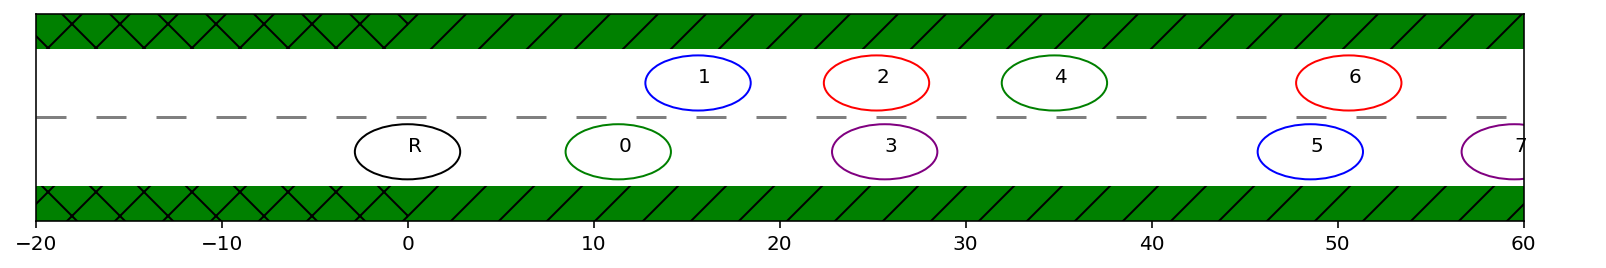

In [12]:
plot_multiple_cars(0, world, ambulance, amb_x0.reshape(6,1), [x.reshape(6,1) for x in all_other_x0], 
          None, car_labels = [str(i) for i in range(len(all_other_x0))])
plt.show()

In [13]:
N_total = 300
X_other = [np.zeros((6, N_total+1)) for i in range(len(all_other_vehicles))]
X_amb = np.zeros((6,N_total+1))

X_amb[:,0] = amb_x0
for i in range(len(X_other)):
    X_other[i][:,0] = all_other_x0[i]

    
idm_params = {
    "desired_time_gap": 0.1,
    "jam_distance": 4,
}

# out_file = open('/dev/null','rb')

for t in range(N_total):
    current_other_x0 = [X_other[i][:,t] for i in range(len(X_other))]
    current_amb_x0 = X_amb[:,t]
    current_other_veh = [all_other_vehicles[i] for i in range(len(X_other))]

    # Mobile lane change
    driver_x0 = current_amb_x0
    driver_veh = ambulance
    all_other_x0 = current_other_x0
    MOBIL_params = {
        "politeness_factor": 0.1,
    }
    # Compute whether lane change occurs
    desired_lane = True
    new_lane, accel = MOBIL_lanechange(driver_x0, driver_veh, all_other_x0, current_other_veh, world, desired_lane,
                                       MOBIL_params, idm_params)
    if new_lane is not None:
        driver_veh.update_desired_lane(world, new_lane, True)
        print("Ego", "new lane", new_lane)
        
    # Compute IDM acceleration (ambulance)
    lead_veh = get_lead_vehicle(current_amb_x0, current_other_x0, world)
    if lead_veh is None:
        x_lead = current_amb_x0 + 999999
        v_lead = 999999
    else:
        x_lead = current_other_x0[lead_veh]
        v_lead = x_lead[4] * np.cos(x_lead[2])

    v_current = current_amb_x0[4] * np.cos(current_amb_x0[2])
    v_desired = ambulance.max_v
    bumper_distance = x_lead[0] - current_amb_x0[0] 

    idm_params["maximum_acceleration"] = ambulance.max_acceleration 
    a_IDM = IDM_acceleration(bumper_distance, v_lead, v_current, v_desired, idm_params)
    
    # Solve for steering angle
    ambulance.k_lat = 5.0
    ambulance.k_lan = 2.0
    ambulance.k_x_dot = 0.0
    ambulance.k_final = 0.0
    
    solver_params = {
        "k_slack" : 1000,
        "k_CA": 0.05,
        "k_CA_power": 1.0,
#         "constant_v": True,
    }
    
    warm_starts = generate_warm_starts(ambulance, world, current_amb_x0, [], params)
    u=None    
    for k_warm in warm_starts:
        try:
            temp_ambulance = cp.deepcopy(ambulance)
            temp_ambulance.max_v = np.infty #max the optimization a little easier
            temp_ambulance.min_v = -np.infty #max the optimization a little easier
            temp_ambulance.min_y = -np.infty
            temp_ambulance.max_y = np.infty
            steering_mpc = MultiMPC(temp_ambulance, [], [], world, solver_params)
            n_mpc = 5
            steering_mpc.generate_optimization(params["N"], current_amb_x0, [], [], params=params, ipopt_params = {'print_level':0})
            
            u_warm, x_warm, x_des_warm = warm_starts[k_warm]

            steering_mpc.opti.set_initial(steering_mpc.u_ego, u_warm)
            steering_mpc.opti.set_initial(steering_mpc.x_ego, x_warm)
            steering_mpc.opti.set_initial(steering_mpc.xd_ego, x_des_warm)
#             with redirect_stdout(out_file):
            steering_mpc.solve(None, None)
            _, u, _ = steering_mpc.get_bestresponse_solution()            
        except RuntimeError:
            print("Solver didn't work")
            
        if u is not None:
            break
    if u is None:
        raise Exception("Solver didn't solve")
        
    # Update control and step the simulator    
    u_ego = np.array([[u[0,0]],[a_IDM*ambulance.dt]])
    
    # Update state with new control inputs
    x_ego_traj, _ = ambulance.forward_simulate_all(current_amb_x0, u_ego)    
    X_amb[:,t+1] = x_ego_traj[:, 1]
    

    # Other vehicles
    for ego_idx in range(len(all_other_vehicles)):
        N = 1
                           
    
        # Mobile lane change
        driver_x0 = current_other_x0[ego_idx] 
        driver_veh = all_other_vehicles[ego_idx]
        all_other_x0 = current_other_x0[:ego_idx] + current_other_x0[ego_idx+1:]  + [current_amb_x0]   
        all_other_veh = all_other_vehicles[:ego_idx] + all_other_vehicles[ego_idx+1:]  + [ambulance]    
        
        MOBIL_params = {
            "politeness_factor": 0.7,
        }
        new_lane, accel = MOBIL_lanechange(driver_x0, driver_veh, all_other_x0, all_other_veh, world, desired_lane,
                                       MOBIL_params, idm_params)
        if new_lane is not None:
            driver_veh.update_desired_lane(world, new_lane, True)
            print("Ado", ego_idx, "new lane", new_lane)
            print(accel)
       
        
        driver_x0 = current_other_x0[ego_idx]
        dummy_x0 = current_other_x0[ego_idx] - 10000
        ado_x0s = current_other_x0[:ego_idx] + [dummy_x0] + current_other_x0[ego_idx+1:]  + [current_amb_x0]
        
        lead_veh = get_lead_vehicle(current_other_x0[ego_idx], ado_x0s, world)    
        if lead_veh is None:
            x_lead = driver_x0 + 999999
            v_lead = 999999
        else:
            x_lead = ado_x0s[lead_veh]
            v_lead = x_lead[4] * np.cos(x_lead[2])

        v_current = driver_x0[4] * np.cos(driver_x0[2])
        v_desired = driver_veh.max_v
#         v_desired = 0.001
        bumper_distance = x_lead[0] - driver_x0[0] 

        idm_params["maximum_acceleration"] = driver_veh.max_acceleration 
        a_IDM = IDM_acceleration(bumper_distance, v_lead, v_current, v_desired, idm_params)        
                    
            
            


    # Solve for steering angle
        driver_veh.k_lat = 5.0
        driver_veh.k_lan = 2.0
        driver_veh.k_x_dot = 0.0
        driver_veh.k_final = 0.0

        solver_params = {
            "k_slack" : 1000,
            "k_CA": 0.05,
            "k_CA_power": 1.0,
    #         "constant_v": True,
        }

        warm_starts = generate_warm_starts(driver_veh, world, driver_x0, [], params)
        u = None    
        for k_warm in warm_starts:
            try:
                temp_veh = cp.deepcopy(driver_veh)
                temp_veh.max_v = np.infty #max the optimization a little easier                
                temp_veh.min_v = -np.infty #max the optimization a little easier                
                temp_veh.min_y = -np.infty #max the optimization a little easier                
                temp_veh.max_y = np.infty #max the optimization a little easier                

                steering_mpc = MultiMPC(temp_veh, [], [], world, solver_params)
                n_mpc = 5
                steering_mpc.generate_optimization(params["N"], driver_x0, [], [], params=params, ipopt_params = {'print_level':0})

                u_warm, x_warm, x_des_warm = warm_starts[k_warm]

                steering_mpc.opti.set_initial(steering_mpc.u_ego, u_warm)
                steering_mpc.opti.set_initial(steering_mpc.x_ego, x_warm)
                steering_mpc.opti.set_initial(steering_mpc.xd_ego, x_des_warm)
#                 with redirect_stdout(out_file):
                steering_mpc.solve(None, None)
                _, u, _ = steering_mpc.get_bestresponse_solution()            
            except RuntimeError:
                print("Solver didn't work")

            if u is not None:
                break
        if u is None:
            raise Exception("Solver didn't solve")

        # Update control and step the simulator    
        u_ego = np.array([[u[0,0]],[a_IDM*driver_veh.dt]])

        # Update state with new control inputs
        x_ego_traj, _ = driver_veh.forward_simulate_all(driver_x0, u_ego)    
        X_other[ego_idx][:,t+1] = x_ego_traj[:, 1]



        
        
        
        
        
#         print(ego_idx, X_ego[:,1])

Ego new lane 1
No collision avoidance checking distance
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 399.00us ( 12.87us) 379.20us ( 12.23us)        31
       nlp_g  |   2.44ms ( 78.65us)   2.43ms ( 78.45us)        31
    nlp_grad  | 263.00us (263.00us) 243.64us (243.64us)         1
  nlp_grad_f  | 695.00us ( 21.72us) 691.76us ( 21.62us)        32
  nlp_hess_l  |  33.57ms (  1.12ms)  33.33ms (  1.11ms)        30
   nlp_jac_g  |  17.02ms (531.81us)  16.86ms (526.83us)        32
       total  |  82.78ms ( 82.78ms)  82.09ms ( 82.09ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 131.00us ( 14.56us) 132.10us ( 14.68us)         9
       nlp_g  | 709.00us ( 78.78us) 706.46us ( 78.50us)         9
    nlp_grad  | 194.00us (194.00us) 194.01us (194.01us)         1
  nlp_grad_f  | 231.00us ( 23.10us) 233.06us ( 23.31us)        10
  nlp_hess_l  |   9.71ms (  1.21ms)   9.66ms (  1.21ms)         8
   nlp_jac_g  |   5.

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 125.93us ( 13.99us)         9
       nlp_g  | 709.00us ( 78.78us) 705.62us ( 78.40us)         9
    nlp_grad  | 205.00us (205.00us) 205.59us (205.59us)         1
  nlp_grad_f  | 247.00us ( 24.70us) 247.44us ( 24.74us)        10
  nlp_hess_l  |   9.98ms (  1.25ms)   9.98ms (  1.25ms)         8
   nlp_jac_g  |   5.15ms (514.70us)   5.15ms (515.35us)        10
       total  |  24.48ms ( 24.48ms)  24.48ms ( 24.48ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 125.12us ( 13.90us)         9
       nlp_g  | 709.00us ( 78.78us) 708.47us ( 78.72us)         9
    nlp_grad  | 240.00us (240.00us) 220.37us (220.37us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 243.66us ( 24.37us)        10
  nlp_hess_l  |  10.07ms (  1.26ms)   9.98ms (  1.25ms)         8
   nlp_jac_g  |   5.19ms (518.80us)   5.19ms (519.13us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 229.00us ( 14.31us) 233.67us ( 14.60us)        16
       nlp_g  |   1.32ms ( 82.50us)   1.32ms ( 82.46us)        16
    nlp_grad  | 256.00us (256.00us) 256.35us (256.35us)         1
  nlp_grad_f  | 425.00us ( 25.00us) 422.16us ( 24.83us)        17
  nlp_hess_l  |  19.70ms (  1.31ms)  19.62ms (  1.31ms)        15
   nlp_jac_g  |   9.40ms (553.12us)   9.40ms (552.66us)        17
       total  |  46.11ms ( 46.11ms)  45.98ms ( 45.98ms)         1
Ego new lane 1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 367.00us ( 12.66us) 367.12us ( 12.66us)        29
       nlp_g  |   2.32ms ( 80.03us)   2.32ms ( 80.06us)        29
    nlp_grad  | 198.00us (198.00us) 198.26us (198.26us)         1
  nlp_grad_f  | 676.00us ( 22.53us) 676.77us ( 22.56us)        30
  nlp_hess_l  |  30.87ms (  1.10ms)  30.73ms (  1.10ms)        28
   nlp_jac_g  |  15.63ms (520.90us)  15.65ms (521.58us)      

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 144.00us ( 16.00us) 143.47us ( 15.94us)         9
       nlp_g  | 752.00us ( 83.56us) 752.27us ( 83.59us)         9
    nlp_grad  | 284.00us (284.00us) 283.42us (283.42us)         1
  nlp_grad_f  | 327.00us ( 32.70us) 327.46us ( 32.75us)        10
  nlp_hess_l  |  10.27ms (  1.28ms)  10.25ms (  1.28ms)         8
   nlp_jac_g  |   5.61ms (561.50us)   5.58ms (558.13us)        10
       total  |  25.92ms ( 25.92ms)  25.81ms ( 25.81ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 138.00us ( 13.80us) 140.90us ( 14.09us)        10
       nlp_g  | 785.00us ( 78.50us) 784.46us ( 78.45us)        10
    nlp_grad  | 229.00us (229.00us) 229.07us (229.07us)         1
  nlp_grad_f  | 272.00us ( 24.73us) 273.27us ( 24.84us)        11
  nlp_hess_l  |  11.55ms (  1.28ms)  11.50ms (  1.28ms)         9
   nlp_jac_g  |   5.83ms (530.00us)   5.82ms (529.05us)        11
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 123.33us ( 13.70us)         9
       nlp_g  | 730.00us ( 81.11us) 728.91us ( 80.99us)         9
    nlp_grad  | 196.00us (196.00us) 195.82us (195.82us)         1
  nlp_grad_f  | 247.00us ( 24.70us) 246.34us ( 24.63us)        10
  nlp_hess_l  |   9.83ms (  1.23ms)   9.82ms (  1.23ms)         8
   nlp_jac_g  |   5.28ms (528.00us)   5.29ms (528.69us)        10
       total  |  24.69ms ( 24.69ms)  24.59ms ( 24.59ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 130.00us ( 14.44us) 127.25us ( 14.14us)         9
       nlp_g  | 690.00us ( 76.67us) 688.84us ( 76.54us)         9
    nlp_grad  | 213.00us (213.00us) 212.68us (212.68us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 243.32us ( 24.33us)        10
  nlp_hess_l  |   9.98ms (  1.25ms)   9.92ms (  1.24ms)         8
   nlp_jac_g  |   5.30ms (529.60us)   5.26ms (525.82us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 169.00us ( 18.78us) 168.43us ( 18.71us)         9
       nlp_g  | 797.00us ( 88.56us) 799.76us ( 88.86us)         9
    nlp_grad  | 287.00us (287.00us) 286.69us (286.69us)         1
  nlp_grad_f  | 317.00us ( 31.70us) 317.92us ( 31.79us)        10
  nlp_hess_l  |  10.75ms (  1.34ms)  10.72ms (  1.34ms)         8
   nlp_jac_g  |   5.75ms (574.80us)   5.74ms (573.68us)        10
       total  |  26.87ms ( 26.87ms)  26.77ms ( 26.77ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 133.00us ( 14.78us) 132.20us ( 14.69us)         9
       nlp_g  | 752.00us ( 83.56us) 748.54us ( 83.17us)         9
    nlp_grad  | 235.00us (235.00us) 235.24us (235.24us)         1
  nlp_grad_f  | 266.00us ( 26.60us) 266.02us ( 26.60us)        10
  nlp_hess_l  |  10.28ms (  1.29ms)  10.27ms (  1.28ms)         8
   nlp_jac_g  |   5.44ms (544.00us)   5.42ms (542.49us)        10
       tot

    nlp_grad  | 196.00us (196.00us) 195.96us (195.96us)         1
  nlp_grad_f  | 234.00us ( 23.40us) 233.50us ( 23.35us)        10
  nlp_hess_l  |   9.76ms (  1.22ms)   9.77ms (  1.22ms)         8
   nlp_jac_g  |   5.19ms (518.50us)   5.15ms (515.40us)        10
       total  |  23.93ms ( 23.93ms)  23.85ms ( 23.85ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 123.55us ( 13.73us)         9
       nlp_g  | 710.00us ( 78.89us) 688.90us ( 76.54us)         9
    nlp_grad  | 214.00us (214.00us) 214.63us (214.63us)         1
  nlp_grad_f  | 236.00us ( 23.60us) 234.90us ( 23.49us)        10
  nlp_hess_l  |  10.35ms (  1.29ms)  10.32ms (  1.29ms)         8
   nlp_jac_g  |   5.19ms (519.00us)   5.20ms (519.63us)        10
       total  |  24.99ms ( 24.99ms)  24.91ms ( 24.91ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 125.65us ( 13.96us)         9
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 289.00us ( 12.57us) 293.76us ( 12.77us)        23
       nlp_g  |   1.82ms ( 79.13us)   1.82ms ( 79.05us)        23
    nlp_grad  | 223.00us (223.00us) 223.22us (223.22us)         1
  nlp_grad_f  | 540.00us ( 22.50us) 540.49us ( 22.52us)        24
  nlp_hess_l  |  24.01ms (  1.09ms)  24.03ms (  1.09ms)        22
   nlp_jac_g  |  12.62ms (525.83us)  12.64ms (526.69us)        24
       total  |  60.60ms ( 60.60ms)  60.60ms ( 60.60ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 123.33us ( 13.70us)         9
       nlp_g  | 689.00us ( 76.56us) 687.78us ( 76.42us)         9
    nlp_grad  | 196.00us (196.00us) 196.03us (196.03us)         1
  nlp_grad_f  | 257.00us ( 25.70us) 238.12us ( 23.81us)        10
  nlp_hess_l  |   9.88ms (  1.24ms)   9.85ms (  1.23ms)         8
   nlp_jac_g  |   5.20ms (520.30us)   5.17ms (517.06us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 143.00us ( 15.89us) 124.54us ( 13.84us)         9
       nlp_g  | 725.00us ( 80.56us) 721.86us ( 80.21us)         9
    nlp_grad  | 217.00us (217.00us) 217.13us (217.13us)         1
  nlp_grad_f  | 245.00us ( 24.50us) 244.62us ( 24.46us)        10
  nlp_hess_l  |  10.03ms (  1.25ms)  10.02ms (  1.25ms)         8
   nlp_jac_g  |   5.20ms (520.20us)   5.21ms (520.86us)        10
       total  |  24.68ms ( 24.68ms)  24.60ms ( 24.60ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 123.47us ( 13.72us)         9
       nlp_g  | 725.00us ( 80.56us) 703.47us ( 78.16us)         9
    nlp_grad  | 207.00us (207.00us) 207.25us (207.25us)         1
  nlp_grad_f  | 273.00us ( 27.30us) 275.06us ( 27.51us)        10
  nlp_hess_l  |   9.90ms (  1.24ms)   9.85ms (  1.23ms)         8
   nlp_jac_g  |   5.26ms (525.80us)   5.21ms (520.50us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 273.00us ( 12.41us) 272.61us ( 12.39us)        22
       nlp_g  |   1.73ms ( 78.68us)   1.73ms ( 78.54us)        22
    nlp_grad  | 217.00us (217.00us) 217.59us (217.59us)         1
  nlp_grad_f  | 509.00us ( 22.13us) 511.52us ( 22.24us)        23
  nlp_hess_l  |  22.96ms (  1.09ms)  22.80ms (  1.09ms)        21
   nlp_jac_g  |  11.85ms (515.04us)  11.86ms (515.67us)        23
       total  |  59.90ms ( 59.90ms)  59.68ms ( 59.68ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 120.00us ( 13.33us) 120.96us ( 13.44us)         9
       nlp_g  | 696.00us ( 77.33us) 694.88us ( 77.21us)         9
    nlp_grad  | 207.00us (207.00us) 206.69us (206.69us)         1
  nlp_grad_f  | 265.00us ( 26.50us) 244.48us ( 24.45us)        10
  nlp_hess_l  |  10.03ms (  1.25ms)  10.03ms (  1.25ms)         8
   nlp_jac_g  |   5.31ms (531.10us)   5.31ms (530.63us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 129.00us ( 14.33us) 129.23us ( 14.36us)         9
       nlp_g  | 730.00us ( 81.11us) 729.66us ( 81.07us)         9
    nlp_grad  | 233.00us (233.00us) 232.70us (232.70us)         1
  nlp_grad_f  | 249.00us ( 24.90us) 250.29us ( 25.03us)        10
  nlp_hess_l  |  10.34ms (  1.29ms)  10.31ms (  1.29ms)         8
   nlp_jac_g  |   5.42ms (541.90us)   5.43ms (542.53us)        10
       total  |  25.48ms ( 25.48ms)  25.38ms ( 25.38ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 123.12us ( 13.68us)         9
       nlp_g  | 702.00us ( 78.00us) 700.97us ( 77.89us)         9
    nlp_grad  | 237.00us (237.00us) 237.48us (237.48us)         1
  nlp_grad_f  | 240.00us ( 24.00us) 235.36us ( 23.54us)        10
  nlp_hess_l  |   9.93ms (  1.24ms)   9.89ms (  1.24ms)         8
   nlp_jac_g  |   5.19ms (518.50us)   5.13ms (512.92us)        10
       tot

       nlp_g  |   1.10ms ( 78.86us)   1.10ms ( 78.60us)        14
    nlp_grad  | 198.00us (198.00us) 197.79us (197.79us)         1
  nlp_grad_f  | 356.00us ( 23.73us) 355.70us ( 23.71us)        15
  nlp_hess_l  |  15.94ms (  1.23ms)  15.95ms (  1.23ms)        13
   nlp_jac_g  |   7.94ms (529.20us)   7.89ms (525.93us)        15
       total  |  38.03ms ( 38.03ms)  37.87ms ( 37.87ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 223.00us ( 12.39us) 222.52us ( 12.36us)        18
       nlp_g  |   1.38ms ( 76.56us)   1.38ms ( 76.51us)        18
    nlp_grad  | 195.00us (195.00us) 195.01us (195.01us)         1
  nlp_grad_f  | 415.00us ( 21.84us) 414.88us ( 21.84us)        19
  nlp_hess_l  |  18.59ms (  1.09ms)  18.44ms (  1.08ms)        17
   nlp_jac_g  |   9.75ms (513.21us)   9.77ms (514.14us)        19
       total  |  46.90ms ( 46.90ms)  46.72ms ( 46.72ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 120.00us ( 13.33us) 119.90us ( 13.32us)         9
       nlp_g  | 685.00us ( 76.11us) 684.50us ( 76.06us)         9
    nlp_grad  | 197.00us (197.00us) 197.33us (197.33us)         1
  nlp_grad_f  | 253.00us ( 25.30us) 254.51us ( 25.45us)        10
  nlp_hess_l  |   9.73ms (  1.22ms)   9.74ms (  1.22ms)         8
   nlp_jac_g  |   5.14ms (514.10us)   5.15ms (514.69us)        10
       total  |  24.03ms ( 24.03ms)  24.03ms ( 24.03ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 123.77us ( 13.75us)         9
       nlp_g  | 702.00us ( 78.00us) 699.92us ( 77.77us)         9
    nlp_grad  | 209.00us (209.00us) 208.31us (208.31us)         1
  nlp_grad_f  | 250.00us ( 25.00us) 249.96us ( 25.00us)        10
  nlp_hess_l  |   9.70ms (  1.21ms)   9.71ms (  1.21ms)         8
   nlp_jac_g  |   5.20ms (520.30us)   5.21ms (521.13us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 245.00us ( 12.25us) 248.08us ( 12.40us)        20
       nlp_g  |   1.57ms ( 78.40us)   1.56ms ( 78.14us)        20
    nlp_grad  | 195.00us (195.00us) 195.52us (195.52us)         1
  nlp_grad_f  | 465.00us ( 22.14us) 467.90us ( 22.28us)        21
  nlp_hess_l  |  20.86ms (  1.10ms)  20.66ms (  1.09ms)        19
   nlp_jac_g  |  10.93ms (520.43us)  10.94ms (521.12us)        21
       total  |  52.59ms ( 52.59ms)  52.38ms ( 52.38ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 122.31us ( 13.59us)         9
       nlp_g  | 716.00us ( 79.56us) 715.10us ( 79.46us)         9
    nlp_grad  | 195.00us (195.00us) 195.03us (195.03us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 240.63us ( 24.06us)        10
  nlp_hess_l  |   9.61ms (  1.20ms)   9.62ms (  1.20ms)         8
   nlp_jac_g  |   5.11ms (511.30us)   5.12ms (512.11us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 126.66us ( 14.07us)         9
       nlp_g  | 723.00us ( 80.33us) 722.29us ( 80.25us)         9
    nlp_grad  | 198.00us (198.00us) 198.60us (198.60us)         1
  nlp_grad_f  | 245.00us ( 24.50us) 244.68us ( 24.47us)        10
  nlp_hess_l  |   9.99ms (  1.25ms)   9.93ms (  1.24ms)         8
   nlp_jac_g  |   5.17ms (517.30us)   5.19ms (519.35us)        10
       total  |  24.82ms ( 24.82ms)  24.65ms ( 24.65ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 139.00us ( 15.44us) 136.01us ( 15.11us)         9
       nlp_g  | 725.00us ( 80.56us) 724.31us ( 80.48us)         9
    nlp_grad  | 230.00us (230.00us) 229.78us (229.78us)         1
  nlp_grad_f  | 270.00us ( 27.00us) 268.65us ( 26.87us)        10
  nlp_hess_l  |  10.14ms (  1.27ms)  10.11ms (  1.26ms)         8
   nlp_jac_g  |   5.39ms (539.30us)   5.37ms (537.07us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 129.37us ( 14.37us)         9
       nlp_g  | 738.00us ( 82.00us) 738.13us ( 82.01us)         9
    nlp_grad  | 206.00us (206.00us) 207.56us (207.56us)         1
  nlp_grad_f  | 269.00us ( 26.90us) 266.92us ( 26.69us)        10
  nlp_hess_l  |   9.90ms (  1.24ms)   9.89ms (  1.24ms)         8
   nlp_jac_g  |   5.30ms (530.30us)   5.31ms (530.97us)        10
       total  |  24.89ms ( 24.89ms)  24.81ms ( 24.81ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 127.42us ( 14.16us)         9
       nlp_g  | 718.00us ( 79.78us) 715.19us ( 79.47us)         9
    nlp_grad  | 219.00us (219.00us) 219.42us (219.42us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 242.74us ( 24.27us)        10
  nlp_hess_l  |  10.34ms (  1.29ms)  10.30ms (  1.29ms)         8
   nlp_jac_g  |   5.19ms (518.60us)   5.17ms (517.44us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 125.89us ( 13.99us)         9
       nlp_g  | 728.00us ( 80.89us) 709.93us ( 78.88us)         9
    nlp_grad  | 197.00us (197.00us) 197.88us (197.88us)         1
  nlp_grad_f  | 253.00us ( 25.30us) 254.04us ( 25.40us)        10
  nlp_hess_l  |  10.11ms (  1.26ms)  10.10ms (  1.26ms)         8
   nlp_jac_g  |   5.31ms (531.10us)   5.32ms (531.72us)        10
       total  |  24.81ms ( 24.81ms)  24.73ms ( 24.73ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 123.70us ( 13.74us)         9
       nlp_g  | 688.00us ( 76.44us) 687.42us ( 76.38us)         9
    nlp_grad  | 218.00us (218.00us) 218.34us (218.34us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 240.20us ( 24.02us)        10
  nlp_hess_l  |   9.94ms (  1.24ms)   9.88ms (  1.23ms)         8
   nlp_jac_g  |   5.19ms (519.20us)   5.18ms (518.02us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 142.00us ( 15.78us) 121.57us ( 13.51us)         9
       nlp_g  | 714.00us ( 79.33us) 693.17us ( 77.02us)         9
    nlp_grad  | 195.00us (195.00us) 195.35us (195.35us)         1
  nlp_grad_f  | 236.00us ( 23.60us) 235.97us ( 23.60us)        10
  nlp_hess_l  |   9.53ms (  1.19ms)   9.54ms (  1.19ms)         8
   nlp_jac_g  |   5.24ms (524.30us)   5.23ms (523.06us)        10
       total  |  23.92ms ( 23.92ms)  23.82ms ( 23.82ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 129.00us ( 14.33us) 129.00us ( 14.33us)         9
       nlp_g  | 742.00us ( 82.44us) 741.04us ( 82.34us)         9
    nlp_grad  | 245.00us (245.00us) 245.75us (245.75us)         1
  nlp_grad_f  | 257.00us ( 25.70us) 257.10us ( 25.71us)        10
  nlp_hess_l  |  10.51ms (  1.31ms)  10.49ms (  1.31ms)         8
   nlp_jac_g  |   5.66ms (565.60us)   5.66ms (566.34us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 128.49us ( 14.28us)         9
       nlp_g  | 723.00us ( 80.33us) 723.69us ( 80.41us)         9
    nlp_grad  | 211.00us (211.00us) 211.11us (211.11us)         1
  nlp_grad_f  | 248.00us ( 24.80us) 248.61us ( 24.86us)        10
  nlp_hess_l  |  10.31ms (  1.29ms)  10.28ms (  1.29ms)         8
   nlp_jac_g  |   5.35ms (534.50us)   5.34ms (533.54us)        10
       total  |  25.34ms ( 25.34ms)  25.25ms ( 25.25ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 122.47us ( 13.61us)         9
       nlp_g  | 685.00us ( 76.11us) 684.48us ( 76.05us)         9
    nlp_grad  | 195.00us (195.00us) 195.84us (195.84us)         1
  nlp_grad_f  | 240.00us ( 24.00us) 236.68us ( 23.67us)        10
  nlp_hess_l  |   9.80ms (  1.23ms)   9.73ms (  1.22ms)         8
   nlp_jac_g  |   5.10ms (509.70us)   5.10ms (510.38us)        10
       tot

       nlp_g  | 699.00us ( 77.67us) 698.42us ( 77.60us)         9
    nlp_grad  | 194.00us (194.00us) 194.23us (194.23us)         1
  nlp_grad_f  | 239.00us ( 23.90us) 238.18us ( 23.82us)        10
  nlp_hess_l  |   9.80ms (  1.22ms)   9.73ms (  1.22ms)         8
   nlp_jac_g  |   5.04ms (503.90us)   5.04ms (504.34us)        10
       total  |  23.94ms ( 23.94ms)  23.84ms ( 23.84ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 157.00us ( 17.44us) 138.04us ( 15.34us)         9
       nlp_g  | 693.00us ( 77.00us) 691.97us ( 76.89us)         9
    nlp_grad  | 195.00us (195.00us) 195.73us (195.73us)         1
  nlp_grad_f  | 237.00us ( 23.70us) 236.78us ( 23.68us)        10
  nlp_hess_l  |   9.90ms (  1.24ms)   9.90ms (  1.24ms)         8
   nlp_jac_g  |   5.26ms (526.40us)   5.23ms (523.11us)        10
       total  |  24.49ms ( 24.49ms)  24.40ms ( 24.40ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 127.15us ( 14.13us)         9
       nlp_g  | 782.00us ( 86.89us) 782.22us ( 86.91us)         9
    nlp_grad  | 230.00us (230.00us) 230.88us (230.88us)         1
  nlp_grad_f  | 249.00us ( 24.90us) 247.98us ( 24.80us)        10
  nlp_hess_l  |  10.07ms (  1.26ms)  10.04ms (  1.26ms)         8
   nlp_jac_g  |   5.37ms (536.90us)   5.37ms (537.41us)        10
       total  |  25.04ms ( 25.04ms)  24.95ms ( 24.95ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 122.21us ( 13.58us)         9
       nlp_g  | 693.00us ( 77.00us) 691.71us ( 76.86us)         9
    nlp_grad  | 198.00us (198.00us) 197.70us (197.70us)         1
  nlp_grad_f  | 239.00us ( 23.90us) 236.70us ( 23.67us)        10
  nlp_hess_l  |   9.90ms (  1.24ms)   9.87ms (  1.23ms)         8
   nlp_jac_g  |   5.23ms (523.00us)   5.18ms (517.60us)        10
       tot

    nlp_grad  | 199.00us (199.00us) 199.97us (199.97us)         1
  nlp_grad_f  | 260.00us ( 26.00us) 239.97us ( 24.00us)        10
  nlp_hess_l  |   9.83ms (  1.23ms)   9.83ms (  1.23ms)         8
   nlp_jac_g  |   5.16ms (515.60us)   5.08ms (507.64us)        10
       total  |  24.19ms ( 24.19ms)  24.08ms ( 24.08ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 123.53us ( 13.73us)         9
       nlp_g  | 703.00us ( 78.11us) 703.99us ( 78.22us)         9
    nlp_grad  | 251.00us (251.00us) 230.65us (230.65us)         1
  nlp_grad_f  | 249.00us ( 24.90us) 251.14us ( 25.11us)        10
  nlp_hess_l  |   9.86ms (  1.23ms)   9.78ms (  1.22ms)         8
   nlp_jac_g  |   5.28ms (528.40us)   5.29ms (529.49us)        10
       total  |  24.46ms ( 24.46ms)  24.36ms ( 24.36ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 122.75us ( 13.64us)         9
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 145.00us ( 16.11us) 145.35us ( 16.15us)         9
       nlp_g  | 756.00us ( 84.00us) 753.07us ( 83.67us)         9
    nlp_grad  | 219.00us (219.00us) 219.07us (219.07us)         1
  nlp_grad_f  | 267.00us ( 26.70us) 266.07us ( 26.61us)        10
  nlp_hess_l  |  10.28ms (  1.28ms)  10.25ms (  1.28ms)         8
   nlp_jac_g  |   5.35ms (535.20us)   5.34ms (533.89us)        10
       total  |  25.57ms ( 25.57ms)  25.47ms ( 25.47ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 119.00us ( 13.22us) 121.46us ( 13.50us)         9
       nlp_g  | 673.00us ( 74.78us) 671.65us ( 74.63us)         9
    nlp_grad  | 212.00us (212.00us) 212.42us (212.42us)         1
  nlp_grad_f  | 233.00us ( 23.30us) 233.51us ( 23.35us)        10
  nlp_hess_l  |   9.87ms (  1.23ms)   9.79ms (  1.22ms)         8
   nlp_jac_g  |   5.05ms (504.60us)   5.03ms (503.35us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 124.03us ( 13.78us)         9
       nlp_g  | 733.00us ( 81.44us) 711.05us ( 79.01us)         9
    nlp_grad  | 194.00us (194.00us) 194.48us (194.48us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 239.28us ( 23.93us)        10
  nlp_hess_l  |   9.84ms (  1.23ms)   9.82ms (  1.23ms)         8
   nlp_jac_g  |   5.43ms (542.80us)   5.38ms (537.76us)        10
       total  |  24.67ms ( 24.67ms)  24.57ms ( 24.57ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 144.00us ( 14.40us) 144.01us ( 14.40us)        10
       nlp_g  | 813.00us ( 81.30us) 792.43us ( 79.24us)        10
    nlp_grad  | 193.00us (193.00us) 193.09us (193.09us)         1
  nlp_grad_f  | 265.00us ( 24.09us) 264.71us ( 24.06us)        11
  nlp_hess_l  |  11.08ms (  1.23ms)  11.07ms (  1.23ms)         9
   nlp_jac_g  |   5.76ms (523.45us)   5.72ms (520.17us)        11
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 128.55us ( 14.28us)         9
       nlp_g  | 739.00us ( 82.11us) 737.97us ( 82.00us)         9
    nlp_grad  | 234.00us (234.00us) 234.05us (234.05us)         1
  nlp_grad_f  | 248.00us ( 24.80us) 251.23us ( 25.12us)        10
  nlp_hess_l  |  10.30ms (  1.29ms)  10.31ms (  1.29ms)         8
   nlp_jac_g  |   5.52ms (552.50us)   5.53ms (553.25us)        10
       total  |  25.56ms ( 25.56ms)  25.56ms ( 25.56ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 119.00us ( 13.22us) 119.70us ( 13.30us)         9
       nlp_g  | 676.00us ( 75.11us) 673.79us ( 74.87us)         9
    nlp_grad  | 197.00us (197.00us) 196.94us (196.94us)         1
  nlp_grad_f  | 235.00us ( 23.50us) 237.12us ( 23.71us)        10
  nlp_hess_l  |   9.49ms (  1.19ms)   9.50ms (  1.19ms)         8
   nlp_jac_g  |   4.99ms (498.90us)   4.99ms (499.43us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 120.81us ( 13.42us)         9
       nlp_g  | 686.00us ( 76.22us) 688.60us ( 76.51us)         9
    nlp_grad  | 195.00us (195.00us) 194.83us (194.83us)         1
  nlp_grad_f  | 233.00us ( 23.30us) 235.05us ( 23.50us)        10
  nlp_hess_l  |   9.96ms (  1.25ms)   9.89ms (  1.24ms)         8
   nlp_jac_g  |   5.05ms (504.70us)   5.05ms (505.05us)        10
       total  |  24.21ms ( 24.21ms)  24.11ms ( 24.11ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 126.15us ( 14.02us)         9
       nlp_g  | 722.00us ( 80.22us) 704.05us ( 78.23us)         9
    nlp_grad  | 224.00us (224.00us) 224.41us (224.41us)         1
  nlp_grad_f  | 247.00us ( 24.70us) 248.52us ( 24.85us)        10
  nlp_hess_l  |  10.07ms (  1.26ms)  10.02ms (  1.25ms)         8
   nlp_jac_g  |   5.36ms (535.80us)   5.32ms (531.95us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 115.00us ( 12.78us) 116.81us ( 12.98us)         9
       nlp_g  | 748.00us ( 83.11us) 746.33us ( 82.93us)         9
    nlp_grad  | 213.00us (213.00us) 213.25us (213.25us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 241.28us ( 24.13us)        10
  nlp_hess_l  |   9.33ms (  1.17ms)   9.34ms (  1.17ms)         8
   nlp_jac_g  |   5.43ms (543.10us)   5.44ms (543.81us)        10
       total  |  24.96ms ( 24.96ms)  24.96ms ( 24.96ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 123.98us ( 13.78us)         9
       nlp_g  | 720.00us ( 80.00us) 720.58us ( 80.06us)         9
    nlp_grad  | 216.00us (216.00us) 216.37us (216.37us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 244.05us ( 24.41us)        10
  nlp_hess_l  |   9.94ms (  1.24ms)   9.95ms (  1.24ms)         8
   nlp_jac_g  |   5.21ms (521.10us)   5.22ms (521.62us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 154.00us ( 17.11us) 153.54us ( 17.06us)         9
       nlp_g  | 857.00us ( 95.22us) 838.49us ( 93.17us)         9
    nlp_grad  | 316.00us (316.00us) 316.96us (316.96us)         1
  nlp_grad_f  | 322.00us ( 32.20us) 322.95us ( 32.30us)        10
  nlp_hess_l  |  10.51ms (  1.31ms)  10.48ms (  1.31ms)         8
   nlp_jac_g  |   5.83ms (583.30us)   5.84ms (583.95us)        10
       total  |  26.83ms ( 26.83ms)  26.73ms ( 26.73ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 156.00us ( 17.33us) 158.11us ( 17.57us)         9
       nlp_g  | 781.00us ( 86.78us) 779.41us ( 86.60us)         9
    nlp_grad  | 292.00us (292.00us) 292.17us (292.17us)         1
  nlp_grad_f  | 336.00us ( 33.60us) 336.70us ( 33.67us)        10
  nlp_hess_l  |  10.79ms (  1.35ms)  10.75ms (  1.34ms)         8
   nlp_jac_g  |   5.81ms (580.60us)   5.80ms (579.55us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 124.24us ( 13.80us)         9
       nlp_g  | 728.00us ( 80.89us) 728.67us ( 80.96us)         9
    nlp_grad  | 199.00us (199.00us) 199.44us (199.44us)         1
  nlp_grad_f  | 259.00us ( 25.90us) 241.08us ( 24.11us)        10
  nlp_hess_l  |   9.89ms (  1.24ms)   9.90ms (  1.24ms)         8
   nlp_jac_g  |   5.31ms (530.70us)   5.30ms (529.74us)        10
       total  |  24.56ms ( 24.56ms)  24.46ms ( 24.46ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 127.56us ( 14.17us)         9
       nlp_g  | 705.00us ( 78.33us) 704.98us ( 78.33us)         9
    nlp_grad  | 207.00us (207.00us) 207.39us (207.39us)         1
  nlp_grad_f  | 240.00us ( 24.00us) 241.31us ( 24.13us)        10
  nlp_hess_l  |   9.86ms (  1.23ms)   9.87ms (  1.23ms)         8
   nlp_jac_g  |   5.24ms (523.50us)   5.24ms (524.20us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 123.79us ( 13.75us)         9
       nlp_g  | 698.00us ( 77.56us) 696.66us ( 77.41us)         9
    nlp_grad  | 213.00us (213.00us) 212.69us (212.69us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 237.36us ( 23.74us)        10
  nlp_hess_l  |   9.52ms (  1.19ms)   9.52ms (  1.19ms)         8
   nlp_jac_g  |   5.20ms (519.60us)   5.16ms (516.12us)        10
       total  |  24.00ms ( 24.00ms)  23.92ms ( 23.92ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 124.80us ( 13.87us)         9
       nlp_g  | 705.00us ( 78.33us) 704.07us ( 78.23us)         9
    nlp_grad  | 204.00us (204.00us) 204.12us (204.12us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 242.53us ( 24.25us)        10
  nlp_hess_l  |   10.00ms (  1.25ms)   9.94ms (  1.24ms)         8
   nlp_jac_g  |   5.10ms (510.20us)   5.11ms (510.88us)        10
       to

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 120.80us ( 13.42us)         9
       nlp_g  | 697.00us ( 77.44us) 696.70us ( 77.41us)         9
    nlp_grad  | 194.00us (194.00us) 194.03us (194.03us)         1
  nlp_grad_f  | 235.00us ( 23.50us) 235.22us ( 23.52us)        10
  nlp_hess_l  |  10.05ms (  1.26ms)  10.00ms (  1.25ms)         8
   nlp_jac_g  |   5.19ms (518.50us)   5.16ms (515.52us)        10
       total  |  24.40ms ( 24.40ms)  24.31ms ( 24.31ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 143.00us ( 15.89us) 122.48us ( 13.61us)         9
       nlp_g  | 722.00us ( 80.22us) 703.27us ( 78.14us)         9
    nlp_grad  | 193.00us (193.00us) 193.45us (193.45us)         1
  nlp_grad_f  | 250.00us ( 25.00us) 249.09us ( 24.91us)        10
  nlp_hess_l  |   9.61ms (  1.20ms)   9.61ms (  1.20ms)         8
   nlp_jac_g  |   5.18ms (517.80us)   5.17ms (516.78us)        10
       tot

    nlp_grad  | 196.00us (196.00us) 197.19us (197.19us)         1
  nlp_grad_f  | 250.00us ( 25.00us) 249.88us ( 24.99us)        10
  nlp_hess_l  |   9.75ms (  1.22ms)   9.75ms (  1.22ms)         8
   nlp_jac_g  |   5.17ms (517.20us)   5.14ms (513.90us)        10
       total  |  24.04ms ( 24.04ms)  23.96ms ( 23.96ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 124.44us ( 13.83us)         9
       nlp_g  | 697.00us ( 77.44us) 696.60us ( 77.40us)         9
    nlp_grad  | 196.00us (196.00us) 196.58us (196.58us)         1
  nlp_grad_f  | 245.00us ( 24.50us) 246.64us ( 24.66us)        10
  nlp_hess_l  |   9.74ms (  1.22ms)   9.73ms (  1.22ms)         8
   nlp_jac_g  |   5.20ms (519.90us)   5.21ms (520.55us)        10
       total  |  24.33ms ( 24.33ms)  24.24ms ( 24.24ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 126.68us ( 14.08us)         9
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 124.77us ( 13.86us)         9
       nlp_g  | 720.00us ( 80.00us) 718.75us ( 79.86us)         9
    nlp_grad  | 227.00us (227.00us) 227.51us (227.51us)         1
  nlp_grad_f  | 246.00us ( 24.60us) 246.19us ( 24.62us)        10
  nlp_hess_l  |   9.78ms (  1.22ms)   9.75ms (  1.22ms)         8
   nlp_jac_g  |   5.35ms (534.80us)   5.35ms (535.47us)        10
       total  |  24.63ms ( 24.63ms)  24.55ms ( 24.55ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 123.30us ( 13.70us)         9
       nlp_g  | 726.00us ( 80.67us) 707.28us ( 78.59us)         9
    nlp_grad  | 195.00us (195.00us) 194.85us (194.85us)         1
  nlp_grad_f  | 247.00us ( 24.70us) 248.42us ( 24.84us)        10
  nlp_hess_l  |   9.47ms (  1.18ms)   9.48ms (  1.18ms)         8
   nlp_jac_g  |   5.29ms (528.60us)   5.25ms (525.35us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 124.16us ( 13.80us)         9
       nlp_g  | 691.00us ( 76.78us) 689.56us ( 76.62us)         9
    nlp_grad  | 196.00us (196.00us) 196.18us (196.18us)         1
  nlp_grad_f  | 239.00us ( 23.90us) 239.78us ( 23.98us)        10
  nlp_hess_l  |  10.00ms (  1.25ms)   9.97ms (  1.25ms)         8
   nlp_jac_g  |   5.09ms (509.20us)   5.10ms (509.99us)        10
       total  |  24.53ms ( 24.53ms)  24.45ms ( 24.45ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 122.87us ( 13.65us)         9
       nlp_g  | 709.00us ( 78.78us) 708.90us ( 78.77us)         9
    nlp_grad  | 203.00us (203.00us) 203.56us (203.56us)         1
  nlp_grad_f  | 244.00us ( 24.40us) 245.90us ( 24.59us)        10
  nlp_hess_l  |   9.73ms (  1.22ms)   9.68ms (  1.21ms)         8
   nlp_jac_g  |   5.18ms (517.60us)   5.18ms (518.27us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 144.00us ( 16.00us) 124.11us ( 13.79us)         9
       nlp_g  | 717.00us ( 79.67us) 713.03us ( 79.23us)         9
    nlp_grad  | 209.00us (209.00us) 209.82us (209.82us)         1
  nlp_grad_f  | 250.00us ( 25.00us) 250.85us ( 25.08us)        10
  nlp_hess_l  |   9.98ms (  1.25ms)   9.96ms (  1.25ms)         8
   nlp_jac_g  |   5.32ms (532.40us)   5.32ms (531.87us)        10
       total  |  24.72ms ( 24.72ms)  24.63ms ( 24.63ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 121.86us ( 13.54us)         9
       nlp_g  | 707.00us ( 78.56us) 704.43us ( 78.27us)         9
    nlp_grad  | 193.00us (193.00us) 194.17us (194.17us)         1
  nlp_grad_f  | 245.00us ( 24.50us) 243.52us ( 24.35us)        10
  nlp_hess_l  |   9.76ms (  1.22ms)   9.71ms (  1.21ms)         8
   nlp_jac_g  |   5.08ms (508.40us)   5.09ms (509.14us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 127.57us ( 14.17us)         9
       nlp_g  | 755.00us ( 83.89us) 737.63us ( 81.96us)         9
    nlp_grad  | 215.00us (215.00us) 214.68us (214.68us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 241.98us ( 24.20us)        10
  nlp_hess_l  |  10.04ms (  1.26ms)  10.01ms (  1.25ms)         8
   nlp_jac_g  |   5.28ms (527.60us)   5.27ms (527.31us)        10
       total  |  24.75ms ( 24.75ms)  24.65ms ( 24.65ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 131.00us ( 14.56us) 129.95us ( 14.44us)         9
       nlp_g  | 708.00us ( 78.67us) 706.60us ( 78.51us)         9
    nlp_grad  | 249.00us (249.00us) 250.12us (250.12us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 242.58us ( 24.26us)        10
  nlp_hess_l  |  10.02ms (  1.25ms)   9.95ms (  1.24ms)         8
   nlp_jac_g  |   5.37ms (537.00us)   5.36ms (536.31us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 127.69us ( 14.19us)         9
       nlp_g  | 758.00us ( 84.22us) 747.85us ( 83.09us)         9
    nlp_grad  | 243.00us (243.00us) 243.40us (243.40us)         1
  nlp_grad_f  | 261.00us ( 26.10us) 261.07us ( 26.11us)        10
  nlp_hess_l  |  10.28ms (  1.28ms)  10.26ms (  1.28ms)         8
   nlp_jac_g  |   5.54ms (553.50us)   5.52ms (552.38us)        10
       total  |  25.76ms ( 25.76ms)  25.67ms ( 25.67ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 125.43us ( 13.94us)         9
       nlp_g  | 692.00us ( 76.89us) 690.22us ( 76.69us)         9
    nlp_grad  | 216.00us (216.00us) 216.01us (216.01us)         1
  nlp_grad_f  | 240.00us ( 24.00us) 241.60us ( 24.16us)        10
  nlp_hess_l  |   9.72ms (  1.22ms)   9.73ms (  1.22ms)         8
   nlp_jac_g  |   5.23ms (523.40us)   5.24ms (524.30us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 127.08us ( 14.12us)         9
       nlp_g  | 703.00us ( 78.11us) 701.65us ( 77.96us)         9
    nlp_grad  | 208.00us (208.00us) 207.89us (207.89us)         1
  nlp_grad_f  | 239.00us ( 23.90us) 242.21us ( 24.22us)        10
  nlp_hess_l  |   9.89ms (  1.24ms)   9.91ms (  1.24ms)         8
   nlp_jac_g  |   5.20ms (519.60us)   5.20ms (520.26us)        10
       total  |  24.37ms ( 24.37ms)  24.38ms ( 24.38ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 124.37us ( 13.82us)         9
       nlp_g  | 726.00us ( 80.67us) 707.10us ( 78.57us)         9
    nlp_grad  | 196.00us (196.00us) 196.08us (196.08us)         1
  nlp_grad_f  | 261.00us ( 26.10us) 242.53us ( 24.25us)        10
  nlp_hess_l  |   9.73ms (  1.22ms)   9.74ms (  1.22ms)         8
   nlp_jac_g  |   5.33ms (533.40us)   5.30ms (530.08us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 122.73us ( 13.64us)         9
       nlp_g  | 709.00us ( 78.78us) 708.34us ( 78.70us)         9
    nlp_grad  | 211.00us (211.00us) 211.58us (211.58us)         1
  nlp_grad_f  | 251.00us ( 25.10us) 252.34us ( 25.23us)        10
  nlp_hess_l  |  10.16ms (  1.27ms)  10.11ms (  1.26ms)         8
   nlp_jac_g  |   5.24ms (524.20us)   5.25ms (524.82us)        10
       total  |  24.91ms ( 24.91ms)  24.81ms ( 24.81ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 121.55us ( 13.51us)         9
       nlp_g  | 725.00us ( 80.56us) 724.51us ( 80.50us)         9
    nlp_grad  | 195.00us (195.00us) 194.49us (194.49us)         1
  nlp_grad_f  | 237.00us ( 23.70us) 239.81us ( 23.98us)        10
  nlp_hess_l  |   9.75ms (  1.22ms)   9.75ms (  1.22ms)         8
   nlp_jac_g  |   5.34ms (534.20us)   5.31ms (530.55us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 122.37us ( 13.60us)         9
       nlp_g  | 684.00us ( 76.00us) 681.66us ( 75.74us)         9
    nlp_grad  | 197.00us (197.00us) 197.19us (197.19us)         1
  nlp_grad_f  | 239.00us ( 23.90us) 240.81us ( 24.08us)        10
  nlp_hess_l  |   9.67ms (  1.21ms)   9.63ms (  1.20ms)         8
   nlp_jac_g  |   5.21ms (521.10us)   5.16ms (515.86us)        10
       total  |  23.96ms ( 23.96ms)  23.85ms ( 23.85ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 124.52us ( 13.84us)         9
       nlp_g  | 713.00us ( 79.22us) 711.00us ( 79.00us)         9
    nlp_grad  | 201.00us (201.00us) 200.86us (200.86us)         1
  nlp_grad_f  | 244.00us ( 24.40us) 244.99us ( 24.50us)        10
  nlp_hess_l  |   9.84ms (  1.23ms)   9.84ms (  1.23ms)         8
   nlp_jac_g  |   5.21ms (521.20us)   5.22ms (521.97us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 143.00us ( 14.30us) 140.21us ( 14.02us)        10
       nlp_g  | 805.00us ( 80.50us) 803.42us ( 80.34us)        10
    nlp_grad  | 221.00us (221.00us) 221.35us (221.35us)         1
  nlp_grad_f  | 268.00us ( 24.36us) 268.06us ( 24.37us)        11
  nlp_hess_l  |  11.56ms (  1.28ms)  11.55ms (  1.28ms)         9
   nlp_jac_g  |   5.96ms (541.91us)   5.95ms (540.79us)        11
       total  |  28.05ms ( 28.05ms)  27.96ms ( 27.96ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 122.00us ( 13.56us)         9
       nlp_g  | 687.00us ( 76.33us) 684.60us ( 76.07us)         9
    nlp_grad  | 203.00us (203.00us) 203.00us (203.00us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 242.01us ( 24.20us)        10
  nlp_hess_l  |   9.77ms (  1.22ms)   9.69ms (  1.21ms)         8
   nlp_jac_g  |   5.12ms (512.40us)   5.13ms (513.11us)        10
       tot

       total  |  25.08ms ( 25.08ms)  24.98ms ( 24.98ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 122.30us ( 13.59us)         9
       nlp_g  | 684.00us ( 76.00us) 683.33us ( 75.93us)         9
    nlp_grad  | 214.00us (214.00us) 196.93us (196.93us)         1
  nlp_grad_f  | 258.00us ( 25.80us) 273.57us ( 27.36us)        10
  nlp_hess_l  |   9.89ms (  1.24ms)   9.77ms (  1.22ms)         8
   nlp_jac_g  |   5.23ms (523.00us)   5.22ms (521.58us)        10
       total  |  24.35ms ( 24.35ms)  24.18ms ( 24.18ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 126.74us ( 14.08us)         9
       nlp_g  | 708.00us ( 78.67us) 707.91us ( 78.66us)         9
    nlp_grad  | 220.00us (220.00us) 219.72us (219.72us)         1
  nlp_grad_f  | 256.00us ( 25.60us) 257.45us ( 25.75us)        10
  nlp_hess_l  |  10.02ms (  1.25ms)   9.95ms (  1.24ms)         8
   nlp_jac

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 124.04us ( 13.78us)         9
       nlp_g  | 736.00us ( 81.78us) 736.42us ( 81.82us)         9
    nlp_grad  | 198.00us (198.00us) 198.23us (198.23us)         1
  nlp_grad_f  | 266.00us ( 26.60us) 246.06us ( 24.61us)        10
  nlp_hess_l  |   9.87ms (  1.23ms)   9.86ms (  1.23ms)         8
   nlp_jac_g  |   5.30ms (530.40us)   5.27ms (527.16us)        10
       total  |  24.68ms ( 24.68ms)  24.58ms ( 24.58ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 138.00us ( 13.80us) 138.88us ( 13.89us)        10
       nlp_g  | 788.00us ( 78.80us) 786.70us ( 78.67us)        10
    nlp_grad  | 206.00us (206.00us) 206.11us (206.11us)         1
  nlp_grad_f  | 264.00us ( 24.00us) 262.90us ( 23.90us)        11
  nlp_hess_l  |  11.36ms (  1.26ms)  11.31ms (  1.26ms)         9
   nlp_jac_g  |   5.71ms (519.00us)   5.72ms (519.68us)        11
       tot

       nlp_f  | 126.00us ( 14.00us) 124.79us ( 13.87us)         9
       nlp_g  | 704.00us ( 78.22us) 702.48us ( 78.05us)         9
    nlp_grad  | 208.00us (208.00us) 208.05us (208.05us)         1
  nlp_grad_f  | 258.00us ( 25.80us) 259.06us ( 25.91us)        10
  nlp_hess_l  |  10.02ms (  1.25ms)  10.01ms (  1.25ms)         8
   nlp_jac_g  |   5.31ms (530.90us)   5.26ms (525.68us)        10
       total  |  24.67ms ( 24.67ms)  24.57ms ( 24.57ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 130.00us ( 14.44us) 130.17us ( 14.46us)         9
       nlp_g  | 699.00us ( 77.67us) 698.68us ( 77.63us)         9
    nlp_grad  | 198.00us (198.00us) 198.15us (198.15us)         1
  nlp_grad_f  | 244.00us ( 24.40us) 244.83us ( 24.48us)        10
  nlp_hess_l  |  10.08ms (  1.26ms)  10.03ms (  1.25ms)         8
   nlp_jac_g  |   5.20ms (520.20us)   5.19ms (518.74us)        10
       total  |  24.89ms ( 24.89ms)  24.79ms ( 24.79ms)         1
      solv

       nlp_f  | 120.00us ( 13.33us) 120.66us ( 13.41us)         9
       nlp_g  | 713.00us ( 79.22us) 713.25us ( 79.25us)         9
    nlp_grad  | 194.00us (194.00us) 193.81us (193.81us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 236.49us ( 23.65us)        10
  nlp_hess_l  |   9.84ms (  1.23ms)   9.83ms (  1.23ms)         8
   nlp_jac_g  |   5.34ms (534.20us)   5.26ms (525.56us)        10
       total  |  24.31ms ( 24.31ms)  24.19ms ( 24.19ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 123.20us ( 13.69us)         9
       nlp_g  | 741.00us ( 82.33us) 721.47us ( 80.16us)         9
    nlp_grad  | 195.00us (195.00us) 195.79us (195.79us)         1
  nlp_grad_f  | 245.00us ( 24.50us) 244.83us ( 24.48us)        10
  nlp_hess_l  |   9.72ms (  1.22ms)   9.73ms (  1.22ms)         8
   nlp_jac_g  |   5.26ms (526.20us)   5.25ms (524.85us)        10
       total  |  24.24ms ( 24.24ms)  24.16ms ( 24.16ms)         1
      solv

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 123.54us ( 13.73us)         9
       nlp_g  | 712.00us ( 79.11us) 710.20us ( 78.91us)         9
    nlp_grad  | 218.00us (218.00us) 218.98us (218.98us)         1
  nlp_grad_f  | 250.00us ( 25.00us) 251.89us ( 25.19us)        10
  nlp_hess_l  |   9.69ms (  1.21ms)   9.68ms (  1.21ms)         8
   nlp_jac_g  |   5.22ms (522.00us)   5.23ms (522.64us)        10
       total  |  24.36ms ( 24.36ms)  24.28ms ( 24.28ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 123.18us ( 13.69us)         9
       nlp_g  | 730.00us ( 81.11us) 727.14us ( 80.79us)         9
    nlp_grad  | 260.00us (260.00us) 260.75us (260.75us)         1
  nlp_grad_f  | 268.00us ( 26.80us) 245.49us ( 24.55us)        10
  nlp_hess_l  |  10.21ms (  1.28ms)  10.17ms (  1.27ms)         8
   nlp_jac_g  |   5.29ms (528.50us)   5.27ms (527.22us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 134.00us ( 14.89us) 133.89us ( 14.88us)         9
       nlp_g  | 729.00us ( 81.00us) 726.16us ( 80.68us)         9
    nlp_grad  | 216.00us (216.00us) 215.56us (215.56us)         1
  nlp_grad_f  | 240.00us ( 24.00us) 241.01us ( 24.10us)        10
  nlp_hess_l  |   9.75ms (  1.22ms)   9.74ms (  1.22ms)         8
   nlp_jac_g  |   5.11ms (510.60us)   5.11ms (511.21us)        10
       total  |  24.33ms ( 24.33ms)  24.25ms ( 24.25ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 120.53us ( 13.39us)         9
       nlp_g  | 684.00us ( 76.00us) 683.99us ( 76.00us)         9
    nlp_grad  | 199.00us (199.00us) 198.96us (198.96us)         1
  nlp_grad_f  | 239.00us ( 23.90us) 238.27us ( 23.83us)        10
  nlp_hess_l  |   9.78ms (  1.22ms)   9.79ms (  1.22ms)         8
   nlp_jac_g  |   5.06ms (505.70us)   5.06ms (506.08us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 126.92us ( 14.10us)         9
       nlp_g  | 709.00us ( 78.78us) 706.36us ( 78.48us)         9
    nlp_grad  | 224.00us (224.00us) 224.31us (224.31us)         1
  nlp_grad_f  | 258.00us ( 25.80us) 258.78us ( 25.88us)        10
  nlp_hess_l  |  10.04ms (  1.26ms)  10.02ms (  1.25ms)         8
   nlp_jac_g  |   5.33ms (532.60us)   5.33ms (532.60us)        10
       total  |  24.89ms ( 24.89ms)  24.84ms ( 24.84ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 127.68us ( 14.19us)         9
       nlp_g  | 692.00us ( 76.89us) 689.12us ( 76.57us)         9
    nlp_grad  | 196.00us (196.00us) 196.71us (196.71us)         1
  nlp_grad_f  | 240.00us ( 24.00us) 237.91us ( 23.79us)        10
  nlp_hess_l  |   9.79ms (  1.22ms)   9.80ms (  1.22ms)         8
   nlp_jac_g  |   5.08ms (508.20us)   5.09ms (508.98us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 125.52us ( 13.95us)         9
       nlp_g  | 701.00us ( 77.89us) 699.43us ( 77.71us)         9
    nlp_grad  | 201.00us (201.00us) 201.45us (201.45us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 239.98us ( 24.00us)        10
  nlp_hess_l  |   9.83ms (  1.23ms)   9.80ms (  1.23ms)         8
   nlp_jac_g  |   5.22ms (521.70us)   5.22ms (522.28us)        10
       total  |  24.33ms ( 24.33ms)  24.26ms ( 24.26ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 124.19us ( 13.80us)         9
       nlp_g  | 720.00us ( 80.00us) 721.51us ( 80.17us)         9
    nlp_grad  | 196.00us (196.00us) 195.69us (195.69us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 240.76us ( 24.08us)        10
  nlp_hess_l  |   9.91ms (  1.24ms)   9.85ms (  1.23ms)         8
   nlp_jac_g  |   5.20ms (520.00us)   5.21ms (520.89us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 127.74us ( 14.19us)         9
       nlp_g  | 751.00us ( 83.44us) 750.11us ( 83.35us)         9
    nlp_grad  | 242.00us (242.00us) 243.06us (243.06us)         1
  nlp_grad_f  | 253.00us ( 25.30us) 253.31us ( 25.33us)        10
  nlp_hess_l  |  10.46ms (  1.31ms)  10.43ms (  1.30ms)         8
   nlp_jac_g  |   5.57ms (557.00us)   5.56ms (555.88us)        10
       total  |  25.91ms ( 25.91ms)  25.81ms ( 25.81ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 122.63us ( 13.63us)         9
       nlp_g  | 709.00us ( 78.78us) 688.32us ( 76.48us)         9
    nlp_grad  | 198.00us (198.00us) 198.28us (198.28us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 242.44us ( 24.24us)        10
  nlp_hess_l  |   9.71ms (  1.21ms)   9.72ms (  1.21ms)         8
   nlp_jac_g  |   5.33ms (532.70us)   5.31ms (531.15us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 125.64us ( 13.96us)         9
       nlp_g  | 724.00us ( 80.44us) 729.78us ( 81.09us)         9
    nlp_grad  | 197.00us (197.00us) 197.90us (197.90us)         1
  nlp_grad_f  | 267.00us ( 26.70us) 245.85us ( 24.59us)        10
  nlp_hess_l  |  10.19ms (  1.27ms)  10.19ms (  1.27ms)         8
   nlp_jac_g  |   5.36ms (536.10us)   5.31ms (531.12us)        10
       total  |  25.09ms ( 25.09ms)  24.97ms ( 24.97ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 121.61us ( 13.51us)         9
       nlp_g  | 715.00us ( 79.44us) 714.25us ( 79.36us)         9
    nlp_grad  | 196.00us (196.00us) 195.67us (195.67us)         1
  nlp_grad_f  | 248.00us ( 24.80us) 246.21us ( 24.62us)        10
  nlp_hess_l  |  10.14ms (  1.27ms)  10.09ms (  1.26ms)         8
   nlp_jac_g  |   5.31ms (531.40us)   5.28ms (527.57us)        10
       tot

  nlp_grad_f  | 242.00us ( 24.20us) 242.54us ( 24.25us)        10
  nlp_hess_l  |   9.78ms (  1.22ms)   9.75ms (  1.22ms)         8
   nlp_jac_g  |   5.23ms (523.00us)   5.24ms (523.75us)        10
       total  |  24.57ms ( 24.57ms)  24.48ms ( 24.48ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 124.30us ( 13.81us)         9
       nlp_g  | 717.00us ( 79.67us) 714.27us ( 79.36us)         9
    nlp_grad  | 196.00us (196.00us) 196.36us (196.36us)         1
  nlp_grad_f  | 245.00us ( 24.50us) 245.32us ( 24.53us)        10
  nlp_hess_l  |   9.82ms (  1.23ms)   9.83ms (  1.23ms)         8
   nlp_jac_g  |   5.29ms (529.40us)   5.24ms (524.44us)        10
       total  |  24.34ms ( 24.34ms)  24.27ms ( 24.27ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 128.34us ( 14.26us)         9
       nlp_g  | 705.00us ( 78.33us) 704.59us ( 78.29us)         9
    nlp_gr

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 122.47us ( 13.61us)         9
       nlp_g  | 706.00us ( 78.44us) 703.52us ( 78.17us)         9
    nlp_grad  | 201.00us (201.00us) 201.41us (201.41us)         1
  nlp_grad_f  | 253.00us ( 25.30us) 252.89us ( 25.29us)        10
  nlp_hess_l  |   9.83ms (  1.23ms)   9.84ms (  1.23ms)         8
   nlp_jac_g  |   5.27ms (526.70us)   5.25ms (525.38us)        10
       total  |  24.42ms ( 24.42ms)  24.34ms ( 24.34ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 125.94us ( 13.99us)         9
       nlp_g  | 712.00us ( 79.11us) 710.53us ( 78.95us)         9
    nlp_grad  | 205.00us (205.00us) 205.32us (205.32us)         1
  nlp_grad_f  | 254.00us ( 25.40us) 253.92us ( 25.39us)        10
  nlp_hess_l  |   9.76ms (  1.22ms)   9.77ms (  1.22ms)         8
   nlp_jac_g  |   5.35ms (535.30us)   5.36ms (535.82us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 128.20us ( 14.24us)         9
       nlp_g  | 736.00us ( 81.78us) 734.60us ( 81.62us)         9
    nlp_grad  | 204.00us (204.00us) 204.58us (204.58us)         1
  nlp_grad_f  | 279.00us ( 27.90us) 277.24us ( 27.72us)        10
  nlp_hess_l  |  10.14ms (  1.27ms)  10.13ms (  1.27ms)         8
   nlp_jac_g  |   5.22ms (522.20us)   5.21ms (521.06us)        10
       total  |  24.85ms ( 24.85ms)  24.76ms ( 24.76ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 125.36us ( 13.93us)         9
       nlp_g  | 726.00us ( 80.67us) 702.34us ( 78.04us)         9
    nlp_grad  | 205.00us (205.00us) 205.74us (205.74us)         1
  nlp_grad_f  | 259.00us ( 25.90us) 262.37us ( 26.24us)        10
  nlp_hess_l  |   9.81ms (  1.23ms)   9.82ms (  1.23ms)         8
   nlp_jac_g  |   5.39ms (538.60us)   5.35ms (535.24us)        10
       tot

    nlp_grad  | 196.00us (196.00us) 196.24us (196.24us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 238.09us ( 23.81us)        10
  nlp_hess_l  |   9.84ms (  1.23ms)   9.77ms (  1.22ms)         8
   nlp_jac_g  |   5.13ms (513.40us)   5.12ms (512.25us)        10
       total  |  24.25ms ( 24.25ms)  24.15ms ( 24.15ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 134.00us ( 14.89us) 136.60us ( 15.18us)         9
       nlp_g  | 731.00us ( 81.22us) 730.37us ( 81.15us)         9
    nlp_grad  | 199.00us (199.00us) 198.36us (198.36us)         1
  nlp_grad_f  | 255.00us ( 25.50us) 256.41us ( 25.64us)        10
  nlp_hess_l  |   9.90ms (  1.24ms)   9.87ms (  1.23ms)         8
   nlp_jac_g  |   5.24ms (524.40us)   5.25ms (525.13us)        10
       total  |  24.69ms ( 24.69ms)  24.61ms ( 24.61ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 122.42us ( 13.60us)         9
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 125.42us ( 13.94us)         9
       nlp_g  | 724.00us ( 80.44us) 724.14us ( 80.46us)         9
    nlp_grad  | 216.00us (216.00us) 216.25us (216.25us)         1
  nlp_grad_f  | 246.00us ( 24.60us) 246.59us ( 24.66us)        10
  nlp_hess_l  |   9.82ms (  1.23ms)   9.83ms (  1.23ms)         8
   nlp_jac_g  |   5.22ms (522.30us)   5.23ms (523.01us)        10
       total  |  24.30ms ( 24.30ms)  24.29ms ( 24.29ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 124.62us ( 13.85us)         9
       nlp_g  | 706.00us ( 78.44us) 704.12us ( 78.24us)         9
    nlp_grad  | 200.00us (200.00us) 200.13us (200.13us)         1
  nlp_grad_f  | 257.00us ( 25.70us) 255.39us ( 25.54us)        10
  nlp_hess_l  |   9.96ms (  1.25ms)   9.92ms (  1.24ms)         8
   nlp_jac_g  |   5.20ms (520.10us)   5.17ms (517.37us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 125.40us ( 13.93us)         9
       nlp_g  | 715.00us ( 79.44us) 713.93us ( 79.33us)         9
    nlp_grad  | 220.00us (220.00us) 220.60us (220.60us)         1
  nlp_grad_f  | 253.00us ( 25.30us) 253.99us ( 25.40us)        10
  nlp_hess_l  |   9.60ms (  1.20ms)   9.60ms (  1.20ms)         8
   nlp_jac_g  |   5.20ms (520.50us)   5.21ms (521.01us)        10
       total  |  24.05ms ( 24.05ms)  24.05ms ( 24.05ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 124.73us ( 13.86us)         9
       nlp_g  | 734.00us ( 81.56us) 699.66us ( 77.74us)         9
    nlp_grad  | 197.00us (197.00us) 196.74us (196.74us)         1
  nlp_grad_f  | 239.00us ( 23.90us) 240.64us ( 24.06us)        10
  nlp_hess_l  |   9.88ms (  1.23ms)   9.89ms (  1.24ms)         8
   nlp_jac_g  |   5.24ms (523.50us)   5.20ms (520.36us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 122.80us ( 13.64us)         9
       nlp_g  | 728.00us ( 80.89us) 704.40us ( 78.27us)         9
    nlp_grad  | 194.00us (194.00us) 194.13us (194.13us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 239.26us ( 23.93us)        10
  nlp_hess_l  |   9.81ms (  1.23ms)   9.82ms (  1.23ms)         8
   nlp_jac_g  |   5.20ms (520.20us)   5.19ms (518.89us)        10
       total  |  24.25ms ( 24.25ms)  24.18ms ( 24.18ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 120.00us ( 13.33us) 120.42us ( 13.38us)         9
       nlp_g  | 683.00us ( 75.89us) 683.09us ( 75.90us)         9
    nlp_grad  | 210.00us (210.00us) 210.47us (210.47us)         1
  nlp_grad_f  | 236.00us ( 23.60us) 233.92us ( 23.39us)        10
  nlp_hess_l  |  10.15ms (  1.27ms)  10.06ms (  1.26ms)         8
   nlp_jac_g  |   5.20ms (520.40us)   5.13ms (513.41us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 124.99us ( 13.89us)         9
       nlp_g  | 698.00us ( 77.56us) 699.24us ( 77.69us)         9
    nlp_grad  | 197.00us (197.00us) 197.00us (197.00us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 241.05us ( 24.11us)        10
  nlp_hess_l  |   9.94ms (  1.24ms)   9.95ms (  1.24ms)         8
   nlp_jac_g  |   5.17ms (516.90us)   5.18ms (517.77us)        10
       total  |  24.46ms ( 24.46ms)  24.46ms ( 24.46ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 127.84us ( 14.20us)         9
       nlp_g  | 713.00us ( 79.22us) 711.08us ( 79.01us)         9
    nlp_grad  | 226.00us (226.00us) 226.68us (226.68us)         1
  nlp_grad_f  | 250.00us ( 25.00us) 247.82us ( 24.78us)        10
  nlp_hess_l  |  10.00ms (  1.25ms)  10.02ms (  1.25ms)         8
   nlp_jac_g  |   5.41ms (540.50us)   5.41ms (541.08us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 123.86us ( 13.76us)         9
       nlp_g  | 749.00us ( 83.22us) 749.17us ( 83.24us)         9
    nlp_grad  | 215.00us (215.00us) 196.17us (196.17us)         1
  nlp_grad_f  | 251.00us ( 25.10us) 250.86us ( 25.09us)        10
  nlp_hess_l  |   9.97ms (  1.25ms)   9.93ms (  1.24ms)         8
   nlp_jac_g  |   5.32ms (532.40us)   5.33ms (533.04us)        10
       total  |  24.79ms ( 24.79ms)  24.70ms ( 24.70ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 119.00us ( 13.22us) 121.38us ( 13.49us)         9
       nlp_g  | 704.00us ( 78.22us) 687.62us ( 76.40us)         9
    nlp_grad  | 210.00us (210.00us) 210.14us (210.14us)         1
  nlp_grad_f  | 237.00us ( 23.70us) 236.85us ( 23.68us)        10
  nlp_hess_l  |   9.92ms (  1.24ms)   9.91ms (  1.24ms)         8
   nlp_jac_g  |   5.15ms (514.60us)   5.13ms (513.47us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 124.22us ( 13.80us)         9
       nlp_g  | 702.00us ( 78.00us) 702.06us ( 78.01us)         9
    nlp_grad  | 216.00us (216.00us) 215.87us (215.87us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 240.36us ( 24.04us)        10
  nlp_hess_l  |   9.69ms (  1.21ms)   9.68ms (  1.21ms)         8
   nlp_jac_g  |   5.13ms (512.60us)   5.13ms (513.50us)        10
       total  |  24.31ms ( 24.31ms)  24.20ms ( 24.20ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 129.00us ( 14.33us) 128.60us ( 14.29us)         9
       nlp_g  | 747.00us ( 83.00us) 746.00us ( 82.89us)         9
    nlp_grad  | 234.00us (234.00us) 234.21us (234.21us)         1
  nlp_grad_f  | 258.00us ( 25.80us) 258.18us ( 25.82us)        10
  nlp_hess_l  |  10.09ms (  1.26ms)  10.08ms (  1.26ms)         8
   nlp_jac_g  |   5.35ms (535.20us)   5.35ms (534.84us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 156.00us ( 17.33us) 155.50us ( 17.28us)         9
       nlp_g  | 801.00us ( 89.00us) 798.47us ( 88.72us)         9
    nlp_grad  | 300.00us (300.00us) 300.68us (300.68us)         1
  nlp_grad_f  | 350.00us ( 35.00us) 352.70us ( 35.27us)        10
  nlp_hess_l  |  10.72ms (  1.34ms)  10.73ms (  1.34ms)         8
   nlp_jac_g  |   5.91ms (590.90us)   5.92ms (591.75us)        10
       total  |  27.09ms ( 27.09ms)  27.09ms ( 27.09ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 145.00us ( 16.11us) 146.63us ( 16.29us)         9
       nlp_g  | 784.00us ( 87.11us) 783.46us ( 87.05us)         9
    nlp_grad  | 281.00us (281.00us) 280.90us (280.90us)         1
  nlp_grad_f  | 315.00us ( 31.50us) 315.15us ( 31.51us)        10
  nlp_hess_l  |  10.63ms (  1.33ms)  10.60ms (  1.33ms)         8
   nlp_jac_g  |   5.71ms (571.40us)   5.70ms (570.13us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 132.00us ( 14.67us) 133.20us ( 14.80us)         9
       nlp_g  | 753.00us ( 83.67us) 751.84us ( 83.54us)         9
    nlp_grad  | 267.00us (267.00us) 266.86us (266.86us)         1
  nlp_grad_f  | 265.00us ( 26.50us) 264.25us ( 26.42us)        10
  nlp_hess_l  |  10.38ms (  1.30ms)  10.35ms (  1.29ms)         8
   nlp_jac_g  |   5.47ms (546.60us)   5.45ms (545.42us)        10
       total  |  25.85ms ( 25.85ms)  25.75ms ( 25.75ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 125.46us ( 13.94us)         9
       nlp_g  | 707.00us ( 78.56us) 706.13us ( 78.46us)         9
    nlp_grad  | 198.00us (198.00us) 198.20us (198.20us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 239.49us ( 23.95us)        10
  nlp_hess_l  |   9.85ms (  1.23ms)   9.86ms (  1.23ms)         8
   nlp_jac_g  |   5.10ms (510.20us)   5.11ms (510.93us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 122.78us ( 13.64us)         9
       nlp_g  | 698.00us ( 77.56us) 695.52us ( 77.28us)         9
    nlp_grad  | 213.00us (213.00us) 213.02us (213.02us)         1
  nlp_grad_f  | 244.00us ( 24.40us) 242.67us ( 24.27us)        10
  nlp_hess_l  |   9.60ms (  1.20ms)   9.60ms (  1.20ms)         8
   nlp_jac_g  |   5.20ms (520.00us)   5.21ms (520.76us)        10
       total  |  24.02ms ( 24.02ms)  24.02ms ( 24.02ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 123.68us ( 13.74us)         9
       nlp_g  | 708.00us ( 78.67us) 704.60us ( 78.29us)         9
    nlp_grad  | 196.00us (196.00us) 195.88us (195.88us)         1
  nlp_grad_f  | 239.00us ( 23.90us) 240.26us ( 24.03us)        10
  nlp_hess_l  |  10.09ms (  1.26ms)  10.01ms (  1.25ms)         8
   nlp_jac_g  |   5.25ms (525.10us)   5.26ms (525.70us)        10
       tot

  nlp_hess_l  |  10.33ms (  1.29ms)  10.32ms (  1.29ms)         8
   nlp_jac_g  |   5.33ms (533.50us)   5.28ms (528.22us)        10
       total  |  25.04ms ( 25.04ms)  24.94ms ( 24.94ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 125.14us ( 13.90us)         9
       nlp_g  | 706.00us ( 78.44us) 703.82us ( 78.20us)         9
    nlp_grad  | 214.00us (214.00us) 214.50us (214.50us)         1
  nlp_grad_f  | 258.00us ( 25.80us) 257.71us ( 25.77us)        10
  nlp_hess_l  |   9.69ms (  1.21ms)   9.70ms (  1.21ms)         8
   nlp_jac_g  |   5.20ms (520.00us)   5.22ms (521.81us)        10
       total  |  24.25ms ( 24.25ms)  24.26ms ( 24.26ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 126.81us ( 14.09us)         9
       nlp_g  | 696.00us ( 77.33us) 694.75us ( 77.19us)         9
    nlp_grad  | 198.00us (198.00us) 198.12us (198.12us)         1
  nlp_grad

  nlp_hess_l  |   9.92ms (  1.24ms)   9.93ms (  1.24ms)         8
   nlp_jac_g  |   5.25ms (525.00us)   5.24ms (523.72us)        10
       total  |  24.57ms ( 24.57ms)  24.48ms ( 24.48ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 128.25us ( 14.25us)         9
       nlp_g  | 708.00us ( 78.67us) 708.71us ( 78.75us)         9
    nlp_grad  | 209.00us (209.00us) 208.90us (208.90us)         1
  nlp_grad_f  | 254.00us ( 25.40us) 253.95us ( 25.40us)        10
  nlp_hess_l  |  10.14ms (  1.27ms)  10.13ms (  1.27ms)         8
   nlp_jac_g  |   5.31ms (531.20us)   5.28ms (527.90us)        10
       total  |  24.80ms ( 24.80ms)  24.70ms ( 24.70ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 123.53us ( 13.73us)         9
       nlp_g  | 692.00us ( 76.89us) 691.96us ( 76.88us)         9
    nlp_grad  | 197.00us (197.00us) 197.13us (197.13us)         1
  nlp_grad

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 127.01us ( 14.11us)         9
       nlp_g  | 706.00us ( 78.44us) 705.55us ( 78.39us)         9
    nlp_grad  | 214.00us (214.00us) 214.44us (214.44us)         1
  nlp_grad_f  | 247.00us ( 24.70us) 246.82us ( 24.68us)        10
  nlp_hess_l  |   9.70ms (  1.21ms)   9.71ms (  1.21ms)         8
   nlp_jac_g  |   5.26ms (526.10us)   5.27ms (526.69us)        10
       total  |  24.21ms ( 24.21ms)  24.21ms ( 24.21ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 134.00us ( 14.89us) 133.19us ( 14.80us)         9
       nlp_g  | 764.00us ( 84.89us) 743.44us ( 82.60us)         9
    nlp_grad  | 229.00us (229.00us) 229.20us (229.20us)         1
  nlp_grad_f  | 270.00us ( 27.00us) 249.07us ( 24.91us)        10
  nlp_hess_l  |   9.79ms (  1.22ms)   9.80ms (  1.22ms)         8
   nlp_jac_g  |   5.43ms (542.90us)   5.42ms (541.63us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 126.57us ( 14.06us)         9
       nlp_g  | 721.00us ( 80.11us) 720.36us ( 80.04us)         9
    nlp_grad  | 196.00us (196.00us) 195.90us (195.90us)         1
  nlp_grad_f  | 262.00us ( 26.20us) 245.06us ( 24.51us)        10
  nlp_hess_l  |   9.68ms (  1.21ms)   9.69ms (  1.21ms)         8
   nlp_jac_g  |   5.24ms (523.90us)   5.24ms (524.45us)        10
       total  |  24.33ms ( 24.33ms)  24.25ms ( 24.25ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 131.00us ( 14.56us) 128.89us ( 14.32us)         9
       nlp_g  | 736.00us ( 81.78us) 733.15us ( 81.46us)         9
    nlp_grad  | 208.00us (208.00us) 208.82us (208.82us)         1
  nlp_grad_f  | 247.00us ( 24.70us) 247.69us ( 24.77us)        10
  nlp_hess_l  |  10.05ms (  1.26ms)  10.06ms (  1.26ms)         8
   nlp_jac_g  |   5.42ms (541.90us)   5.44ms (543.63us)        10
       tot

       nlp_f  | 125.00us ( 13.89us) 124.20us ( 13.80us)         9
       nlp_g  | 714.00us ( 79.33us) 692.07us ( 76.90us)         9
    nlp_grad  | 198.00us (198.00us) 198.02us (198.02us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 238.13us ( 23.81us)        10
  nlp_hess_l  |   9.72ms (  1.21ms)   9.72ms (  1.22ms)         8
   nlp_jac_g  |   5.09ms (508.80us)   5.08ms (507.67us)        10
       total  |  24.17ms ( 24.17ms)  24.09ms ( 24.09ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 115.00us ( 12.78us) 115.86us ( 12.87us)         9
       nlp_g  | 732.00us ( 81.33us) 730.67us ( 81.19us)         9
    nlp_grad  | 201.00us (201.00us) 201.80us (201.80us)         1
  nlp_grad_f  | 234.00us ( 23.40us) 234.99us ( 23.50us)        10
  nlp_hess_l  |   9.03ms (  1.13ms)   9.00ms (  1.12ms)         8
   nlp_jac_g  |   5.41ms (541.30us)   5.42ms (541.79us)        10
       total  |  24.21ms ( 24.21ms)  24.13ms ( 24.13ms)         1
      solv

  nlp_hess_l  |   9.87ms (  1.23ms)   9.79ms (  1.22ms)         8
   nlp_jac_g  |   5.08ms (507.50us)   5.06ms (506.18us)        10
       total  |  24.16ms ( 24.16ms)  24.06ms ( 24.06ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 123.92us ( 13.77us)         9
       nlp_g  | 712.00us ( 79.11us) 712.48us ( 79.16us)         9
    nlp_grad  | 195.00us (195.00us) 194.74us (194.74us)         1
  nlp_grad_f  | 258.00us ( 25.80us) 260.13us ( 26.01us)        10
  nlp_hess_l  |   9.86ms (  1.23ms)   9.85ms (  1.23ms)         8
   nlp_jac_g  |   5.31ms (530.60us)   5.29ms (529.14us)        10
       total  |  24.59ms ( 24.59ms)  24.51ms ( 24.51ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 125.27us ( 13.92us)         9
       nlp_g  | 696.00us ( 77.33us) 694.15us ( 77.13us)         9
    nlp_grad  | 200.00us (200.00us) 199.36us (199.36us)         1
  nlp_grad

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 122.09us ( 13.57us)         9
       nlp_g  | 673.00us ( 74.78us) 672.41us ( 74.71us)         9
    nlp_grad  | 195.00us (195.00us) 196.07us (196.07us)         1
  nlp_grad_f  | 234.00us ( 23.40us) 236.14us ( 23.61us)        10
  nlp_hess_l  |   9.79ms (  1.22ms)   9.75ms (  1.22ms)         8
   nlp_jac_g  |   5.07ms (506.60us)   5.03ms (503.45us)        10
       total  |  23.84ms ( 23.84ms)  23.74ms ( 23.74ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 130.00us ( 14.44us) 129.35us ( 14.37us)         9
       nlp_g  | 739.00us ( 82.11us) 734.69us ( 81.63us)         9
    nlp_grad  | 216.00us (216.00us) 216.33us (216.33us)         1
  nlp_grad_f  | 236.00us ( 23.60us) 237.58us ( 23.76us)        10
  nlp_hess_l  |   9.45ms (  1.18ms)   9.45ms (  1.18ms)         8
   nlp_jac_g  |   5.50ms (549.60us)   5.51ms (550.50us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 125.02us ( 13.89us)         9
       nlp_g  | 723.00us ( 80.33us) 722.54us ( 80.28us)         9
    nlp_grad  | 197.00us (197.00us) 197.77us (197.77us)         1
  nlp_grad_f  | 247.00us ( 24.70us) 246.67us ( 24.67us)        10
  nlp_hess_l  |   9.76ms (  1.22ms)   9.77ms (  1.22ms)         8
   nlp_jac_g  |   5.38ms (537.50us)   5.36ms (536.11us)        10
       total  |  24.44ms ( 24.44ms)  24.37ms ( 24.37ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 127.98us ( 14.22us)         9
       nlp_g  | 720.00us ( 80.00us) 716.94us ( 79.66us)         9
    nlp_grad  | 211.00us (211.00us) 211.21us (211.21us)         1
  nlp_grad_f  | 249.00us ( 24.90us) 250.14us ( 25.01us)        10
  nlp_hess_l  |  10.03ms (  1.25ms)  10.02ms (  1.25ms)         8
   nlp_jac_g  |   5.27ms (527.20us)   5.26ms (526.21us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 126.79us ( 14.09us)         9
       nlp_g  | 686.00us ( 76.22us) 685.60us ( 76.18us)         9
    nlp_grad  | 204.00us (204.00us) 203.68us (203.68us)         1
  nlp_grad_f  | 246.00us ( 24.60us) 243.76us ( 24.38us)        10
  nlp_hess_l  |   9.85ms (  1.23ms)   9.80ms (  1.23ms)         8
   nlp_jac_g  |   5.16ms (516.40us)   5.17ms (517.24us)        10
       total  |  24.34ms ( 24.34ms)  24.26ms ( 24.26ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 115.00us ( 12.78us) 115.57us ( 12.84us)         9
       nlp_g  | 703.00us ( 78.11us) 701.34us ( 77.93us)         9
    nlp_grad  | 192.00us (192.00us) 192.86us (192.86us)         1
  nlp_grad_f  | 228.00us ( 22.80us) 228.77us ( 22.88us)        10
  nlp_hess_l  |   8.89ms (  1.11ms)   8.84ms (  1.11ms)         8
   nlp_jac_g  |   5.11ms (511.20us)   5.12ms (511.93us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 123.40us ( 13.71us)         9
       nlp_g  | 697.00us ( 77.44us) 695.18us ( 77.24us)         9
    nlp_grad  | 196.00us (196.00us) 195.90us (195.90us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 242.67us ( 24.27us)        10
  nlp_hess_l  |   9.79ms (  1.22ms)   9.80ms (  1.23ms)         8
   nlp_jac_g  |   5.19ms (518.70us)   5.17ms (516.92us)        10
       total  |  24.38ms ( 24.38ms)  24.30ms ( 24.30ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 124.09us ( 13.79us)         9
       nlp_g  | 734.00us ( 81.56us) 713.16us ( 79.24us)         9
    nlp_grad  | 224.00us (224.00us) 224.80us (224.80us)         1
  nlp_grad_f  | 251.00us ( 25.10us) 252.23us ( 25.22us)        10
  nlp_hess_l  |   9.79ms (  1.22ms)   9.77ms (  1.22ms)         8
   nlp_jac_g  |   5.39ms (539.30us)   5.35ms (534.88us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 141.00us ( 15.67us) 141.75us ( 15.75us)         9
       nlp_g  | 695.00us ( 77.22us) 693.10us ( 77.01us)         9
    nlp_grad  | 223.00us (223.00us) 223.16us (223.16us)         1
  nlp_grad_f  | 260.00us ( 26.00us) 242.11us ( 24.21us)        10
  nlp_hess_l  |   9.80ms (  1.23ms)   9.79ms (  1.22ms)         8
   nlp_jac_g  |   5.30ms (529.80us)   5.24ms (524.45us)        10
       total  |  24.56ms ( 24.56ms)  24.40ms ( 24.40ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 121.80us ( 13.53us)         9
       nlp_g  | 700.00us ( 77.78us) 680.08us ( 75.56us)         9
    nlp_grad  | 215.00us (215.00us) 215.83us (215.83us)         1
  nlp_grad_f  | 235.00us ( 23.50us) 235.47us ( 23.55us)        10
  nlp_hess_l  |   9.62ms (  1.20ms)   9.63ms (  1.20ms)         8
   nlp_jac_g  |   5.20ms (520.30us)   5.15ms (514.90us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 123.97us ( 13.77us)         9
       nlp_g  | 709.00us ( 78.78us) 708.04us ( 78.67us)         9
    nlp_grad  | 196.00us (196.00us) 196.05us (196.05us)         1
  nlp_grad_f  | 275.00us ( 27.50us) 274.74us ( 27.47us)        10
  nlp_hess_l  |   9.54ms (  1.19ms)   9.53ms (  1.19ms)         8
   nlp_jac_g  |   5.34ms (534.30us)   5.27ms (527.39us)        10
       total  |  24.15ms ( 24.15ms)  24.06ms ( 24.06ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 123.90us ( 13.77us)         9
       nlp_g  | 700.00us ( 77.78us) 699.65us ( 77.74us)         9
    nlp_grad  | 245.00us (245.00us) 245.19us (245.19us)         1
  nlp_grad_f  | 245.00us ( 24.50us) 244.54us ( 24.45us)        10
  nlp_hess_l  |  10.03ms (  1.25ms)   9.99ms (  1.25ms)         8
   nlp_jac_g  |   5.33ms (532.60us)   5.30ms (529.70us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 122.34us ( 13.59us)         9
       nlp_g  | 725.00us ( 80.56us) 722.87us ( 80.32us)         9
    nlp_grad  | 226.00us (226.00us) 225.63us (225.63us)         1
  nlp_grad_f  | 245.00us ( 24.50us) 244.46us ( 24.45us)        10
  nlp_hess_l  |   9.95ms (  1.24ms)   9.96ms (  1.24ms)         8
   nlp_jac_g  |   5.26ms (526.40us)   5.25ms (525.09us)        10
       total  |  24.68ms ( 24.68ms)  24.60ms ( 24.60ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 125.33us ( 13.93us)         9
       nlp_g  | 715.00us ( 79.44us) 713.12us ( 79.24us)         9
    nlp_grad  | 196.00us (196.00us) 196.39us (196.39us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 244.88us ( 24.49us)        10
  nlp_hess_l  |  10.06ms (  1.26ms)  10.05ms (  1.26ms)         8
   nlp_jac_g  |   5.36ms (536.30us)   5.31ms (531.15us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 152.00us ( 16.89us) 153.58us ( 17.06us)         9
       nlp_g  | 769.00us ( 85.44us) 767.14us ( 85.24us)         9
    nlp_grad  | 266.00us (266.00us) 266.30us (266.30us)         1
  nlp_grad_f  | 331.00us ( 33.10us) 331.87us ( 33.19us)        10
  nlp_hess_l  |  10.74ms (  1.34ms)  10.69ms (  1.34ms)         8
   nlp_jac_g  |   5.76ms (576.40us)   5.75ms (575.22us)        10
       total  |  26.73ms ( 26.73ms)  26.65ms ( 26.65ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 142.00us ( 15.78us) 142.07us ( 15.79us)         9
       nlp_g  | 762.00us ( 84.67us) 762.81us ( 84.76us)         9
    nlp_grad  | 285.00us (285.00us) 285.51us (285.51us)         1
  nlp_grad_f  | 291.00us ( 29.10us) 288.17us ( 28.82us)        10
  nlp_hess_l  |  10.85ms (  1.36ms)  10.78ms (  1.35ms)         8
   nlp_jac_g  |   5.70ms (569.90us)   5.64ms (564.49us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 149.00us ( 16.56us) 148.98us ( 16.55us)         9
       nlp_g  | 775.00us ( 86.11us) 774.24us ( 86.03us)         9
    nlp_grad  | 305.00us (305.00us) 305.14us (305.14us)         1
  nlp_grad_f  | 306.00us ( 30.60us) 305.03us ( 30.50us)        10
  nlp_hess_l  |  10.47ms (  1.31ms)  10.44ms (  1.31ms)         8
   nlp_jac_g  |   5.75ms (574.70us)   5.74ms (573.55us)        10
       total  |  26.50ms ( 26.50ms)  26.39ms ( 26.39ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 140.00us ( 15.56us) 139.42us ( 15.49us)         9
       nlp_g  | 692.00us ( 76.89us) 690.68us ( 76.74us)         9
    nlp_grad  | 198.00us (198.00us) 198.07us (198.07us)         1
  nlp_grad_f  | 239.00us ( 23.90us) 239.65us ( 23.96us)        10
  nlp_hess_l  |  10.19ms (  1.27ms)  10.14ms (  1.27ms)         8
   nlp_jac_g  |   5.18ms (517.90us)   5.17ms (516.59us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 141.00us ( 15.67us) 141.49us ( 15.72us)         9
       nlp_g  | 708.00us ( 78.67us) 705.51us ( 78.39us)         9
    nlp_grad  | 216.00us (216.00us) 216.98us (216.98us)         1
  nlp_grad_f  | 253.00us ( 25.30us) 252.43us ( 25.24us)        10
  nlp_hess_l  |  10.35ms (  1.29ms)  10.30ms (  1.29ms)         8
   nlp_jac_g  |   5.24ms (524.30us)   5.23ms (523.16us)        10
       total  |  25.15ms ( 25.15ms)  25.06ms ( 25.06ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 124.64us ( 13.85us)         9
       nlp_g  | 700.00us ( 77.78us) 697.28us ( 77.48us)         9
    nlp_grad  | 226.00us (226.00us) 226.29us (226.29us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 241.14us ( 24.11us)        10
  nlp_hess_l  |   9.73ms (  1.22ms)   9.74ms (  1.22ms)         8
   nlp_jac_g  |   5.09ms (509.30us)   5.10ms (510.02us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 124.26us ( 13.81us)         9
       nlp_g  | 709.00us ( 78.78us) 707.86us ( 78.65us)         9
    nlp_grad  | 195.00us (195.00us) 195.66us (195.66us)         1
  nlp_grad_f  | 245.00us ( 24.50us) 244.65us ( 24.47us)        10
  nlp_hess_l  |   9.80ms (  1.23ms)   9.75ms (  1.22ms)         8
   nlp_jac_g  |   5.28ms (528.20us)   5.26ms (525.87us)        10
       total  |  24.29ms ( 24.29ms)  24.19ms ( 24.19ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 128.12us ( 14.24us)         9
       nlp_g  | 712.00us ( 79.11us) 710.43us ( 78.94us)         9
    nlp_grad  | 214.00us (214.00us) 214.20us (214.20us)         1
  nlp_grad_f  | 263.00us ( 26.30us) 263.68us ( 26.37us)        10
  nlp_hess_l  |  10.49ms (  1.31ms)  10.40ms (  1.30ms)         8
   nlp_jac_g  |   5.33ms (532.90us)   5.30ms (530.47us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 127.33us ( 14.15us)         9
       nlp_g  | 708.00us ( 78.67us) 708.97us ( 78.77us)         9
    nlp_grad  | 196.00us (196.00us) 195.55us (195.55us)         1
  nlp_grad_f  | 263.00us ( 26.30us) 242.53us ( 24.25us)        10
  nlp_hess_l  |   9.76ms (  1.22ms)   9.77ms (  1.22ms)         8
   nlp_jac_g  |   5.21ms (520.80us)   5.20ms (519.68us)        10
       total  |  24.40ms ( 24.40ms)  24.29ms ( 24.29ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 127.16us ( 14.13us)         9
       nlp_g  | 733.00us ( 81.44us) 731.58us ( 81.29us)         9
    nlp_grad  | 239.00us (239.00us) 239.85us (239.85us)         1
  nlp_grad_f  | 257.00us ( 25.70us) 255.26us ( 25.53us)        10
  nlp_hess_l  |  10.26ms (  1.28ms)  10.22ms (  1.28ms)         8
   nlp_jac_g  |   5.45ms (544.70us)   5.41ms (541.46us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 125.69us ( 13.97us)         9
       nlp_g  | 703.00us ( 78.11us) 701.30us ( 77.92us)         9
    nlp_grad  | 216.00us (216.00us) 215.96us (215.96us)         1
  nlp_grad_f  | 244.00us ( 24.40us) 246.27us ( 24.63us)        10
  nlp_hess_l  |   9.92ms (  1.24ms)   9.87ms (  1.23ms)         8
   nlp_jac_g  |   5.32ms (532.40us)   5.29ms (529.03us)        10
       total  |  24.67ms ( 24.67ms)  24.57ms ( 24.57ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 122.12us ( 13.57us)         9
       nlp_g  | 672.00us ( 74.67us) 671.73us ( 74.64us)         9
    nlp_grad  | 194.00us (194.00us) 195.03us (195.03us)         1
  nlp_grad_f  | 231.00us ( 23.10us) 232.44us ( 23.24us)        10
  nlp_hess_l  |   9.86ms (  1.23ms)   9.82ms (  1.23ms)         8
   nlp_jac_g  |   5.17ms (516.70us)   5.13ms (513.17us)        10
       tot

       nlp_g  | 690.00us ( 76.67us) 689.36us ( 76.60us)         9
    nlp_grad  | 194.00us (194.00us) 194.53us (194.53us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 238.88us ( 23.89us)        10
  nlp_hess_l  |  10.02ms (  1.25ms)   9.99ms (  1.25ms)         8
   nlp_jac_g  |   5.18ms (518.40us)   5.13ms (513.15us)        10
       total  |  24.27ms ( 24.27ms)  24.17ms ( 24.17ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 125.56us ( 13.95us)         9
       nlp_g  | 729.00us ( 81.00us) 728.87us ( 80.99us)         9
    nlp_grad  | 208.00us (208.00us) 208.24us (208.24us)         1
  nlp_grad_f  | 246.00us ( 24.60us) 246.80us ( 24.68us)        10
  nlp_hess_l  |  10.04ms (  1.25ms)  10.03ms (  1.25ms)         8
   nlp_jac_g  |   5.23ms (523.50us)   5.22ms (522.31us)        10
       total  |  24.64ms ( 24.64ms)  24.56ms ( 24.56ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 124.54us ( 13.84us)         9
       nlp_g  | 696.00us ( 77.33us) 693.60us ( 77.07us)         9
    nlp_grad  | 195.00us (195.00us) 195.82us (195.82us)         1
  nlp_grad_f  | 247.00us ( 24.70us) 247.11us ( 24.71us)        10
  nlp_hess_l  |  10.10ms (  1.26ms)  10.07ms (  1.26ms)         8
   nlp_jac_g  |   5.10ms (509.90us)   5.07ms (506.63us)        10
       total  |  24.45ms ( 24.45ms)  24.35ms ( 24.35ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 129.00us ( 14.33us) 127.65us ( 14.18us)         9
       nlp_g  | 745.00us ( 82.78us) 744.52us ( 82.72us)         9
    nlp_grad  | 207.00us (207.00us) 207.17us (207.17us)         1
  nlp_grad_f  | 251.00us ( 25.10us) 249.71us ( 24.97us)        10
  nlp_hess_l  |  10.32ms (  1.29ms)  10.33ms (  1.29ms)         8
   nlp_jac_g  |   5.32ms (532.40us)   5.33ms (533.08us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 122.86us ( 13.65us)         9
       nlp_g  | 696.00us ( 77.33us) 695.26us ( 77.25us)         9
    nlp_grad  | 202.00us (202.00us) 202.02us (202.02us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 241.65us ( 24.17us)        10
  nlp_hess_l  |   9.99ms (  1.25ms)   9.96ms (  1.25ms)         8
   nlp_jac_g  |   5.27ms (527.30us)   5.22ms (522.32us)        10
       total  |  24.58ms ( 24.58ms)  24.48ms ( 24.48ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 122.96us ( 13.66us)         9
       nlp_g  | 692.00us ( 76.89us) 690.74us ( 76.75us)         9
    nlp_grad  | 194.00us (194.00us) 194.51us (194.51us)         1
  nlp_grad_f  | 236.00us ( 23.60us) 237.58us ( 23.76us)        10
  nlp_hess_l  |   9.82ms (  1.23ms)   9.75ms (  1.22ms)         8
   nlp_jac_g  |   5.05ms (504.70us)   5.03ms (503.40us)        10
       tot

       nlp_f  | 126.00us ( 14.00us) 127.07us ( 14.12us)         9
       nlp_g  | 722.00us ( 80.22us) 702.26us ( 78.03us)         9
    nlp_grad  | 229.00us (229.00us) 229.40us (229.40us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 242.72us ( 24.27us)        10
  nlp_hess_l  |   9.69ms (  1.21ms)   9.69ms (  1.21ms)         8
   nlp_jac_g  |   5.23ms (523.40us)   5.22ms (522.17us)        10
       total  |  24.43ms ( 24.43ms)  24.36ms ( 24.36ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 123.71us ( 13.75us)         9
       nlp_g  | 704.00us ( 78.22us) 702.19us ( 78.02us)         9
    nlp_grad  | 231.00us (231.00us) 231.26us (231.26us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 242.25us ( 24.23us)        10
  nlp_hess_l  |   9.92ms (  1.24ms)   9.92ms (  1.24ms)         8
   nlp_jac_g  |   5.28ms (528.30us)   5.26ms (525.74us)        10
       total  |  24.56ms ( 24.56ms)  24.47ms ( 24.47ms)         1
      solv

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 120.00us ( 13.33us) 119.51us ( 13.28us)         9
       nlp_g  | 697.00us ( 77.44us) 696.04us ( 77.34us)         9
    nlp_grad  | 201.00us (201.00us) 200.92us (200.92us)         1
  nlp_grad_f  | 237.00us ( 23.70us) 236.43us ( 23.64us)        10
  nlp_hess_l  |   9.80ms (  1.23ms)   9.79ms (  1.22ms)         8
   nlp_jac_g  |   5.17ms (517.00us)   5.14ms (513.95us)        10
       total  |  24.14ms ( 24.14ms)  24.04ms ( 24.04ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 120.00us ( 13.33us) 120.82us ( 13.42us)         9
       nlp_g  | 696.00us ( 77.33us) 694.19us ( 77.13us)         9
    nlp_grad  | 193.00us (193.00us) 193.14us (193.14us)         1
  nlp_grad_f  | 235.00us ( 23.50us) 236.63us ( 23.66us)        10
  nlp_hess_l  |   9.56ms (  1.20ms)   9.53ms (  1.19ms)         8
   nlp_jac_g  |   5.04ms (503.60us)   5.04ms (504.37us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 125.57us ( 13.95us)         9
       nlp_g  | 719.00us ( 79.89us) 714.40us ( 79.38us)         9
    nlp_grad  | 200.00us (200.00us) 200.12us (200.12us)         1
  nlp_grad_f  | 250.00us ( 25.00us) 251.75us ( 25.17us)        10
  nlp_hess_l  |  10.02ms (  1.25ms)  10.01ms (  1.25ms)         8
   nlp_jac_g  |   5.32ms (532.00us)   5.31ms (530.71us)        10
       total  |  24.95ms ( 24.95ms)  24.86ms ( 24.86ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 125.87us ( 13.99us)         9
       nlp_g  | 744.00us ( 82.67us) 724.68us ( 80.52us)         9
    nlp_grad  | 198.00us (198.00us) 199.03us (199.03us)         1
  nlp_grad_f  | 249.00us ( 24.90us) 249.13us ( 24.91us)        10
  nlp_hess_l  |   9.98ms (  1.25ms)   9.99ms (  1.25ms)         8
   nlp_jac_g  |   5.27ms (527.30us)   5.24ms (524.45us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 124.02us ( 13.78us)         9
       nlp_g  | 714.00us ( 79.33us) 711.18us ( 79.02us)         9
    nlp_grad  | 196.00us (196.00us) 195.78us (195.78us)         1
  nlp_grad_f  | 246.00us ( 24.60us) 246.77us ( 24.68us)        10
  nlp_hess_l  |   9.72ms (  1.21ms)   9.73ms (  1.22ms)         8
   nlp_jac_g  |   5.26ms (526.00us)   5.27ms (526.87us)        10
       total  |  24.30ms ( 24.30ms)  24.22ms ( 24.22ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 124.70us ( 13.86us)         9
       nlp_g  | 756.00us ( 84.00us) 736.00us ( 81.78us)         9
    nlp_grad  | 224.00us (224.00us) 223.64us (223.64us)         1
  nlp_grad_f  | 263.00us ( 26.30us) 263.55us ( 26.36us)        10
  nlp_hess_l  |  10.13ms (  1.27ms)  10.11ms (  1.26ms)         8
   nlp_jac_g  |   5.35ms (535.30us)   5.36ms (535.94us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 123.32us ( 13.70us)         9
       nlp_g  | 689.00us ( 76.56us) 687.11us ( 76.35us)         9
    nlp_grad  | 227.00us (227.00us) 227.85us (227.85us)         1
  nlp_grad_f  | 257.00us ( 25.70us) 241.20us ( 24.12us)        10
  nlp_hess_l  |   9.96ms (  1.25ms)   9.91ms (  1.24ms)         8
   nlp_jac_g  |   5.20ms (520.30us)   5.17ms (517.20us)        10
       total  |  24.58ms ( 24.58ms)  24.48ms ( 24.48ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 123.91us ( 13.77us)         9
       nlp_g  | 689.00us ( 76.56us) 687.10us ( 76.34us)         9
    nlp_grad  | 208.00us (208.00us) 208.12us (208.12us)         1
  nlp_grad_f  | 248.00us ( 24.80us) 247.77us ( 24.78us)        10
  nlp_hess_l  |   9.89ms (  1.24ms)   9.84ms (  1.23ms)         8
   nlp_jac_g  |   5.29ms (529.40us)   5.25ms (524.83us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 121.45us ( 13.49us)         9
       nlp_g  | 710.00us ( 78.89us) 707.87us ( 78.65us)         9
    nlp_grad  | 196.00us (196.00us) 196.22us (196.22us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 238.59us ( 23.86us)        10
  nlp_hess_l  |   9.70ms (  1.21ms)   9.71ms (  1.21ms)         8
   nlp_jac_g  |   5.28ms (527.80us)   5.25ms (524.62us)        10
       total  |  24.18ms ( 24.18ms)  24.09ms ( 24.09ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 134.00us ( 14.89us) 136.08us ( 15.12us)         9
       nlp_g  | 774.00us ( 86.00us) 773.25us ( 85.92us)         9
    nlp_grad  | 313.00us (313.00us) 313.06us (313.06us)         1
  nlp_grad_f  | 304.00us ( 30.40us) 282.08us ( 28.21us)        10
  nlp_hess_l  |  10.96ms (  1.37ms)  10.93ms (  1.37ms)         8
   nlp_jac_g  |   5.70ms (570.40us)   5.69ms (568.96us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 125.10us ( 13.90us)         9
       nlp_g  | 713.00us ( 79.22us) 712.77us ( 79.20us)         9
    nlp_grad  | 198.00us (198.00us) 198.07us (198.07us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 243.59us ( 24.36us)        10
  nlp_hess_l  |   9.98ms (  1.25ms)   9.95ms (  1.24ms)         8
   nlp_jac_g  |   5.23ms (522.80us)   5.23ms (523.41us)        10
       total  |  24.73ms ( 24.73ms)  24.64ms ( 24.64ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 137.00us ( 15.22us) 137.69us ( 15.30us)         9
       nlp_g  | 723.00us ( 80.33us) 721.96us ( 80.22us)         9
    nlp_grad  | 230.00us (230.00us) 230.33us (230.33us)         1
  nlp_grad_f  | 246.00us ( 24.60us) 246.54us ( 24.65us)        10
  nlp_hess_l  |  10.36ms (  1.29ms)  10.34ms (  1.29ms)         8
   nlp_jac_g  |   5.45ms (545.20us)   5.42ms (541.95us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 123.64us ( 13.74us)         9
       nlp_g  | 716.00us ( 79.56us) 713.98us ( 79.33us)         9
    nlp_grad  | 204.00us (204.00us) 204.19us (204.19us)         1
  nlp_grad_f  | 244.00us ( 24.40us) 245.22us ( 24.52us)        10
  nlp_hess_l  |   9.63ms (  1.20ms)   9.64ms (  1.20ms)         8
   nlp_jac_g  |   5.11ms (510.60us)   5.11ms (511.46us)        10
       total  |  24.02ms ( 24.02ms)  23.94ms ( 23.94ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 125.91us ( 13.99us)         9
       nlp_g  | 697.00us ( 77.44us) 696.37us ( 77.37us)         9
    nlp_grad  | 197.00us (197.00us) 196.68us (196.68us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 239.16us ( 23.92us)        10
  nlp_hess_l  |   9.80ms (  1.22ms)   9.80ms (  1.23ms)         8
   nlp_jac_g  |   5.16ms (516.30us)   5.17ms (517.18us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 123.81us ( 13.76us)         9
       nlp_g  | 706.00us ( 78.44us) 702.59us ( 78.07us)         9
    nlp_grad  | 216.00us (216.00us) 196.04us (196.04us)         1
  nlp_grad_f  | 239.00us ( 23.90us) 240.86us ( 24.09us)        10
  nlp_hess_l  |  10.19ms (  1.27ms)  10.10ms (  1.26ms)         8
   nlp_jac_g  |   5.25ms (525.40us)   5.24ms (524.04us)        10
       total  |  24.96ms ( 24.96ms)  24.76ms ( 24.76ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 110.00us ( 12.22us) 111.45us ( 12.38us)         9
       nlp_g  | 687.00us ( 76.33us) 685.46us ( 76.16us)         9
    nlp_grad  | 196.00us (196.00us) 196.26us (196.26us)         1
  nlp_grad_f  | 233.00us ( 23.30us) 233.18us ( 23.32us)        10
  nlp_hess_l  |   8.82ms (  1.10ms)   8.82ms (  1.10ms)         8
   nlp_jac_g  |   5.19ms (519.40us)   5.20ms (520.25us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 125.51us ( 13.95us)         9
       nlp_g  | 740.00us ( 82.22us) 740.72us ( 82.30us)         9
    nlp_grad  | 231.00us (231.00us) 211.32us (211.32us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 242.19us ( 24.22us)        10
  nlp_hess_l  |   9.87ms (  1.23ms)   9.79ms (  1.22ms)         8
   nlp_jac_g  |   5.11ms (511.30us)   5.12ms (511.88us)        10
       total  |  24.28ms ( 24.28ms)  24.17ms ( 24.17ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 120.00us ( 13.33us) 122.15us ( 13.57us)         9
       nlp_g  | 694.00us ( 77.11us) 692.26us ( 76.92us)         9
    nlp_grad  | 196.00us (196.00us) 196.13us (196.13us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 242.81us ( 24.28us)        10
  nlp_hess_l  |   9.54ms (  1.19ms)   9.55ms (  1.19ms)         8
   nlp_jac_g  |   5.14ms (513.70us)   5.14ms (514.18us)        10
       tot

   nlp_jac_g  |   5.32ms (532.30us)   5.31ms (530.95us)        10
       total  |  24.58ms ( 24.58ms)  24.50ms ( 24.50ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 125.66us ( 13.96us)         9
       nlp_g  | 708.00us ( 78.67us) 705.35us ( 78.37us)         9
    nlp_grad  | 206.00us (206.00us) 206.27us (206.27us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 239.50us ( 23.95us)        10
  nlp_hess_l  |   9.95ms (  1.24ms)   9.96ms (  1.24ms)         8
   nlp_jac_g  |   5.21ms (521.00us)   5.21ms (521.45us)        10
       total  |  24.39ms ( 24.39ms)  24.39ms ( 24.39ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 124.16us ( 13.80us)         9
       nlp_g  | 726.00us ( 80.67us) 725.37us ( 80.60us)         9
    nlp_grad  | 198.00us (198.00us) 197.84us (197.84us)         1
  nlp_grad_f  | 254.00us ( 25.40us) 256.84us ( 25.68us)        10
  nlp_hess

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 123.31us ( 13.70us)         9
       nlp_g  | 709.00us ( 78.78us) 706.87us ( 78.54us)         9
    nlp_grad  | 213.00us (213.00us) 213.34us (213.34us)         1
  nlp_grad_f  | 251.00us ( 25.10us) 252.88us ( 25.29us)        10
  nlp_hess_l  |   9.97ms (  1.25ms)   9.94ms (  1.24ms)         8
   nlp_jac_g  |   5.29ms (528.70us)   5.29ms (529.16us)        10
       total  |  24.67ms ( 24.67ms)  24.60ms ( 24.60ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 125.01us ( 13.89us)         9
       nlp_g  | 704.00us ( 78.22us) 701.58us ( 77.95us)         9
    nlp_grad  | 200.00us (200.00us) 200.24us (200.24us)         1
  nlp_grad_f  | 271.00us ( 27.10us) 249.95us ( 24.99us)        10
  nlp_hess_l  |   9.79ms (  1.22ms)   9.80ms (  1.23ms)         8
   nlp_jac_g  |   5.20ms (520.40us)   5.21ms (521.32us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 124.14us ( 13.79us)         9
       nlp_g  | 716.00us ( 79.56us) 696.88us ( 77.43us)         9
    nlp_grad  | 220.00us (220.00us) 219.99us (219.99us)         1
  nlp_grad_f  | 252.00us ( 25.20us) 250.34us ( 25.03us)        10
  nlp_hess_l  |   9.63ms (  1.20ms)   9.64ms (  1.20ms)         8
   nlp_jac_g  |   5.18ms (518.10us)   5.19ms (518.88us)        10
       total  |  24.34ms ( 24.34ms)  24.25ms ( 24.25ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 116.00us ( 12.89us) 115.70us ( 12.86us)         9
       nlp_g  | 710.00us ( 78.89us) 706.61us ( 78.51us)         9
    nlp_grad  | 201.00us (201.00us) 201.23us (201.23us)         1
  nlp_grad_f  | 237.00us ( 23.70us) 237.53us ( 23.75us)        10
  nlp_hess_l  |   8.68ms (  1.09ms)   8.70ms (  1.09ms)         8
   nlp_jac_g  |   5.27ms (526.50us)   5.27ms (527.12us)        10
       tot

    nlp_grad  | 197.00us (197.00us) 197.76us (197.76us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 240.10us ( 24.01us)        10
  nlp_hess_l  |   9.95ms (  1.24ms)   9.92ms (  1.24ms)         8
   nlp_jac_g  |   5.22ms (521.80us)   5.19ms (518.62us)        10
       total  |  24.48ms ( 24.48ms)  24.38ms ( 24.38ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 125.83us ( 13.98us)         9
       nlp_g  | 716.00us ( 79.56us) 714.78us ( 79.42us)         9
    nlp_grad  | 210.00us (210.00us) 209.90us (209.90us)         1
  nlp_grad_f  | 247.00us ( 24.70us) 248.08us ( 24.81us)        10
  nlp_hess_l  |  10.07ms (  1.26ms)  10.05ms (  1.26ms)         8
   nlp_jac_g  |   5.36ms (536.40us)   5.35ms (535.24us)        10
       total  |  24.91ms ( 24.91ms)  24.83ms ( 24.83ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 127.08us ( 14.12us)         9
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 115.00us ( 12.78us) 116.16us ( 12.91us)         9
       nlp_g  | 702.00us ( 78.00us) 701.23us ( 77.91us)         9
    nlp_grad  | 192.00us (192.00us) 192.36us (192.36us)         1
  nlp_grad_f  | 230.00us ( 23.00us) 230.19us ( 23.02us)        10
  nlp_hess_l  |   8.80ms (  1.10ms)   8.80ms (  1.10ms)         8
   nlp_jac_g  |   5.17ms (516.80us)   5.17ms (517.26us)        10
       total  |  23.77ms ( 23.77ms)  23.70ms ( 23.70ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 124.65us ( 13.85us)         9
       nlp_g  | 711.00us ( 79.00us) 709.81us ( 78.87us)         9
    nlp_grad  | 245.00us (245.00us) 225.41us (225.41us)         1
  nlp_grad_f  | 244.00us ( 24.40us) 244.99us ( 24.50us)        10
  nlp_hess_l  |  10.05ms (  1.26ms)   9.96ms (  1.25ms)         8
   nlp_jac_g  |   5.12ms (512.50us)   5.13ms (513.18us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 123.29us ( 13.70us)         9
       nlp_g  | 729.00us ( 81.00us) 727.01us ( 80.78us)         9
    nlp_grad  | 199.00us (199.00us) 198.89us (198.89us)         1
  nlp_grad_f  | 257.00us ( 25.70us) 256.31us ( 25.63us)        10
  nlp_hess_l  |   9.80ms (  1.22ms)   9.80ms (  1.23ms)         8
   nlp_jac_g  |   5.29ms (528.90us)   5.25ms (524.54us)        10
       total  |  24.32ms ( 24.32ms)  24.23ms ( 24.23ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 128.34us ( 14.26us)         9
       nlp_g  | 731.00us ( 81.22us) 729.91us ( 81.10us)         9
    nlp_grad  | 218.00us (218.00us) 218.63us (218.63us)         1
  nlp_grad_f  | 246.00us ( 24.60us) 247.17us ( 24.72us)        10
  nlp_hess_l  |  10.06ms (  1.26ms)  10.01ms (  1.25ms)         8
   nlp_jac_g  |   5.42ms (542.30us)   5.41ms (540.76us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 124.55us ( 13.84us)         9
       nlp_g  | 707.00us ( 78.56us) 707.04us ( 78.56us)         9
    nlp_grad  | 213.00us (213.00us) 213.37us (213.37us)         1
  nlp_grad_f  | 253.00us ( 25.30us) 254.28us ( 25.43us)        10
  nlp_hess_l  |   9.67ms (  1.21ms)   9.67ms (  1.21ms)         8
   nlp_jac_g  |   5.18ms (518.20us)   5.17ms (516.84us)        10
       total  |  24.28ms ( 24.28ms)  24.20ms ( 24.20ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 125.52us ( 13.95us)         9
       nlp_g  | 733.00us ( 81.44us) 734.31us ( 81.59us)         9
    nlp_grad  | 200.00us (200.00us) 201.03us (201.03us)         1
  nlp_grad_f  | 255.00us ( 25.50us) 255.57us ( 25.56us)        10
  nlp_hess_l  |   9.82ms (  1.23ms)   9.83ms (  1.23ms)         8
   nlp_jac_g  |   5.33ms (533.30us)   5.34ms (533.85us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 120.73us ( 13.41us)         9
       nlp_g  | 712.00us ( 79.11us) 713.84us ( 79.32us)         9
    nlp_grad  | 199.00us (199.00us) 199.18us (199.18us)         1
  nlp_grad_f  | 256.00us ( 25.60us) 236.75us ( 23.67us)        10
  nlp_hess_l  |   9.73ms (  1.22ms)   9.67ms (  1.21ms)         8
   nlp_jac_g  |   5.17ms (517.50us)   5.16ms (516.29us)        10
       total  |  24.07ms ( 24.07ms)  23.97ms ( 23.97ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 120.00us ( 13.33us) 122.07us ( 13.56us)         9
       nlp_g  | 695.00us ( 77.22us) 696.29us ( 77.37us)         9
    nlp_grad  | 211.00us (211.00us) 211.44us (211.44us)         1
  nlp_grad_f  | 259.00us ( 25.90us) 258.08us ( 25.81us)        10
  nlp_hess_l  |   9.70ms (  1.21ms)   9.70ms (  1.21ms)         8
   nlp_jac_g  |   5.35ms (534.90us)   5.30ms (529.51us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 125.64us ( 13.96us)         9
       nlp_g  | 715.00us ( 79.44us) 714.31us ( 79.37us)         9
    nlp_grad  | 207.00us (207.00us) 207.30us (207.30us)         1
  nlp_grad_f  | 245.00us ( 24.50us) 245.25us ( 24.52us)        10
  nlp_hess_l  |  10.05ms (  1.26ms)   10.00ms (  1.25ms)         8
   nlp_jac_g  |   5.27ms (527.00us)   5.26ms (526.07us)        10
       total  |  24.78ms ( 24.78ms)  24.67ms ( 24.67ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 122.81us ( 13.65us)         9
       nlp_g  | 704.00us ( 78.22us) 703.21us ( 78.13us)         9
    nlp_grad  | 208.00us (208.00us) 208.15us (208.15us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 244.90us ( 24.49us)        10
  nlp_hess_l  |   9.67ms (  1.21ms)   9.68ms (  1.21ms)         8
   nlp_jac_g  |   5.34ms (534.20us)   5.33ms (532.98us)        10
       to

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 122.02us ( 13.56us)         9
       nlp_g  | 695.00us ( 77.22us) 694.58us ( 77.18us)         9
    nlp_grad  | 215.00us (215.00us) 214.88us (214.88us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 242.65us ( 24.26us)        10
  nlp_hess_l  |   9.85ms (  1.23ms)   9.84ms (  1.23ms)         8
   nlp_jac_g  |   5.28ms (527.80us)   5.28ms (528.49us)        10
       total  |  24.35ms ( 24.35ms)  24.27ms ( 24.27ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 130.00us ( 14.44us) 128.83us ( 14.31us)         9
       nlp_g  | 748.00us ( 83.11us) 744.92us ( 82.77us)         9
    nlp_grad  | 243.00us (243.00us) 242.48us (242.48us)         1
  nlp_grad_f  | 256.00us ( 25.60us) 257.73us ( 25.77us)        10
  nlp_hess_l  |  10.44ms (  1.30ms)  10.45ms (  1.31ms)         8
   nlp_jac_g  |   5.63ms (562.80us)   5.63ms (563.39us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 124.94us ( 13.88us)         9
       nlp_g  | 711.00us ( 79.00us) 711.93us ( 79.10us)         9
    nlp_grad  | 199.00us (199.00us) 198.67us (198.67us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 243.60us ( 24.36us)        10
  nlp_hess_l  |   9.90ms (  1.24ms)   9.85ms (  1.23ms)         8
   nlp_jac_g  |   5.24ms (524.10us)   5.21ms (520.97us)        10
       total  |  24.55ms ( 24.55ms)  24.45ms ( 24.45ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 121.78us ( 13.53us)         9
       nlp_g  | 733.00us ( 81.44us) 708.98us ( 78.78us)         9
    nlp_grad  | 201.00us (201.00us) 200.70us (200.70us)         1
  nlp_grad_f  | 259.00us ( 25.90us) 239.43us ( 23.94us)        10
  nlp_hess_l  |   9.98ms (  1.25ms)   9.97ms (  1.25ms)         8
   nlp_jac_g  |   5.38ms (538.20us)   5.35ms (535.01us)        10
       tot

       nlp_f  | 122.00us ( 13.56us) 122.27us ( 13.59us)         9
       nlp_g  | 710.00us ( 78.89us) 689.86us ( 76.65us)         9
    nlp_grad  | 213.00us (213.00us) 213.73us (213.73us)         1
  nlp_grad_f  | 239.00us ( 23.90us) 240.41us ( 24.04us)        10
  nlp_hess_l  |  10.02ms (  1.25ms)   9.94ms (  1.24ms)         8
   nlp_jac_g  |   5.10ms (510.20us)   5.11ms (510.86us)        10
       total  |  24.28ms ( 24.28ms)  24.19ms ( 24.19ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 122.40us ( 13.60us)         9
       nlp_g  | 682.00us ( 75.78us) 681.39us ( 75.71us)         9
    nlp_grad  | 202.00us (202.00us) 201.76us (201.76us)         1
  nlp_grad_f  | 245.00us ( 24.50us) 245.37us ( 24.54us)        10
  nlp_hess_l  |   9.91ms (  1.24ms)   9.85ms (  1.23ms)         8
   nlp_jac_g  |   5.13ms (512.80us)   5.09ms (509.47us)        10
       total  |  24.18ms ( 24.18ms)  24.08ms ( 24.08ms)         1
      solv

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 131.00us ( 14.56us) 130.79us ( 14.53us)         9
       nlp_g  | 756.00us ( 84.00us) 754.55us ( 83.84us)         9
    nlp_grad  | 221.00us (221.00us) 221.72us (221.72us)         1
  nlp_grad_f  | 258.00us ( 25.80us) 257.74us ( 25.77us)        10
  nlp_hess_l  |  10.30ms (  1.29ms)  10.27ms (  1.28ms)         8
   nlp_jac_g  |   5.46ms (545.70us)   5.45ms (544.87us)        10
       total  |  25.71ms ( 25.71ms)  25.62ms ( 25.62ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 129.00us ( 14.33us) 128.04us ( 14.23us)         9
       nlp_g  | 710.00us ( 78.89us) 707.18us ( 78.58us)         9
    nlp_grad  | 207.00us (207.00us) 207.37us (207.37us)         1
  nlp_grad_f  | 253.00us ( 25.30us) 253.81us ( 25.38us)        10
  nlp_hess_l  |  10.30ms (  1.29ms)  10.29ms (  1.29ms)         8
   nlp_jac_g  |   5.40ms (540.50us)   5.35ms (535.04us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 128.10us ( 14.23us)         9
       nlp_g  | 735.00us ( 81.67us) 717.10us ( 79.68us)         9
    nlp_grad  | 208.00us (208.00us) 208.30us (208.30us)         1
  nlp_grad_f  | 254.00us ( 25.40us) 257.84us ( 25.78us)        10
  nlp_hess_l  |   9.97ms (  1.25ms)   9.98ms (  1.25ms)         8
   nlp_jac_g  |   5.28ms (528.40us)   5.27ms (526.85us)        10
       total  |  24.71ms ( 24.71ms)  24.63ms ( 24.63ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 115.00us ( 12.78us) 115.46us ( 12.83us)         9
       nlp_g  | 701.00us ( 77.89us) 698.76us ( 77.64us)         9
    nlp_grad  | 192.00us (192.00us) 191.87us (191.87us)         1
  nlp_grad_f  | 225.00us ( 22.50us) 226.52us ( 22.65us)        10
  nlp_hess_l  |   8.87ms (  1.11ms)   8.87ms (  1.11ms)         8
   nlp_jac_g  |   5.25ms (525.10us)   5.19ms (519.07us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 125.76us ( 13.97us)         9
       nlp_g  | 709.00us ( 78.78us) 707.90us ( 78.66us)         9
    nlp_grad  | 216.00us (216.00us) 216.21us (216.21us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 241.63us ( 24.16us)        10
  nlp_hess_l  |   9.82ms (  1.23ms)   9.76ms (  1.22ms)         8
   nlp_jac_g  |   5.28ms (528.50us)   5.29ms (529.10us)        10
       total  |  24.53ms ( 24.53ms)  24.44ms ( 24.44ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 127.99us ( 14.22us)         9
       nlp_g  | 718.00us ( 79.78us) 718.13us ( 79.79us)         9
    nlp_grad  | 216.00us (216.00us) 217.14us (217.14us)         1
  nlp_grad_f  | 252.00us ( 25.20us) 250.85us ( 25.09us)        10
  nlp_hess_l  |  10.30ms (  1.29ms)  10.28ms (  1.29ms)         8
   nlp_jac_g  |   5.36ms (536.40us)   5.35ms (535.18us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 128.48us ( 14.28us)         9
       nlp_g  | 742.00us ( 82.44us) 741.59us ( 82.40us)         9
    nlp_grad  | 228.00us (228.00us) 228.94us (228.94us)         1
  nlp_grad_f  | 253.00us ( 25.30us) 254.21us ( 25.42us)        10
  nlp_hess_l  |  10.09ms (  1.26ms)  10.09ms (  1.26ms)         8
   nlp_jac_g  |   5.36ms (536.30us)   5.37ms (537.00us)        10
       total  |  25.33ms ( 25.33ms)  25.24ms ( 25.24ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 114.00us ( 12.67us) 115.83us ( 12.87us)         9
       nlp_g  | 696.00us ( 77.33us) 694.53us ( 77.17us)         9
    nlp_grad  | 208.00us (208.00us) 208.92us (208.92us)         1
  nlp_grad_f  | 225.00us ( 22.50us) 225.62us ( 22.56us)        10
  nlp_hess_l  |   8.64ms (  1.08ms)   8.65ms (  1.08ms)         8
   nlp_jac_g  |   5.11ms (510.50us)   5.11ms (511.08us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 123.98us ( 13.78us)         9
       nlp_g  | 688.00us ( 76.44us) 687.43us ( 76.38us)         9
    nlp_grad  | 198.00us (198.00us) 197.74us (197.74us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 239.36us ( 23.94us)        10
  nlp_hess_l  |   9.75ms (  1.22ms)   9.76ms (  1.22ms)         8
   nlp_jac_g  |   5.18ms (518.30us)   5.19ms (519.06us)        10
       total  |  23.99ms ( 23.99ms)  23.99ms ( 23.99ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 123.84us ( 13.76us)         9
       nlp_g  | 687.00us ( 76.33us) 685.66us ( 76.18us)         9
    nlp_grad  | 197.00us (197.00us) 197.79us (197.79us)         1
  nlp_grad_f  | 237.00us ( 23.70us) 236.78us ( 23.68us)        10
  nlp_hess_l  |   9.77ms (  1.22ms)   9.70ms (  1.21ms)         8
   nlp_jac_g  |   5.07ms (507.20us)   5.06ms (505.63us)        10
       tot

       total  |  24.40ms ( 24.40ms)  24.30ms ( 24.30ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 126.89us ( 14.10us)         9
       nlp_g  | 712.00us ( 79.11us) 709.30us ( 78.81us)         9
    nlp_grad  | 208.00us (208.00us) 208.03us (208.03us)         1
  nlp_grad_f  | 250.00us ( 25.00us) 250.45us ( 25.04us)        10
  nlp_hess_l  |  10.12ms (  1.27ms)  10.10ms (  1.26ms)         8
   nlp_jac_g  |   5.27ms (527.30us)   5.28ms (528.11us)        10
       total  |  25.18ms ( 25.18ms)  25.07ms ( 25.07ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 127.70us ( 14.19us)         9
       nlp_g  | 689.00us ( 76.56us) 688.46us ( 76.50us)         9
    nlp_grad  | 207.00us (207.00us) 207.49us (207.49us)         1
  nlp_grad_f  | 262.00us ( 26.20us) 261.46us ( 26.15us)        10
  nlp_hess_l  |  10.23ms (  1.28ms)  10.17ms (  1.27ms)         8
   nlp_jac

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 120.00us ( 13.33us) 121.17us ( 13.46us)         9
       nlp_g  | 697.00us ( 77.44us) 695.82us ( 77.31us)         9
    nlp_grad  | 194.00us (194.00us) 194.21us (194.21us)         1
  nlp_grad_f  | 239.00us ( 23.90us) 240.55us ( 24.05us)        10
  nlp_hess_l  |   9.77ms (  1.22ms)   9.69ms (  1.21ms)         8
   nlp_jac_g  |   5.16ms (515.80us)   5.14ms (514.46us)        10
       total  |  24.13ms ( 24.13ms)  24.03ms ( 24.03ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 122.96us ( 13.66us)         9
       nlp_g  | 704.00us ( 78.22us) 702.29us ( 78.03us)         9
    nlp_grad  | 194.00us (194.00us) 193.64us (193.64us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 242.34us ( 24.23us)        10
  nlp_hess_l  |   9.76ms (  1.22ms)   9.71ms (  1.21ms)         8
   nlp_jac_g  |   5.23ms (523.10us)   5.22ms (521.81us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 125.84us ( 13.98us)         9
       nlp_g  | 731.00us ( 81.22us) 710.17us ( 78.91us)         9
    nlp_grad  | 223.00us (223.00us) 223.31us (223.31us)         1
  nlp_grad_f  | 246.00us ( 24.60us) 245.97us ( 24.60us)        10
  nlp_hess_l  |  10.26ms (  1.28ms)  10.27ms (  1.28ms)         8
   nlp_jac_g  |   5.30ms (530.40us)   5.28ms (527.55us)        10
       total  |  25.11ms ( 25.11ms)  25.03ms ( 25.03ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 165.00us ( 18.33us) 164.12us ( 18.24us)         9
       nlp_g  | 804.00us ( 89.33us) 801.79us ( 89.09us)         9
    nlp_grad  | 307.00us (307.00us) 307.31us (307.31us)         1
  nlp_grad_f  | 369.00us ( 36.90us) 368.72us ( 36.87us)        10
  nlp_hess_l  |  10.71ms (  1.34ms)  10.72ms (  1.34ms)         8
   nlp_jac_g  |   6.01ms (600.60us)   6.02ms (601.59us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 157.00us ( 17.44us) 157.31us ( 17.48us)         9
       nlp_g  | 800.00us ( 88.89us) 798.94us ( 88.77us)         9
    nlp_grad  | 303.00us (303.00us) 304.02us (304.02us)         1
  nlp_grad_f  | 341.00us ( 34.10us) 339.41us ( 33.94us)        10
  nlp_hess_l  |  10.92ms (  1.37ms)  10.87ms (  1.36ms)         8
   nlp_jac_g  |   6.09ms (609.40us)   6.03ms (602.65us)        10
       total  |  27.56ms ( 27.56ms)  27.34ms ( 27.34ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 157.00us ( 17.44us) 156.66us ( 17.41us)         9
       nlp_g  | 788.00us ( 87.56us) 786.49us ( 87.39us)         9
    nlp_grad  | 297.00us (297.00us) 297.35us (297.35us)         1
  nlp_grad_f  | 331.00us ( 33.10us) 331.76us ( 33.18us)        10
  nlp_hess_l  |  10.82ms (  1.35ms)  10.76ms (  1.35ms)         8
   nlp_jac_g  |   5.90ms (590.50us)   5.89ms (589.16us)        10
       tot

       nlp_g  | 738.00us ( 82.00us) 736.25us ( 81.81us)         9
    nlp_grad  | 199.00us (199.00us) 199.08us (199.08us)         1
  nlp_grad_f  | 252.00us ( 25.20us) 252.57us ( 25.26us)        10
  nlp_hess_l  |  10.08ms (  1.26ms)  10.05ms (  1.26ms)         8
   nlp_jac_g  |   5.54ms (554.00us)   5.50ms (550.44us)        10
       total  |  25.32ms ( 25.32ms)  25.22ms ( 25.22ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 132.00us ( 14.67us) 131.43us ( 14.60us)         9
       nlp_g  | 732.00us ( 81.33us) 709.64us ( 78.85us)         9
    nlp_grad  | 236.00us (236.00us) 236.86us (236.86us)         1
  nlp_grad_f  | 250.00us ( 25.00us) 252.16us ( 25.22us)        10
  nlp_hess_l  |   9.89ms (  1.24ms)   9.88ms (  1.23ms)         8
   nlp_jac_g  |   5.50ms (550.50us)   5.47ms (547.24us)        10
       total  |  24.98ms ( 24.98ms)  24.88ms ( 24.88ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

       nlp_g  | 718.00us ( 79.78us) 715.59us ( 79.51us)         9
    nlp_grad  | 216.00us (216.00us) 216.18us (216.18us)         1
  nlp_grad_f  | 253.00us ( 25.30us) 251.50us ( 25.15us)        10
  nlp_hess_l  |  10.14ms (  1.27ms)  10.09ms (  1.26ms)         8
   nlp_jac_g  |   5.38ms (538.40us)   5.38ms (537.69us)        10
       total  |  25.05ms ( 25.05ms)  24.95ms ( 24.95ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 127.82us ( 14.20us)         9
       nlp_g  | 740.00us ( 82.22us) 738.67us ( 82.07us)         9
    nlp_grad  | 218.00us (218.00us) 218.50us (218.50us)         1
  nlp_grad_f  | 247.00us ( 24.70us) 246.62us ( 24.66us)        10
  nlp_hess_l  |  10.14ms (  1.27ms)  10.11ms (  1.26ms)         8
   nlp_jac_g  |   5.34ms (533.70us)   5.28ms (528.26us)        10
       total  |  24.98ms ( 24.98ms)  24.88ms ( 24.88ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 132.00us ( 14.67us) 130.32us ( 14.48us)         9
       nlp_g  | 726.00us ( 80.67us) 723.70us ( 80.41us)         9
    nlp_grad  | 224.00us (224.00us) 224.11us (224.11us)         1
  nlp_grad_f  | 257.00us ( 25.70us) 257.03us ( 25.70us)        10
  nlp_hess_l  |  10.40ms (  1.30ms)  10.39ms (  1.30ms)         8
   nlp_jac_g  |   5.54ms (554.20us)   5.49ms (548.80us)        10
       total  |  25.78ms ( 25.78ms)  25.68ms ( 25.68ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 129.00us ( 14.33us) 129.05us ( 14.34us)         9
       nlp_g  | 724.00us ( 80.44us) 723.06us ( 80.34us)         9
    nlp_grad  | 213.00us (213.00us) 213.28us (213.28us)         1
  nlp_grad_f  | 250.00us ( 25.00us) 248.84us ( 24.88us)        10
  nlp_hess_l  |   9.94ms (  1.24ms)   9.91ms (  1.24ms)         8
   nlp_jac_g  |   5.39ms (538.90us)   5.39ms (539.45us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 141.00us ( 15.67us) 142.32us ( 15.81us)         9
       nlp_g  | 773.00us ( 85.89us) 772.32us ( 85.81us)         9
    nlp_grad  | 261.00us (261.00us) 260.74us (260.74us)         1
  nlp_grad_f  | 275.00us ( 27.50us) 274.13us ( 27.41us)        10
  nlp_hess_l  |   9.81ms (  1.23ms)   9.78ms (  1.22ms)         8
   nlp_jac_g  |   5.36ms (536.40us)   5.37ms (536.93us)        10
       total  |  24.85ms ( 24.85ms)  24.76ms ( 24.76ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 126.92us ( 14.10us)         9
       nlp_g  | 718.00us ( 79.78us) 716.17us ( 79.57us)         9
    nlp_grad  | 197.00us (197.00us) 197.31us (197.31us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 242.44us ( 24.24us)        10
  nlp_hess_l  |   9.98ms (  1.25ms)   9.99ms (  1.25ms)         8
   nlp_jac_g  |   5.33ms (532.80us)   5.30ms (530.47us)        10
       tot

       nlp_f  | 123.00us ( 13.67us) 123.74us ( 13.75us)         9
       nlp_g  | 709.00us ( 78.78us) 707.83us ( 78.65us)         9
    nlp_grad  | 197.00us (197.00us) 196.74us (196.74us)         1
  nlp_grad_f  | 250.00us ( 25.00us) 251.94us ( 25.19us)        10
  nlp_hess_l  |   9.92ms (  1.24ms)   9.91ms (  1.24ms)         8
   nlp_jac_g  |   5.30ms (530.20us)   5.25ms (525.07us)        10
       total  |  24.49ms ( 24.49ms)  24.39ms ( 24.39ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 123.28us ( 13.70us)         9
       nlp_g  | 703.00us ( 78.11us) 701.58us ( 77.95us)         9
    nlp_grad  | 218.00us (218.00us) 217.97us (217.97us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 241.73us ( 24.17us)        10
  nlp_hess_l  |  10.07ms (  1.26ms)  10.08ms (  1.26ms)         8
   nlp_jac_g  |   5.26ms (525.90us)   5.25ms (524.63us)        10
       total  |  24.82ms ( 24.82ms)  24.73ms ( 24.73ms)         1
      solv

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 130.00us ( 14.44us) 132.52us ( 14.72us)         9
       nlp_g  | 739.00us ( 82.11us) 718.66us ( 79.85us)         9
    nlp_grad  | 224.00us (224.00us) 224.45us (224.45us)         1
  nlp_grad_f  | 274.00us ( 27.40us) 252.98us ( 25.30us)        10
  nlp_hess_l  |  10.18ms (  1.27ms)  10.19ms (  1.27ms)         8
   nlp_jac_g  |   5.33ms (532.50us)   5.31ms (530.50us)        10
       total  |  25.07ms ( 25.07ms)  24.96ms ( 24.96ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 121.07us ( 13.45us)         9
       nlp_g  | 697.00us ( 77.44us) 697.25us ( 77.47us)         9
    nlp_grad  | 193.00us (193.00us) 194.25us (194.25us)         1
  nlp_grad_f  | 240.00us ( 24.00us) 238.23us ( 23.82us)        10
  nlp_hess_l  |   9.48ms (  1.18ms)   9.48ms (  1.19ms)         8
   nlp_jac_g  |   5.13ms (512.80us)   5.14ms (513.56us)        10
       tot

   nlp_jac_g  |   5.19ms (519.10us)   5.14ms (514.00us)        10
       total  |  24.60ms ( 24.60ms)  24.50ms ( 24.50ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 139.00us ( 15.44us) 140.86us ( 15.65us)         9
       nlp_g  | 735.00us ( 81.67us) 715.81us ( 79.53us)         9
    nlp_grad  | 206.00us (206.00us) 206.88us (206.88us)         1
  nlp_grad_f  | 264.00us ( 26.40us) 264.90us ( 26.49us)        10
  nlp_hess_l  |   9.83ms (  1.23ms)   9.84ms (  1.23ms)         8
   nlp_jac_g  |   5.34ms (534.50us)   5.31ms (531.48us)        10
       total  |  24.62ms ( 24.62ms)  24.52ms ( 24.52ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 146.00us ( 16.22us) 124.02us ( 13.78us)         9
       nlp_g  | 713.00us ( 79.22us) 710.99us ( 79.00us)         9
    nlp_grad  | 194.00us (194.00us) 195.16us (195.16us)         1
  nlp_grad_f  | 254.00us ( 25.40us) 254.29us ( 25.43us)        10
  nlp_hess

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 126.76us ( 14.08us)         9
       nlp_g  | 722.00us ( 80.22us) 718.63us ( 79.85us)         9
    nlp_grad  | 216.00us (216.00us) 197.20us (197.20us)         1
  nlp_grad_f  | 255.00us ( 25.50us) 255.26us ( 25.53us)        10
  nlp_hess_l  |  10.00ms (  1.25ms)   9.97ms (  1.25ms)         8
   nlp_jac_g  |   5.21ms (521.50us)   5.22ms (522.14us)        10
       total  |  24.70ms ( 24.70ms)  24.61ms ( 24.61ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 127.34us ( 14.15us)         9
       nlp_g  | 706.00us ( 78.44us) 706.30us ( 78.48us)         9
    nlp_grad  | 207.00us (207.00us) 207.87us (207.87us)         1
  nlp_grad_f  | 244.00us ( 24.40us) 243.63us ( 24.36us)        10
  nlp_hess_l  |   9.88ms (  1.24ms)   9.89ms (  1.24ms)         8
   nlp_jac_g  |   5.32ms (531.80us)   5.31ms (531.13us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 123.91us ( 13.77us)         9
       nlp_g  | 720.00us ( 80.00us) 699.82us ( 77.76us)         9
    nlp_grad  | 213.00us (213.00us) 212.93us (212.93us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 241.74us ( 24.17us)        10
  nlp_hess_l  |   9.91ms (  1.24ms)   9.92ms (  1.24ms)         8
   nlp_jac_g  |   5.22ms (522.30us)   5.17ms (517.32us)        10
       total  |  24.48ms ( 24.48ms)  24.38ms ( 24.38ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 128.57us ( 14.29us)         9
       nlp_g  | 705.00us ( 78.33us) 704.59us ( 78.29us)         9
    nlp_grad  | 203.00us (203.00us) 203.77us (203.77us)         1
  nlp_grad_f  | 250.00us ( 25.00us) 250.49us ( 25.05us)        10
  nlp_hess_l  |   9.83ms (  1.23ms)   9.84ms (  1.23ms)         8
   nlp_jac_g  |   5.28ms (527.60us)   5.26ms (526.18us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 124.46us ( 13.83us)         9
       nlp_g  | 715.00us ( 79.44us) 713.56us ( 79.28us)         9
    nlp_grad  | 212.00us (212.00us) 211.86us (211.86us)         1
  nlp_grad_f  | 254.00us ( 25.40us) 255.99us ( 25.60us)        10
  nlp_hess_l  |  10.09ms (  1.26ms)  10.04ms (  1.26ms)         8
   nlp_jac_g  |   5.16ms (516.10us)   5.15ms (515.23us)        10
       total  |  24.74ms ( 24.74ms)  24.65ms ( 24.65ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 124.08us ( 13.79us)         9
       nlp_g  | 712.00us ( 79.11us) 710.63us ( 78.96us)         9
    nlp_grad  | 206.00us (206.00us) 206.00us (206.00us)         1
  nlp_grad_f  | 254.00us ( 25.40us) 255.11us ( 25.51us)        10
  nlp_hess_l  |   9.73ms (  1.22ms)   9.74ms (  1.22ms)         8
   nlp_jac_g  |   5.19ms (519.00us)   5.18ms (517.76us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 140.00us ( 15.56us) 139.00us ( 15.44us)         9
       nlp_g  | 736.00us ( 81.78us) 735.37us ( 81.71us)         9
    nlp_grad  | 225.00us (225.00us) 224.57us (224.57us)         1
  nlp_grad_f  | 320.00us ( 32.00us) 319.79us ( 31.98us)        10
  nlp_hess_l  |  10.43ms (  1.30ms)  10.42ms (  1.30ms)         8
   nlp_jac_g  |   5.63ms (562.70us)   5.60ms (559.66us)        10
       total  |  25.93ms ( 25.93ms)  25.83ms ( 25.83ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 125.79us ( 13.98us)         9
       nlp_g  | 708.00us ( 78.67us) 705.06us ( 78.34us)         9
    nlp_grad  | 228.00us (228.00us) 228.41us (228.41us)         1
  nlp_grad_f  | 247.00us ( 24.70us) 246.73us ( 24.67us)        10
  nlp_hess_l  |  10.05ms (  1.26ms)  10.03ms (  1.25ms)         8
   nlp_jac_g  |   5.25ms (524.90us)   5.26ms (525.72us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 145.00us ( 16.11us) 144.00us ( 16.00us)         9
       nlp_g  | 776.00us ( 86.22us) 774.95us ( 86.11us)         9
    nlp_grad  | 276.00us (276.00us) 276.52us (276.52us)         1
  nlp_grad_f  | 330.00us ( 33.00us) 332.18us ( 33.22us)        10
  nlp_hess_l  |  10.85ms (  1.36ms)  10.78ms (  1.35ms)         8
   nlp_jac_g  |   5.87ms (586.70us)   5.83ms (582.93us)        10
       total  |  27.08ms ( 27.08ms)  26.91ms ( 26.91ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 166.00us ( 18.44us) 163.91us ( 18.21us)         9
       nlp_g  | 792.00us ( 88.00us) 788.32us ( 87.59us)         9
    nlp_grad  | 307.00us (307.00us) 306.25us (306.25us)         1
  nlp_grad_f  | 334.00us ( 33.40us) 334.22us ( 33.42us)        10
  nlp_hess_l  |  10.85ms (  1.36ms)  10.86ms (  1.36ms)         8
   nlp_jac_g  |   5.84ms (583.70us)   5.84ms (584.35us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 140.00us ( 15.56us) 138.04us ( 15.34us)         9
       nlp_g  | 790.00us ( 87.78us) 766.41us ( 85.16us)         9
    nlp_grad  | 262.00us (262.00us) 262.41us (262.41us)         1
  nlp_grad_f  | 265.00us ( 26.50us) 264.34us ( 26.43us)        10
  nlp_hess_l  |  10.47ms (  1.31ms)  10.42ms (  1.30ms)         8
   nlp_jac_g  |   5.50ms (549.80us)   5.51ms (550.55us)        10
       total  |  26.04ms ( 26.04ms)  25.94ms ( 25.94ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 147.00us ( 16.33us) 147.23us ( 16.36us)         9
       nlp_g  | 775.00us ( 86.11us) 773.52us ( 85.95us)         9
    nlp_grad  | 281.00us (281.00us) 281.40us (281.40us)         1
  nlp_grad_f  | 292.00us ( 29.20us) 292.59us ( 29.26us)        10
  nlp_hess_l  |  10.69ms (  1.34ms)  10.66ms (  1.33ms)         8
   nlp_jac_g  |   5.62ms (562.00us)   5.60ms (560.47us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 120.89us ( 13.43us)         9
       nlp_g  | 701.00us ( 77.89us) 697.62us ( 77.51us)         9
    nlp_grad  | 195.00us (195.00us) 194.80us (194.80us)         1
  nlp_grad_f  | 251.00us ( 25.10us) 253.65us ( 25.36us)        10
  nlp_hess_l  |   9.90ms (  1.24ms)   9.89ms (  1.24ms)         8
   nlp_jac_g  |   5.25ms (525.10us)   5.17ms (517.33us)        10
       total  |  24.34ms ( 24.34ms)  24.24ms ( 24.24ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 124.73us ( 13.86us)         9
       nlp_g  | 697.00us ( 77.44us) 693.46us ( 77.05us)         9
    nlp_grad  | 207.00us (207.00us) 207.10us (207.10us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 241.20us ( 24.12us)        10
  nlp_hess_l  |   10.00ms (  1.25ms)  10.00ms (  1.25ms)         8
   nlp_jac_g  |   5.20ms (519.50us)   5.14ms (513.93us)        10
       to

       total  |  24.23ms ( 24.23ms)  24.15ms ( 24.15ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 122.55us ( 13.62us)         9
       nlp_g  | 686.00us ( 76.22us) 683.13us ( 75.90us)         9
    nlp_grad  | 197.00us (197.00us) 197.85us (197.85us)         1
  nlp_grad_f  | 240.00us ( 24.00us) 242.06us ( 24.21us)        10
  nlp_hess_l  |   9.87ms (  1.23ms)   9.88ms (  1.24ms)         8
   nlp_jac_g  |   5.10ms (509.80us)   5.10ms (510.48us)        10
       total  |  24.18ms ( 24.18ms)  24.17ms ( 24.17ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 129.00us ( 14.33us) 130.82us ( 14.54us)         9
       nlp_g  | 704.00us ( 78.22us) 702.06us ( 78.01us)         9
    nlp_grad  | 206.00us (206.00us) 206.49us (206.49us)         1
  nlp_grad_f  | 256.00us ( 25.60us) 254.95us ( 25.49us)        10
  nlp_hess_l  |  10.00ms (  1.25ms)   9.93ms (  1.24ms)         8
   nlp_jac

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 129.00us ( 14.33us) 128.58us ( 14.29us)         9
       nlp_g  | 731.00us ( 81.22us) 730.17us ( 81.13us)         9
    nlp_grad  | 206.00us (206.00us) 205.50us (205.50us)         1
  nlp_grad_f  | 259.00us ( 25.90us) 259.70us ( 25.97us)        10
  nlp_hess_l  |  10.02ms (  1.25ms)  10.01ms (  1.25ms)         8
   nlp_jac_g  |   5.41ms (541.20us)   5.39ms (538.65us)        10
       total  |  24.90ms ( 24.90ms)  24.82ms ( 24.82ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 130.00us ( 14.44us) 130.40us ( 14.49us)         9
       nlp_g  | 743.00us ( 82.56us) 742.82us ( 82.54us)         9
    nlp_grad  | 214.00us (214.00us) 214.11us (214.11us)         1
  nlp_grad_f  | 255.00us ( 25.50us) 256.25us ( 25.63us)        10
  nlp_hess_l  |  10.47ms (  1.31ms)  10.44ms (  1.30ms)         8
   nlp_jac_g  |   5.50ms (550.00us)   5.49ms (548.62us)        10
       tot

  nlp_hess_l  |   9.89ms (  1.24ms)   9.83ms (  1.23ms)         8
   nlp_jac_g  |   5.12ms (512.40us)   5.09ms (509.05us)        10
       total  |  24.16ms ( 24.16ms)  24.05ms ( 24.05ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 122.27us ( 13.59us)         9
       nlp_g  | 695.00us ( 77.22us) 692.76us ( 76.97us)         9
    nlp_grad  | 197.00us (197.00us) 197.12us (197.12us)         1
  nlp_grad_f  | 274.00us ( 27.40us) 274.66us ( 27.47us)        10
  nlp_hess_l  |   9.87ms (  1.23ms)   9.88ms (  1.23ms)         8
   nlp_jac_g  |   5.27ms (527.30us)   5.28ms (527.87us)        10
       total  |  24.55ms ( 24.55ms)  24.47ms ( 24.47ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 119.00us ( 13.22us) 121.09us ( 13.45us)         9
       nlp_g  | 710.00us ( 78.89us) 706.58us ( 78.51us)         9
    nlp_grad  | 199.00us (199.00us) 198.64us (198.64us)         1
  nlp_grad

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 129.00us ( 14.33us) 130.83us ( 14.54us)         9
       nlp_g  | 771.00us ( 85.67us) 751.92us ( 83.55us)         9
    nlp_grad  | 239.00us (239.00us) 238.87us (238.87us)         1
  nlp_grad_f  | 262.00us ( 26.20us) 262.00us ( 26.20us)        10
  nlp_hess_l  |  10.57ms (  1.32ms)  10.56ms (  1.32ms)         8
   nlp_jac_g  |   5.63ms (563.30us)   5.64ms (564.27us)        10
       total  |  26.49ms ( 26.49ms)  26.38ms ( 26.38ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 126.03us ( 14.00us)         9
       nlp_g  | 706.00us ( 78.44us) 705.68us ( 78.41us)         9
    nlp_grad  | 232.00us (232.00us) 212.87us (212.87us)         1
  nlp_grad_f  | 247.00us ( 24.70us) 246.46us ( 24.65us)        10
  nlp_hess_l  |  10.20ms (  1.28ms)  10.11ms (  1.26ms)         8
   nlp_jac_g  |   5.20ms (520.40us)   5.19ms (519.00us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 123.16us ( 13.68us)         9
       nlp_g  | 686.00us ( 76.22us) 684.39us ( 76.04us)         9
    nlp_grad  | 197.00us (197.00us) 197.40us (197.40us)         1
  nlp_grad_f  | 245.00us ( 24.50us) 243.40us ( 24.34us)        10
  nlp_hess_l  |   9.88ms (  1.23ms)   9.87ms (  1.23ms)         8
   nlp_jac_g  |   5.37ms (536.90us)   5.30ms (529.64us)        10
       total  |  24.42ms ( 24.42ms)  24.32ms ( 24.32ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 115.00us ( 12.78us) 114.39us ( 12.71us)         9
       nlp_g  | 681.00us ( 75.67us) 677.49us ( 75.28us)         9
    nlp_grad  | 199.00us (199.00us) 199.29us (199.29us)         1
  nlp_grad_f  | 229.00us ( 22.90us) 231.46us ( 23.15us)        10
  nlp_hess_l  |   8.71ms (  1.09ms)   8.64ms (  1.08ms)         8
   nlp_jac_g  |   5.05ms (505.40us)   5.06ms (505.84us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 127.44us ( 14.16us)         9
       nlp_g  | 708.00us ( 78.67us) 706.09us ( 78.45us)         9
    nlp_grad  | 207.00us (207.00us) 207.12us (207.12us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 244.26us ( 24.43us)        10
  nlp_hess_l  |   9.86ms (  1.23ms)   9.85ms (  1.23ms)         8
   nlp_jac_g  |   5.24ms (523.70us)   5.24ms (524.42us)        10
       total  |  24.64ms ( 24.64ms)  24.55ms ( 24.55ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 122.03us ( 13.56us)         9
       nlp_g  | 680.00us ( 75.56us) 679.57us ( 75.51us)         9
    nlp_grad  | 197.00us (197.00us) 197.55us (197.55us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 237.48us ( 23.75us)        10
  nlp_hess_l  |   9.78ms (  1.22ms)   9.71ms (  1.21ms)         8
   nlp_jac_g  |   5.03ms (502.70us)   5.02ms (501.55us)        10
       tot

    nlp_grad  | 203.00us (203.00us) 203.01us (203.01us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 244.09us ( 24.41us)        10
  nlp_hess_l  |   9.95ms (  1.24ms)   9.96ms (  1.25ms)         8
   nlp_jac_g  |   5.17ms (516.80us)   5.14ms (513.75us)        10
       total  |  24.20ms ( 24.20ms)  24.13ms ( 24.13ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 114.00us ( 12.67us) 113.30us ( 12.59us)         9
       nlp_g  | 709.00us ( 78.78us) 707.94us ( 78.66us)         9
    nlp_grad  | 191.00us (191.00us) 192.04us (192.04us)         1
  nlp_grad_f  | 226.00us ( 22.60us) 225.85us ( 22.59us)        10
  nlp_hess_l  |   8.67ms (  1.08ms)   8.60ms (  1.07ms)         8
   nlp_jac_g  |   5.08ms (508.10us)   5.09ms (508.59us)        10
       total  |  23.41ms ( 23.41ms)  23.23ms ( 23.23ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 124.51us ( 13.83us)         9
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 126.41us ( 14.05us)         9
       nlp_g  | 701.00us ( 77.89us) 698.19us ( 77.58us)         9
    nlp_grad  | 202.00us (202.00us) 202.34us (202.34us)         1
  nlp_grad_f  | 246.00us ( 24.60us) 244.71us ( 24.47us)        10
  nlp_hess_l  |  10.06ms (  1.26ms)  10.01ms (  1.25ms)         8
   nlp_jac_g  |   5.19ms (518.90us)   5.16ms (515.54us)        10
       total  |  24.71ms ( 24.71ms)  24.61ms ( 24.61ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 127.42us ( 14.16us)         9
       nlp_g  | 706.00us ( 78.44us) 704.98us ( 78.33us)         9
    nlp_grad  | 198.00us (198.00us) 197.57us (197.57us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 243.43us ( 24.34us)        10
  nlp_hess_l  |   9.77ms (  1.22ms)   9.78ms (  1.22ms)         8
   nlp_jac_g  |   5.30ms (529.90us)   5.31ms (530.54us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 124.05us ( 13.78us)         9
       nlp_g  | 735.00us ( 81.67us) 735.11us ( 81.68us)         9
    nlp_grad  | 199.00us (199.00us) 199.30us (199.30us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 243.21us ( 24.32us)        10
  nlp_hess_l  |  10.03ms (  1.25ms)  10.04ms (  1.25ms)         8
   nlp_jac_g  |   5.36ms (536.40us)   5.32ms (531.54us)        10
       total  |  24.86ms ( 24.86ms)  24.76ms ( 24.76ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 123.91us ( 13.77us)         9
       nlp_g  | 698.00us ( 77.56us) 697.08us ( 77.45us)         9
    nlp_grad  | 201.00us (201.00us) 200.66us (200.66us)         1
  nlp_grad_f  | 239.00us ( 23.90us) 239.75us ( 23.97us)        10
  nlp_hess_l  |   9.75ms (  1.22ms)   9.76ms (  1.22ms)         8
   nlp_jac_g  |   5.15ms (515.00us)   5.16ms (515.60us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 125.13us ( 13.90us)         9
       nlp_g  | 720.00us ( 80.00us) 706.68us ( 78.52us)         9
    nlp_grad  | 198.00us (198.00us) 197.94us (197.94us)         1
  nlp_grad_f  | 246.00us ( 24.60us) 243.68us ( 24.37us)        10
  nlp_hess_l  |   9.93ms (  1.24ms)   9.92ms (  1.24ms)         8
   nlp_jac_g  |   5.45ms (545.30us)   5.38ms (537.83us)        10
       total  |  24.80ms ( 24.80ms)  24.63ms ( 24.63ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 125.07us ( 13.90us)         9
       nlp_g  | 767.00us ( 85.22us) 740.87us ( 82.32us)         9
    nlp_grad  | 208.00us (208.00us) 208.16us (208.16us)         1
  nlp_grad_f  | 249.00us ( 24.90us) 249.18us ( 24.92us)        10
  nlp_hess_l  |   9.93ms (  1.24ms)   9.88ms (  1.23ms)         8
   nlp_jac_g  |   5.29ms (529.30us)   5.28ms (528.38us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 144.00us ( 16.00us) 145.82us ( 16.20us)         9
       nlp_g  | 732.00us ( 81.33us) 729.78us ( 81.09us)         9
    nlp_grad  | 244.00us (244.00us) 244.64us (244.64us)         1
  nlp_grad_f  | 254.00us ( 25.40us) 255.22us ( 25.52us)        10
  nlp_hess_l  |  10.10ms (  1.26ms)  10.07ms (  1.26ms)         8
   nlp_jac_g  |   5.44ms (544.10us)   5.45ms (544.90us)        10
       total  |  25.17ms ( 25.17ms)  25.07ms ( 25.07ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 123.18us ( 13.69us)         9
       nlp_g  | 704.00us ( 78.22us) 704.00us ( 78.22us)         9
    nlp_grad  | 194.00us (194.00us) 194.97us (194.97us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 243.15us ( 24.32us)        10
  nlp_hess_l  |   9.79ms (  1.22ms)   9.80ms (  1.22ms)         8
   nlp_jac_g  |   5.31ms (530.90us)   5.25ms (525.45us)        10
       tot

    nlp_grad  | 212.00us (212.00us) 212.74us (212.74us)         1
  nlp_grad_f  | 251.00us ( 25.10us) 251.15us ( 25.12us)        10
  nlp_hess_l  |   9.96ms (  1.24ms)   9.91ms (  1.24ms)         8
   nlp_jac_g  |   5.35ms (535.00us)   5.32ms (531.66us)        10
       total  |  24.80ms ( 24.80ms)  24.70ms ( 24.70ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 123.73us ( 13.75us)         9
       nlp_g  | 704.00us ( 78.22us) 702.79us ( 78.09us)         9
    nlp_grad  | 214.00us (214.00us) 213.87us (213.87us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 241.48us ( 24.15us)        10
  nlp_hess_l  |   9.92ms (  1.24ms)   9.90ms (  1.24ms)         8
   nlp_jac_g  |   5.29ms (529.00us)   5.20ms (520.42us)        10
       total  |  24.40ms ( 24.40ms)  24.29ms ( 24.29ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 124.16us ( 13.80us)         9
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 123.10us ( 13.68us)         9
       nlp_g  | 705.00us ( 78.33us) 703.02us ( 78.11us)         9
    nlp_grad  | 216.00us (216.00us) 216.50us (216.50us)         1
  nlp_grad_f  | 245.00us ( 24.50us) 243.45us ( 24.35us)        10
  nlp_hess_l  |   9.95ms (  1.24ms)   9.92ms (  1.24ms)         8
   nlp_jac_g  |   5.21ms (520.70us)   5.18ms (517.64us)        10
       total  |  24.63ms ( 24.63ms)  24.53ms ( 24.53ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 123.85us ( 13.76us)         9
       nlp_g  | 700.00us ( 77.78us) 697.85us ( 77.54us)         9
    nlp_grad  | 199.00us (199.00us) 199.85us (199.85us)         1
  nlp_grad_f  | 256.00us ( 25.60us) 256.78us ( 25.68us)        10
  nlp_hess_l  |   9.74ms (  1.22ms)   9.65ms (  1.21ms)         8
   nlp_jac_g  |   5.09ms (509.10us)   5.10ms (509.66us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 126.15us ( 14.02us)         9
       nlp_g  | 704.00us ( 78.22us) 704.20us ( 78.24us)         9
    nlp_grad  | 196.00us (196.00us) 196.88us (196.88us)         1
  nlp_grad_f  | 250.00us ( 25.00us) 250.36us ( 25.04us)        10
  nlp_hess_l  |   9.79ms (  1.22ms)   9.76ms (  1.22ms)         8
   nlp_jac_g  |   5.15ms (515.00us)   5.16ms (516.03us)        10
       total  |  24.53ms ( 24.53ms)  24.44ms ( 24.44ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 123.97us ( 13.77us)         9
       nlp_g  | 691.00us ( 76.78us) 690.32us ( 76.70us)         9
    nlp_grad  | 200.00us (200.00us) 200.46us (200.46us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 243.24us ( 24.32us)        10
  nlp_hess_l  |   9.66ms (  1.21ms)   9.67ms (  1.21ms)         8
   nlp_jac_g  |   5.14ms (513.60us)   5.14ms (514.31us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 133.00us ( 14.78us) 135.22us ( 15.02us)         9
       nlp_g  | 748.00us ( 83.11us) 725.79us ( 80.64us)         9
    nlp_grad  | 211.00us (211.00us) 211.07us (211.07us)         1
  nlp_grad_f  | 250.00us ( 25.00us) 248.57us ( 24.86us)        10
  nlp_hess_l  |   9.98ms (  1.25ms)   9.96ms (  1.25ms)         8
   nlp_jac_g  |   5.39ms (538.70us)   5.36ms (535.57us)        10
       total  |  24.96ms ( 24.96ms)  24.86ms ( 24.86ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 121.32us ( 13.48us)         9
       nlp_g  | 721.00us ( 80.11us) 699.40us ( 77.71us)         9
    nlp_grad  | 196.00us (196.00us) 195.71us (195.71us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 241.28us ( 24.13us)        10
  nlp_hess_l  |   9.70ms (  1.21ms)   9.69ms (  1.21ms)         8
   nlp_jac_g  |   5.26ms (526.50us)   5.22ms (522.24us)        10
       tot

   nlp_jac_g  |   5.24ms (523.90us)   5.19ms (519.26us)        10
       total  |  24.87ms ( 24.87ms)  24.76ms ( 24.76ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 125.32us ( 13.92us)         9
       nlp_g  | 709.00us ( 78.78us) 688.68us ( 76.52us)         9
    nlp_grad  | 204.00us (204.00us) 204.46us (204.46us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 244.56us ( 24.46us)        10
  nlp_hess_l  |   9.83ms (  1.23ms)   9.82ms (  1.23ms)         8
   nlp_jac_g  |   5.21ms (521.50us)   5.20ms (520.29us)        10
       total  |  24.25ms ( 24.25ms)  24.17ms ( 24.17ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 130.00us ( 14.44us) 131.38us ( 14.60us)         9
       nlp_g  | 738.00us ( 82.00us) 737.77us ( 81.97us)         9
    nlp_grad  | 234.00us (234.00us) 234.41us (234.41us)         1
  nlp_grad_f  | 259.00us ( 25.90us) 257.53us ( 25.75us)        10
  nlp_hess

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 120.00us ( 13.33us) 121.13us ( 13.46us)         9
       nlp_g  | 730.00us ( 81.11us) 730.96us ( 81.22us)         9
    nlp_grad  | 212.00us (212.00us) 211.88us (211.88us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 239.23us ( 23.92us)        10
  nlp_hess_l  |   9.64ms (  1.20ms)   9.64ms (  1.21ms)         8
   nlp_jac_g  |   5.25ms (525.20us)   5.20ms (519.85us)        10
       total  |  24.22ms ( 24.22ms)  24.13ms ( 24.13ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 122.15us ( 13.57us)         9
       nlp_g  | 686.00us ( 76.22us) 684.61us ( 76.07us)         9
    nlp_grad  | 198.00us (198.00us) 198.11us (198.11us)         1
  nlp_grad_f  | 235.00us ( 23.50us) 236.98us ( 23.70us)        10
  nlp_hess_l  |   9.64ms (  1.21ms)   9.65ms (  1.21ms)         8
   nlp_jac_g  |   5.15ms (514.90us)   5.14ms (513.87us)        10
       tot

       nlp_g  | 682.00us ( 75.78us) 682.14us ( 75.79us)         9
    nlp_grad  | 196.00us (196.00us) 196.78us (196.78us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 240.22us ( 24.02us)        10
  nlp_hess_l  |   9.74ms (  1.22ms)   9.68ms (  1.21ms)         8
   nlp_jac_g  |   5.20ms (519.90us)   5.17ms (516.75us)        10
       total  |  24.09ms ( 24.09ms)  23.99ms ( 23.99ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 125.27us ( 13.92us)         9
       nlp_g  | 691.00us ( 76.78us) 691.36us ( 76.82us)         9
    nlp_grad  | 210.00us (210.00us) 210.89us (210.89us)         1
  nlp_grad_f  | 247.00us ( 24.70us) 246.22us ( 24.62us)        10
  nlp_hess_l  |  10.48ms (  1.31ms)  10.44ms (  1.31ms)         8
   nlp_jac_g  |   5.33ms (533.00us)   5.31ms (531.27us)        10
       total  |  25.32ms ( 25.32ms)  25.23ms ( 25.23ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 123.68us ( 13.74us)         9
       nlp_g  | 735.00us ( 81.67us) 713.22us ( 79.25us)         9
    nlp_grad  | 201.00us (201.00us) 201.25us (201.25us)         1
  nlp_grad_f  | 239.00us ( 23.90us) 240.64us ( 24.06us)        10
  nlp_hess_l  |  10.13ms (  1.27ms)  10.10ms (  1.26ms)         8
   nlp_jac_g  |   5.36ms (535.80us)   5.33ms (532.71us)        10
       total  |  24.75ms ( 24.75ms)  24.65ms ( 24.65ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 123.18us ( 13.69us)         9
       nlp_g  | 693.00us ( 77.00us) 692.42us ( 76.94us)         9
    nlp_grad  | 203.00us (203.00us) 203.28us (203.28us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 242.76us ( 24.28us)        10
  nlp_hess_l  |   9.77ms (  1.22ms)   9.70ms (  1.21ms)         8
   nlp_jac_g  |   5.09ms (508.60us)   5.07ms (507.31us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 122.47us ( 13.61us)         9
       nlp_g  | 673.00us ( 74.78us) 670.80us ( 74.53us)         9
    nlp_grad  | 197.00us (197.00us) 197.19us (197.19us)         1
  nlp_grad_f  | 239.00us ( 23.90us) 240.83us ( 24.08us)        10
  nlp_hess_l  |  10.11ms (  1.26ms)  10.09ms (  1.26ms)         8
   nlp_jac_g  |   5.12ms (512.20us)   5.11ms (510.66us)        10
       total  |  24.39ms ( 24.39ms)  24.29ms ( 24.29ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 142.00us ( 15.78us) 141.57us ( 15.73us)         9
       nlp_g  | 697.00us ( 77.44us) 694.74us ( 77.19us)         9
    nlp_grad  | 196.00us (196.00us) 195.79us (195.79us)         1
  nlp_grad_f  | 251.00us ( 25.10us) 251.47us ( 25.15us)        10
  nlp_hess_l  |   9.83ms (  1.23ms)   9.76ms (  1.22ms)         8
   nlp_jac_g  |   5.20ms (520.20us)   5.17ms (516.89us)        10
       tot

       nlp_g  | 753.00us ( 83.67us) 750.95us ( 83.44us)         9
    nlp_grad  | 209.00us (209.00us) 210.15us (210.15us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 242.64us ( 24.26us)        10
  nlp_hess_l  |   9.77ms (  1.22ms)   9.76ms (  1.22ms)         8
   nlp_jac_g  |   5.26ms (526.20us)   5.23ms (522.97us)        10
       total  |  24.31ms ( 24.31ms)  24.21ms ( 24.21ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 125.23us ( 13.91us)         9
       nlp_g  | 722.00us ( 80.22us) 721.33us ( 80.15us)         9
    nlp_grad  | 201.00us (201.00us) 200.79us (200.79us)         1
  nlp_grad_f  | 248.00us ( 24.80us) 246.54us ( 24.65us)        10
  nlp_hess_l  |  10.01ms (  1.25ms)   10.00ms (  1.25ms)         8
   nlp_jac_g  |   5.27ms (526.70us)   5.25ms (525.29us)        10
       total  |  24.77ms ( 24.77ms)  24.69ms ( 24.69ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nl

    nlp_grad  | 242.00us (242.00us) 242.14us (242.14us)         1
  nlp_grad_f  | 253.00us ( 25.30us) 252.70us ( 25.27us)        10
  nlp_hess_l  |   9.79ms (  1.22ms)   9.77ms (  1.22ms)         8
   nlp_jac_g  |   5.23ms (523.30us)   5.19ms (519.44us)        10
       total  |  24.54ms ( 24.54ms)  24.46ms ( 24.46ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 123.43us ( 13.71us)         9
       nlp_g  | 708.00us ( 78.67us) 704.21us ( 78.25us)         9
    nlp_grad  | 193.00us (193.00us) 193.70us (193.70us)         1
  nlp_grad_f  | 234.00us ( 23.40us) 233.06us ( 23.31us)        10
  nlp_hess_l  |   8.76ms (  1.09ms)   8.76ms (  1.10ms)         8
   nlp_jac_g  |   5.40ms (539.60us)   5.36ms (536.23us)        10
       total  |  23.77ms ( 23.77ms)  23.66ms ( 23.66ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 124.05us ( 13.78us)         9
       nlp

    nlp_grad  | 195.00us (195.00us) 195.13us (195.13us)         1
  nlp_grad_f  | 264.00us ( 26.40us) 246.01us ( 24.60us)        10
  nlp_hess_l  |   9.94ms (  1.24ms)   9.93ms (  1.24ms)         8
   nlp_jac_g  |   5.26ms (525.60us)   5.26ms (526.43us)        10
       total  |  24.72ms ( 24.72ms)  24.65ms ( 24.65ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 125.17us ( 13.91us)         9
       nlp_g  | 729.00us ( 81.00us) 727.69us ( 80.85us)         9
    nlp_grad  | 196.00us (196.00us) 195.71us (195.71us)         1
  nlp_grad_f  | 257.00us ( 25.70us) 257.62us ( 25.76us)        10
  nlp_hess_l  |   9.81ms (  1.23ms)   9.82ms (  1.23ms)         8
   nlp_jac_g  |   5.27ms (527.40us)   5.28ms (527.96us)        10
       total  |  24.50ms ( 24.50ms)  24.50ms ( 24.50ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 143.00us ( 15.89us) 123.95us ( 13.77us)         9
       nlp

  nlp_grad_f  | 245.00us ( 24.50us) 244.16us ( 24.42us)        10
  nlp_hess_l  |   9.88ms (  1.23ms)   9.84ms (  1.23ms)         8
   nlp_jac_g  |   5.26ms (526.30us)   5.25ms (525.08us)        10
       total  |  24.57ms ( 24.57ms)  24.39ms ( 24.39ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 116.00us ( 12.89us) 117.00us ( 13.00us)         9
       nlp_g  | 701.00us ( 77.89us) 699.03us ( 77.67us)         9
    nlp_grad  | 206.00us (206.00us) 206.08us (206.08us)         1
  nlp_grad_f  | 227.00us ( 22.70us) 226.45us ( 22.65us)        10
  nlp_hess_l  |   8.76ms (  1.10ms)   8.72ms (  1.09ms)         8
   nlp_jac_g  |   5.12ms (512.00us)   5.12ms (512.49us)        10
       total  |  23.63ms ( 23.63ms)  23.56ms ( 23.56ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 126.19us ( 14.02us)         9
       nlp_g  | 735.00us ( 81.67us) 735.36us ( 81.71us)         9
    nlp_gr

   nlp_jac_g  |   5.10ms (509.90us)   5.10ms (510.38us)        10
       total  |  24.48ms ( 24.48ms)  24.38ms ( 24.38ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 124.84us ( 13.87us)         9
       nlp_g  | 748.00us ( 83.11us) 728.57us ( 80.95us)         9
    nlp_grad  | 196.00us (196.00us) 196.47us (196.47us)         1
  nlp_grad_f  | 279.00us ( 27.90us) 257.80us ( 25.78us)        10
  nlp_hess_l  |   9.71ms (  1.21ms)   9.72ms (  1.22ms)         8
   nlp_jac_g  |   5.24ms (523.50us)   5.24ms (524.09us)        10
       total  |  24.30ms ( 24.30ms)  24.22ms ( 24.22ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 126.72us ( 14.08us)         9
       nlp_g  | 716.00us ( 79.56us) 714.39us ( 79.38us)         9
    nlp_grad  | 196.00us (196.00us) 196.48us (196.48us)         1
  nlp_grad_f  | 262.00us ( 26.20us) 244.29us ( 24.43us)        10
  nlp_hess

  nlp_grad_f  | 241.00us ( 24.10us) 241.78us ( 24.18us)        10
  nlp_hess_l  |   9.78ms (  1.22ms)   9.77ms (  1.22ms)         8
   nlp_jac_g  |   5.29ms (528.70us)   5.26ms (525.55us)        10
       total  |  24.55ms ( 24.55ms)  24.45ms ( 24.45ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 116.00us ( 12.89us) 115.71us ( 12.86us)         9
       nlp_g  | 689.00us ( 76.56us) 686.84us ( 76.32us)         9
    nlp_grad  | 199.00us (199.00us) 199.33us (199.33us)         1
  nlp_grad_f  | 230.00us ( 23.00us) 229.49us ( 22.95us)        10
  nlp_hess_l  |   8.86ms (  1.11ms)   8.81ms (  1.10ms)         8
   nlp_jac_g  |   5.13ms (512.70us)   5.13ms (513.26us)        10
       total  |  23.55ms ( 23.55ms)  23.48ms ( 23.48ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 141.00us ( 15.67us) 140.65us ( 15.63us)         9
       nlp_g  | 740.00us ( 82.22us) 724.18us ( 80.46us)         9
    nlp_gr

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 145.00us ( 16.11us) 144.83us ( 16.09us)         9
       nlp_g  | 718.00us ( 79.78us) 717.10us ( 79.68us)         9
    nlp_grad  | 215.00us (215.00us) 215.24us (215.24us)         1
  nlp_grad_f  | 262.00us ( 26.20us) 261.23us ( 26.12us)        10
  nlp_hess_l  |  10.34ms (  1.29ms)  10.33ms (  1.29ms)         8
   nlp_jac_g  |   5.56ms (556.30us)   5.54ms (554.37us)        10
       total  |  25.56ms ( 25.56ms)  25.49ms ( 25.49ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 126.22us ( 14.02us)         9
       nlp_g  | 733.00us ( 81.44us) 716.57us ( 79.62us)         9
    nlp_grad  | 212.00us (212.00us) 213.34us (213.34us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 242.67us ( 24.27us)        10
  nlp_hess_l  |   9.72ms (  1.21ms)   9.72ms (  1.22ms)         8
   nlp_jac_g  |   5.18ms (518.20us)   5.19ms (519.14us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 134.00us ( 14.89us) 133.20us ( 14.80us)         9
       nlp_g  | 696.00us ( 77.33us) 694.81us ( 77.20us)         9
    nlp_grad  | 193.00us (193.00us) 193.72us (193.72us)         1
  nlp_grad_f  | 251.00us ( 25.10us) 250.87us ( 25.09us)        10
  nlp_hess_l  |   9.94ms (  1.24ms)   9.91ms (  1.24ms)         8
   nlp_jac_g  |   5.15ms (515.20us)   5.10ms (510.05us)        10
       total  |  24.34ms ( 24.34ms)  24.24ms ( 24.24ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 126.23us ( 14.03us)         9
       nlp_g  | 757.00us ( 84.11us) 736.92us ( 81.88us)         9
    nlp_grad  | 217.00us (217.00us) 217.34us (217.34us)         1
  nlp_grad_f  | 251.00us ( 25.10us) 251.57us ( 25.16us)        10
  nlp_hess_l  |  10.03ms (  1.25ms)   10.00ms (  1.25ms)         8
   nlp_jac_g  |   5.47ms (546.90us)   5.44ms (543.54us)        10
       to

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 123.70us ( 13.74us)         9
       nlp_g  | 710.00us ( 78.89us) 708.90us ( 78.77us)         9
    nlp_grad  | 198.00us (198.00us) 197.58us (197.58us)         1
  nlp_grad_f  | 253.00us ( 25.30us) 251.67us ( 25.17us)        10
  nlp_hess_l  |   9.93ms (  1.24ms)   9.94ms (  1.24ms)         8
   nlp_jac_g  |   5.26ms (526.10us)   5.22ms (521.80us)        10
       total  |  24.49ms ( 24.49ms)  24.41ms ( 24.41ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 125.55us ( 13.95us)         9
       nlp_g  | 724.00us ( 80.44us) 722.27us ( 80.25us)         9
    nlp_grad  | 199.00us (199.00us) 199.16us (199.16us)         1
  nlp_grad_f  | 246.00us ( 24.60us) 246.44us ( 24.64us)        10
  nlp_hess_l  |   9.89ms (  1.24ms)   9.88ms (  1.23ms)         8
   nlp_jac_g  |   5.34ms (534.40us)   5.35ms (535.03us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 124.80us ( 13.87us)         9
       nlp_g  | 732.00us ( 81.33us) 712.46us ( 79.16us)         9
    nlp_grad  | 195.00us (195.00us) 195.30us (195.30us)         1
  nlp_grad_f  | 244.00us ( 24.40us) 242.60us ( 24.26us)        10
  nlp_hess_l  |   9.93ms (  1.24ms)   9.92ms (  1.24ms)         8
   nlp_jac_g  |   5.32ms (532.30us)   5.28ms (527.57us)        10
       total  |  24.60ms ( 24.60ms)  24.51ms ( 24.51ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 122.83us ( 13.65us)         9
       nlp_g  | 695.00us ( 77.22us) 694.98us ( 77.22us)         9
    nlp_grad  | 194.00us (194.00us) 194.66us (194.66us)         1
  nlp_grad_f  | 244.00us ( 24.40us) 243.54us ( 24.35us)        10
  nlp_hess_l  |   9.76ms (  1.22ms)   9.71ms (  1.21ms)         8
   nlp_jac_g  |   5.18ms (517.80us)   5.14ms (514.31us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 127.27us ( 14.14us)         9
       nlp_g  | 707.00us ( 78.56us) 687.80us ( 76.42us)         9
    nlp_grad  | 196.00us (196.00us) 196.05us (196.05us)         1
  nlp_grad_f  | 237.00us ( 23.70us) 239.42us ( 23.94us)        10
  nlp_hess_l  |  10.37ms (  1.30ms)  10.33ms (  1.29ms)         8
   nlp_jac_g  |   5.15ms (515.00us)   5.14ms (513.84us)        10
       total  |  24.93ms ( 24.93ms)  24.84ms ( 24.84ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 124.46us ( 13.83us)         9
       nlp_g  | 725.00us ( 80.56us) 723.73us ( 80.41us)         9
    nlp_grad  | 205.00us (205.00us) 205.19us (205.19us)         1
  nlp_grad_f  | 254.00us ( 25.40us) 257.55us ( 25.75us)        10
  nlp_hess_l  |   9.86ms (  1.23ms)   9.87ms (  1.23ms)         8
   nlp_jac_g  |   5.22ms (521.90us)   5.19ms (518.59us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 120.28us ( 13.36us)         9
       nlp_g  | 703.00us ( 78.11us) 701.42us ( 77.94us)         9
    nlp_grad  | 194.00us (194.00us) 193.98us (193.98us)         1
  nlp_grad_f  | 253.00us ( 25.30us) 252.92us ( 25.29us)        10
  nlp_hess_l  |   9.84ms (  1.23ms)   9.79ms (  1.22ms)         8
   nlp_jac_g  |   5.17ms (517.40us)   5.18ms (518.18us)        10
       total  |  24.30ms ( 24.30ms)  24.22ms ( 24.22ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 126.50us ( 14.06us)         9
       nlp_g  | 737.00us ( 81.89us) 735.36us ( 81.71us)         9
    nlp_grad  | 223.00us (223.00us) 223.09us (223.09us)         1
  nlp_grad_f  | 250.00us ( 25.00us) 248.73us ( 24.87us)        10
  nlp_hess_l  |   9.86ms (  1.23ms)   9.87ms (  1.23ms)         8
   nlp_jac_g  |   5.45ms (544.80us)   5.46ms (545.65us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 126.71us ( 14.08us)         9
       nlp_g  | 697.00us ( 77.44us) 696.42us ( 77.38us)         9
    nlp_grad  | 204.00us (204.00us) 204.47us (204.47us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 242.80us ( 24.28us)        10
  nlp_hess_l  |  10.19ms (  1.27ms)  10.19ms (  1.27ms)         8
   nlp_jac_g  |   5.18ms (518.00us)   5.15ms (515.32us)        10
       total  |  24.83ms ( 24.83ms)  24.75ms ( 24.75ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 124.72us ( 13.86us)         9
       nlp_g  | 701.00us ( 77.89us) 699.19us ( 77.69us)         9
    nlp_grad  | 202.00us (202.00us) 202.08us (202.08us)         1
  nlp_grad_f  | 256.00us ( 25.60us) 238.57us ( 23.86us)        10
  nlp_hess_l  |   9.88ms (  1.23ms)   9.86ms (  1.23ms)         8
   nlp_jac_g  |   5.24ms (524.30us)   5.21ms (521.04us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 126.48us ( 14.05us)         9
       nlp_g  | 739.00us ( 82.11us) 716.99us ( 79.67us)         9
    nlp_grad  | 204.00us (204.00us) 204.91us (204.91us)         1
  nlp_grad_f  | 272.00us ( 27.20us) 253.23us ( 25.32us)        10
  nlp_hess_l  |   9.96ms (  1.24ms)   9.93ms (  1.24ms)         8
   nlp_jac_g  |   5.26ms (526.40us)   5.25ms (524.98us)        10
       total  |  24.80ms ( 24.80ms)  24.70ms ( 24.70ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 124.13us ( 13.79us)         9
       nlp_g  | 717.00us ( 79.67us) 715.23us ( 79.47us)         9
    nlp_grad  | 212.00us (212.00us) 212.29us (212.29us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 243.70us ( 24.37us)        10
  nlp_hess_l  |  10.03ms (  1.25ms)  10.04ms (  1.25ms)         8
   nlp_jac_g  |   5.31ms (531.10us)   5.32ms (531.63us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 131.00us ( 14.56us) 131.27us ( 14.59us)         9
       nlp_g  | 734.00us ( 81.56us) 736.10us ( 81.79us)         9
    nlp_grad  | 217.00us (217.00us) 216.98us (216.98us)         1
  nlp_grad_f  | 262.00us ( 26.20us) 263.32us ( 26.33us)        10
  nlp_hess_l  |  10.82ms (  1.35ms)  10.80ms (  1.35ms)         8
   nlp_jac_g  |   5.48ms (547.60us)   5.44ms (544.48us)        10
       total  |  26.33ms ( 26.33ms)  26.23ms ( 26.23ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 123.58us ( 13.73us)         9
       nlp_g  | 754.00us ( 83.78us) 720.96us ( 80.11us)         9
    nlp_grad  | 214.00us (214.00us) 215.00us (215.00us)         1
  nlp_grad_f  | 246.00us ( 24.60us) 243.62us ( 24.36us)        10
  nlp_hess_l  |   9.69ms (  1.21ms)   9.70ms (  1.21ms)         8
   nlp_jac_g  |   5.30ms (529.90us)   5.27ms (526.65us)        10
       tot

       total  |  24.72ms ( 24.72ms)  24.62ms ( 24.62ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 125.00us ( 13.89us)         9
       nlp_g  | 704.00us ( 78.22us) 704.36us ( 78.26us)         9
    nlp_grad  | 200.00us (200.00us) 200.34us (200.34us)         1
  nlp_grad_f  | 245.00us ( 24.50us) 245.03us ( 24.50us)        10
  nlp_hess_l  |  10.03ms (  1.25ms)   9.94ms (  1.24ms)         8
   nlp_jac_g  |   5.20ms (520.00us)   5.19ms (518.89us)        10
       total  |  24.67ms ( 24.67ms)  24.49ms ( 24.49ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 129.06us ( 14.34us)         9
       nlp_g  | 766.00us ( 85.11us) 744.04us ( 82.67us)         9
    nlp_grad  | 226.00us (226.00us) 226.05us (226.05us)         1
  nlp_grad_f  | 258.00us ( 25.80us) 258.32us ( 25.83us)        10
  nlp_hess_l  |   9.91ms (  1.24ms)   9.89ms (  1.24ms)         8
   nlp_jac

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 123.49us ( 13.72us)         9
       nlp_g  | 736.00us ( 81.78us) 732.60us ( 81.40us)         9
    nlp_grad  | 200.00us (200.00us) 200.51us (200.51us)         1
  nlp_grad_f  | 265.00us ( 26.50us) 248.03us ( 24.80us)        10
  nlp_hess_l  |   9.61ms (  1.20ms)   9.62ms (  1.20ms)         8
   nlp_jac_g  |   5.23ms (523.00us)   5.24ms (523.66us)        10
       total  |  24.07ms ( 24.07ms)  23.99ms ( 23.99ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 123.77us ( 13.75us)         9
       nlp_g  | 716.00us ( 79.56us) 713.24us ( 79.25us)         9
    nlp_grad  | 204.00us (204.00us) 204.29us (204.29us)         1
  nlp_grad_f  | 228.00us ( 22.80us) 230.19us ( 23.02us)        10
  nlp_hess_l  |   8.96ms (  1.12ms)   8.90ms (  1.11ms)         8
   nlp_jac_g  |   5.19ms (519.40us)   5.20ms (520.02us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 123.68us ( 13.74us)         9
       nlp_g  | 686.00us ( 76.22us) 685.50us ( 76.17us)         9
    nlp_grad  | 195.00us (195.00us) 195.24us (195.24us)         1
  nlp_grad_f  | 240.00us ( 24.00us) 239.85us ( 23.98us)        10
  nlp_hess_l  |   9.78ms (  1.22ms)   9.79ms (  1.22ms)         8
   nlp_jac_g  |   4.99ms (499.10us)   5.00ms (499.85us)        10
       total  |  23.88ms ( 23.88ms)  23.88ms ( 23.88ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 122.65us ( 13.63us)         9
       nlp_g  | 691.00us ( 76.78us) 690.08us ( 76.68us)         9
    nlp_grad  | 194.00us (194.00us) 194.30us (194.30us)         1
  nlp_grad_f  | 248.00us ( 24.80us) 251.12us ( 25.11us)        10
  nlp_hess_l  |   9.87ms (  1.23ms)   9.82ms (  1.23ms)         8
   nlp_jac_g  |   5.21ms (520.70us)   5.19ms (519.44us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 124.84us ( 13.87us)         9
       nlp_g  | 687.00us ( 76.33us) 687.00us ( 76.33us)         9
    nlp_grad  | 196.00us (196.00us) 196.54us (196.54us)         1
  nlp_grad_f  | 257.00us ( 25.70us) 254.81us ( 25.48us)        10
  nlp_hess_l  |   9.81ms (  1.23ms)   9.80ms (  1.22ms)         8
   nlp_jac_g  |   5.21ms (521.30us)   5.19ms (518.78us)        10
       total  |  24.26ms ( 24.26ms)  24.17ms ( 24.17ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 124.82us ( 13.87us)         9
       nlp_g  | 718.00us ( 79.78us) 718.69us ( 79.85us)         9
    nlp_grad  | 198.00us (198.00us) 198.70us (198.70us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 239.79us ( 23.98us)        10
  nlp_hess_l  |  10.07ms (  1.26ms)  10.05ms (  1.26ms)         8
   nlp_jac_g  |   5.27ms (527.10us)   5.24ms (523.81us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 142.00us ( 15.78us) 140.03us ( 15.56us)         9
       nlp_g  | 686.00us ( 76.22us) 685.31us ( 76.15us)         9
    nlp_grad  | 200.00us (200.00us) 201.04us (201.04us)         1
  nlp_grad_f  | 249.00us ( 24.90us) 248.40us ( 24.84us)        10
  nlp_hess_l  |   9.91ms (  1.24ms)   9.85ms (  1.23ms)         8
   nlp_jac_g  |   5.15ms (514.50us)   5.13ms (513.11us)        10
       total  |  24.24ms ( 24.24ms)  24.15ms ( 24.15ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 125.75us ( 13.97us)         9
       nlp_g  | 714.00us ( 79.33us) 713.25us ( 79.25us)         9
    nlp_grad  | 207.00us (207.00us) 207.56us (207.56us)         1
  nlp_grad_f  | 244.00us ( 24.40us) 243.62us ( 24.36us)        10
  nlp_hess_l  |   9.95ms (  1.24ms)   9.96ms (  1.25ms)         8
   nlp_jac_g  |   5.18ms (517.90us)   5.18ms (518.37us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 124.42us ( 13.82us)         9
       nlp_g  | 705.00us ( 78.33us) 703.38us ( 78.15us)         9
    nlp_grad  | 204.00us (204.00us) 204.35us (204.35us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 242.32us ( 24.23us)        10
  nlp_hess_l  |   9.96ms (  1.24ms)   9.91ms (  1.24ms)         8
   nlp_jac_g  |   5.20ms (520.40us)   5.17ms (517.06us)        10
       total  |  24.50ms ( 24.50ms)  24.41ms ( 24.41ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 137.00us ( 15.22us) 139.04us ( 15.45us)         9
       nlp_g  | 690.00us ( 76.67us) 689.37us ( 76.60us)         9
    nlp_grad  | 219.00us (219.00us) 218.94us (218.94us)         1
  nlp_grad_f  | 263.00us ( 26.30us) 262.49us ( 26.25us)        10
  nlp_hess_l  |   9.92ms (  1.24ms)   9.89ms (  1.24ms)         8
   nlp_jac_g  |   5.21ms (520.60us)   5.21ms (521.34us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 120.46us ( 13.38us)         9
       nlp_g  | 714.00us ( 79.33us) 713.48us ( 79.28us)         9
    nlp_grad  | 210.00us (210.00us) 210.33us (210.33us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 236.24us ( 23.62us)        10
  nlp_hess_l  |   9.94ms (  1.24ms)   9.89ms (  1.24ms)         8
   nlp_jac_g  |   5.37ms (536.70us)   5.33ms (533.24us)        10
       total  |  24.58ms ( 24.58ms)  24.48ms ( 24.48ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 120.00us ( 13.33us) 120.52us ( 13.39us)         9
       nlp_g  | 689.00us ( 76.56us) 685.72us ( 76.19us)         9
    nlp_grad  | 194.00us (194.00us) 194.49us (194.49us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 238.30us ( 23.83us)        10
  nlp_hess_l  |   9.94ms (  1.24ms)   9.94ms (  1.24ms)         8
   nlp_jac_g  |   5.15ms (515.10us)   5.14ms (513.86us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 114.00us ( 12.67us) 112.27us ( 12.47us)         9
       nlp_g  | 737.00us ( 81.89us) 694.59us ( 77.18us)         9
    nlp_grad  | 196.00us (196.00us) 195.65us (195.65us)         1
  nlp_grad_f  | 226.00us ( 22.60us) 226.95us ( 22.70us)        10
  nlp_hess_l  |   8.43ms (  1.05ms)   8.43ms (  1.05ms)         8
   nlp_jac_g  |   5.08ms (507.90us)   5.09ms (508.71us)        10
       total  |  22.91ms ( 22.91ms)  22.83ms ( 22.83ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 123.57us ( 13.73us)         9
       nlp_g  | 707.00us ( 78.56us) 703.48us ( 78.16us)         9
    nlp_grad  | 207.00us (207.00us) 207.15us (207.15us)         1
  nlp_grad_f  | 240.00us ( 24.00us) 238.44us ( 23.84us)        10
  nlp_hess_l  |   9.80ms (  1.23ms)   9.75ms (  1.22ms)         8
   nlp_jac_g  |   5.14ms (514.30us)   5.15ms (515.20us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 122.62us ( 13.62us)         9
       nlp_g  | 701.00us ( 77.89us) 699.99us ( 77.78us)         9
    nlp_grad  | 195.00us (195.00us) 195.48us (195.48us)         1
  nlp_grad_f  | 236.00us ( 23.60us) 237.06us ( 23.71us)        10
  nlp_hess_l  |  10.04ms (  1.26ms)  10.01ms (  1.25ms)         8
   nlp_jac_g  |   5.19ms (518.70us)   5.15ms (515.40us)        10
       total  |  24.45ms ( 24.45ms)  24.35ms ( 24.35ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 122.68us ( 13.63us)         9
       nlp_g  | 685.00us ( 76.11us) 682.68us ( 75.85us)         9
    nlp_grad  | 198.00us (198.00us) 197.77us (197.77us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 238.15us ( 23.81us)        10
  nlp_hess_l  |   9.89ms (  1.24ms)   9.84ms (  1.23ms)         8
   nlp_jac_g  |   5.03ms (502.80us)   5.03ms (503.29us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 128.71us ( 14.30us)         9
       nlp_g  | 768.00us ( 85.33us) 735.85us ( 81.76us)         9
    nlp_grad  | 238.00us (238.00us) 238.52us (238.52us)         1
  nlp_grad_f  | 256.00us ( 25.60us) 256.44us ( 25.64us)        10
  nlp_hess_l  |   9.74ms (  1.22ms)   9.74ms (  1.22ms)         8
   nlp_jac_g  |   5.42ms (541.50us)   5.40ms (540.41us)        10
       total  |  24.62ms ( 24.62ms)  24.54ms ( 24.54ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 116.00us ( 12.89us) 117.57us ( 13.06us)         9
       nlp_g  | 713.00us ( 79.22us) 710.76us ( 78.97us)         9
    nlp_grad  | 239.00us (239.00us) 239.00us (239.00us)         1
  nlp_grad_f  | 237.00us ( 23.70us) 238.76us ( 23.88us)        10
  nlp_hess_l  |   9.28ms (  1.16ms)   9.23ms (  1.15ms)         8
   nlp_jac_g  |   5.50ms (550.50us)   5.48ms (548.44us)        10
       tot

   nlp_jac_g  |   5.12ms (511.60us)   5.12ms (512.19us)        10
       total  |  24.05ms ( 24.05ms)  23.96ms ( 23.96ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 131.00us ( 14.56us) 127.42us ( 14.16us)         9
       nlp_g  | 776.00us ( 86.22us) 775.04us ( 86.12us)         9
    nlp_grad  | 220.00us (220.00us) 199.92us (199.92us)         1
  nlp_grad_f  | 249.00us ( 24.90us) 247.42us ( 24.74us)        10
  nlp_hess_l  |   9.92ms (  1.24ms)   9.89ms (  1.24ms)         8
   nlp_jac_g  |   5.44ms (543.80us)   5.44ms (544.47us)        10
       total  |  25.04ms ( 25.04ms)  24.94ms ( 24.94ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 124.42us ( 13.82us)         9
       nlp_g  | 743.00us ( 82.56us) 721.52us ( 80.17us)         9
    nlp_grad  | 196.00us (196.00us) 195.51us (195.51us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 242.95us ( 24.30us)        10
  nlp_hess

       total  |  25.07ms ( 25.07ms)  24.96ms ( 24.96ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 132.00us ( 14.67us) 131.43us ( 14.60us)         9
       nlp_g  | 734.00us ( 81.56us) 734.31us ( 81.59us)         9
    nlp_grad  | 226.00us (226.00us) 226.47us (226.47us)         1
  nlp_grad_f  | 265.00us ( 26.50us) 266.36us ( 26.64us)        10
  nlp_hess_l  |  10.61ms (  1.33ms)  10.58ms (  1.32ms)         8
   nlp_jac_g  |   5.61ms (561.40us)   5.60ms (560.20us)        10
       total  |  26.20ms ( 26.20ms)  26.10ms ( 26.10ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 116.00us ( 12.89us) 117.57us ( 13.06us)         9
       nlp_g  | 699.00us ( 77.67us) 699.43us ( 77.71us)         9
    nlp_grad  | 197.00us (197.00us) 196.89us (196.89us)         1
  nlp_grad_f  | 239.00us ( 23.90us) 239.78us ( 23.98us)        10
  nlp_hess_l  |   8.84ms (  1.10ms)   8.84ms (  1.11ms)         8
   nlp_jac

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 155.00us ( 17.22us) 155.36us ( 17.26us)         9
       nlp_g  | 799.00us ( 88.78us) 796.32us ( 88.48us)         9
    nlp_grad  | 304.00us (304.00us) 303.99us (303.99us)         1
  nlp_grad_f  | 358.00us ( 35.80us) 359.51us ( 35.95us)        10
  nlp_hess_l  |  10.79ms (  1.35ms)  10.73ms (  1.34ms)         8
   nlp_jac_g  |   5.94ms (594.30us)   5.93ms (593.06us)        10
       total  |  27.22ms ( 27.22ms)  27.12ms ( 27.12ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 159.00us ( 17.67us) 159.72us ( 17.75us)         9
       nlp_g  | 790.00us ( 87.78us) 788.33us ( 87.59us)         9
    nlp_grad  | 296.00us (296.00us) 297.08us (297.08us)         1
  nlp_grad_f  | 362.00us ( 36.20us) 362.43us ( 36.24us)        10
  nlp_hess_l  |  10.78ms (  1.35ms)  10.78ms (  1.35ms)         8
   nlp_jac_g  |   5.91ms (590.50us)   5.91ms (591.34us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 156.00us ( 17.33us) 157.32us ( 17.48us)         9
       nlp_g  | 786.00us ( 87.33us) 784.30us ( 87.14us)         9
    nlp_grad  | 288.00us (288.00us) 288.68us (288.68us)         1
  nlp_grad_f  | 299.00us ( 29.90us) 299.05us ( 29.91us)        10
  nlp_hess_l  |  10.51ms (  1.31ms)  10.51ms (  1.31ms)         8
   nlp_jac_g  |   5.87ms (587.50us)   5.88ms (588.29us)        10
       total  |  26.58ms ( 26.58ms)  26.58ms ( 26.58ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 133.00us ( 14.78us) 132.84us ( 14.76us)         9
       nlp_g  | 748.00us ( 83.11us) 745.82us ( 82.87us)         9
    nlp_grad  | 265.00us (265.00us) 265.41us (265.41us)         1
  nlp_grad_f  | 289.00us ( 28.90us) 288.43us ( 28.84us)        10
  nlp_hess_l  |  10.52ms (  1.31ms)  10.49ms (  1.31ms)         8
   nlp_jac_g  |   5.54ms (553.90us)   5.50ms (550.44us)        10
       tot

    nlp_grad  | 231.00us (231.00us) 231.53us (231.53us)         1
  nlp_grad_f  | 244.00us ( 24.40us) 244.72us ( 24.47us)        10
  nlp_hess_l  |   9.56ms (  1.20ms)   9.57ms (  1.20ms)         8
   nlp_jac_g  |   5.24ms (523.80us)   5.22ms (522.43us)        10
       total  |  24.01ms ( 24.01ms)  23.93ms ( 23.93ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 122.66us ( 13.63us)         9
       nlp_g  | 728.00us ( 80.89us) 728.17us ( 80.91us)         9
    nlp_grad  | 212.00us (212.00us) 212.17us (212.17us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 242.56us ( 24.26us)        10
  nlp_hess_l  |   9.89ms (  1.24ms)   9.89ms (  1.24ms)         8
   nlp_jac_g  |   5.34ms (534.40us)   5.31ms (531.24us)        10
       total  |  24.55ms ( 24.55ms)  24.47ms ( 24.47ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 126.85us ( 14.09us)         9
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 124.86us ( 13.87us)         9
       nlp_g  | 728.00us ( 80.89us) 704.40us ( 78.27us)         9
    nlp_grad  | 210.00us (210.00us) 210.57us (210.57us)         1
  nlp_grad_f  | 236.00us ( 23.60us) 236.88us ( 23.69us)        10
  nlp_hess_l  |   9.93ms (  1.24ms)   9.94ms (  1.24ms)         8
   nlp_jac_g  |   5.14ms (514.50us)   5.13ms (513.15us)        10
       total  |  24.34ms ( 24.34ms)  24.26ms ( 24.26ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 127.42us ( 14.16us)         9
       nlp_g  | 710.00us ( 78.89us) 709.74us ( 78.86us)         9
    nlp_grad  | 228.00us (228.00us) 227.71us (227.71us)         1
  nlp_grad_f  | 244.00us ( 24.40us) 246.30us ( 24.63us)        10
  nlp_hess_l  |  10.00ms (  1.25ms)   9.94ms (  1.24ms)         8
   nlp_jac_g  |   5.36ms (535.90us)   5.29ms (529.05us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 124.20us ( 13.80us)         9
       nlp_g  | 762.00us ( 84.67us) 760.81us ( 84.53us)         9
    nlp_grad  | 218.00us (218.00us) 218.83us (218.83us)         1
  nlp_grad_f  | 246.00us ( 24.60us) 246.26us ( 24.63us)        10
  nlp_hess_l  |   9.69ms (  1.21ms)   9.66ms (  1.21ms)         8
   nlp_jac_g  |   5.25ms (525.20us)   5.27ms (527.30us)        10
       total  |  24.40ms ( 24.40ms)  24.34ms ( 24.34ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 127.39us ( 14.15us)         9
       nlp_g  | 761.00us ( 84.56us) 720.93us ( 80.10us)         9
    nlp_grad  | 197.00us (197.00us) 197.54us (197.54us)         1
  nlp_grad_f  | 247.00us ( 24.70us) 248.12us ( 24.81us)        10
  nlp_hess_l  |  10.10ms (  1.26ms)  10.09ms (  1.26ms)         8
   nlp_jac_g  |   5.37ms (537.20us)   5.34ms (533.90us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 124.89us ( 13.88us)         9
       nlp_g  | 686.00us ( 76.22us) 685.29us ( 76.14us)         9
    nlp_grad  | 222.00us (222.00us) 202.41us (202.41us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 242.78us ( 24.28us)        10
  nlp_hess_l  |   9.65ms (  1.21ms)   9.58ms (  1.20ms)         8
   nlp_jac_g  |   5.10ms (510.30us)   5.11ms (511.02us)        10
       total  |  23.92ms ( 23.92ms)  23.81ms ( 23.81ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 120.00us ( 13.33us) 117.92us ( 13.10us)         9
       nlp_g  | 712.00us ( 79.11us) 710.87us ( 78.99us)         9
    nlp_grad  | 205.00us (205.00us) 204.62us (204.62us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 244.02us ( 24.40us)        10
  nlp_hess_l  |   9.07ms (  1.13ms)   9.07ms (  1.13ms)         8
   nlp_jac_g  |   5.29ms (529.30us)   5.30ms (529.87us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 140.00us ( 15.56us) 139.98us ( 15.55us)         9
       nlp_g  | 716.00us ( 79.56us) 713.71us ( 79.30us)         9
    nlp_grad  | 199.00us (199.00us) 199.17us (199.17us)         1
  nlp_grad_f  | 245.00us ( 24.50us) 244.80us ( 24.48us)        10
  nlp_hess_l  |  10.25ms (  1.28ms)  10.23ms (  1.28ms)         8
   nlp_jac_g  |   5.31ms (531.20us)   5.28ms (527.95us)        10
       total  |  25.00ms ( 25.00ms)  24.89ms ( 24.89ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 131.00us ( 14.56us) 130.70us ( 14.52us)         9
       nlp_g  | 721.00us ( 80.11us) 719.36us ( 79.93us)         9
    nlp_grad  | 213.00us (213.00us) 213.03us (213.03us)         1
  nlp_grad_f  | 261.00us ( 26.10us) 259.41us ( 25.94us)        10
  nlp_hess_l  |  10.13ms (  1.27ms)  10.08ms (  1.26ms)         8
   nlp_jac_g  |   5.29ms (528.80us)   5.26ms (525.76us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 122.63us ( 13.63us)         9
       nlp_g  | 698.00us ( 77.56us) 695.96us ( 77.33us)         9
    nlp_grad  | 198.00us (198.00us) 197.98us (197.98us)         1
  nlp_grad_f  | 240.00us ( 24.00us) 239.94us ( 23.99us)        10
  nlp_hess_l  |   9.61ms (  1.20ms)   9.62ms (  1.20ms)         8
   nlp_jac_g  |   5.24ms (523.80us)   5.23ms (522.63us)        10
       total  |  24.10ms ( 24.10ms)  24.02ms ( 24.02ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 114.00us ( 12.67us) 114.28us ( 12.70us)         9
       nlp_g  | 700.00us ( 77.78us) 698.11us ( 77.57us)         9
    nlp_grad  | 200.00us (200.00us) 199.72us (199.72us)         1
  nlp_grad_f  | 237.00us ( 23.70us) 238.00us ( 23.80us)        10
  nlp_hess_l  |   8.54ms (  1.07ms)   8.55ms (  1.07ms)         8
   nlp_jac_g  |   5.22ms (521.60us)   5.22ms (522.46us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 124.28us ( 13.81us)         9
       nlp_g  | 689.00us ( 76.56us) 686.73us ( 76.30us)         9
    nlp_grad  | 194.00us (194.00us) 194.91us (194.91us)         1
  nlp_grad_f  | 256.00us ( 25.60us) 237.34us ( 23.73us)        10
  nlp_hess_l  |  10.08ms (  1.26ms)  10.02ms (  1.25ms)         8
   nlp_jac_g  |   5.05ms (505.00us)   5.06ms (505.54us)        10
       total  |  24.36ms ( 24.36ms)  24.27ms ( 24.27ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 125.29us ( 13.92us)         9
       nlp_g  | 700.00us ( 77.78us) 699.88us ( 77.76us)         9
    nlp_grad  | 235.00us (235.00us) 235.45us (235.45us)         1
  nlp_grad_f  | 247.00us ( 24.70us) 250.50us ( 25.05us)        10
  nlp_hess_l  |   9.93ms (  1.24ms)   9.89ms (  1.24ms)         8
   nlp_jac_g  |   5.26ms (526.40us)   5.24ms (523.78us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 112.00us ( 12.44us) 112.72us ( 12.52us)         9
       nlp_g  | 690.00us ( 76.67us) 690.27us ( 76.70us)         9
    nlp_grad  | 208.00us (208.00us) 207.48us (207.48us)         1
  nlp_grad_f  | 226.00us ( 22.60us) 225.52us ( 22.55us)        10
  nlp_hess_l  |   8.86ms (  1.11ms)   8.78ms (  1.10ms)         8
   nlp_jac_g  |   5.05ms (505.10us)   5.06ms (505.71us)        10
       total  |  23.38ms ( 23.38ms)  23.29ms ( 23.29ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 125.06us ( 13.90us)         9
       nlp_g  | 735.00us ( 81.67us) 734.37us ( 81.60us)         9
    nlp_grad  | 228.00us (228.00us) 228.09us (228.09us)         1
  nlp_grad_f  | 246.00us ( 24.60us) 246.21us ( 24.62us)        10
  nlp_hess_l  |  10.04ms (  1.26ms)  10.01ms (  1.25ms)         8
   nlp_jac_g  |   5.44ms (543.70us)   5.39ms (538.72us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 121.88us ( 13.54us)         9
       nlp_g  | 700.00us ( 77.78us) 699.87us ( 77.76us)         9
    nlp_grad  | 198.00us (198.00us) 198.16us (198.16us)         1
  nlp_grad_f  | 235.00us ( 23.50us) 235.66us ( 23.57us)        10
  nlp_hess_l  |  10.02ms (  1.25ms)   9.94ms (  1.24ms)         8
   nlp_jac_g  |   5.10ms (510.00us)   5.09ms (508.73us)        10
       total  |  24.32ms ( 24.32ms)  24.22ms ( 24.22ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 124.00us ( 13.78us) 123.60us ( 13.73us)         9
       nlp_g  | 698.00us ( 77.56us) 697.83us ( 77.54us)         9
    nlp_grad  | 220.00us (220.00us) 220.66us (220.66us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 242.03us ( 24.20us)        10
  nlp_hess_l  |  10.02ms (  1.25ms)   9.98ms (  1.25ms)         8
   nlp_jac_g  |   5.41ms (540.80us)   5.37ms (537.29us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 126.71us ( 14.08us)         9
       nlp_g  | 748.00us ( 83.11us) 745.19us ( 82.80us)         9
    nlp_grad  | 221.00us (221.00us) 220.98us (220.98us)         1
  nlp_grad_f  | 248.00us ( 24.80us) 248.55us ( 24.86us)        10
  nlp_hess_l  |   9.89ms (  1.24ms)   9.88ms (  1.24ms)         8
   nlp_jac_g  |   5.37ms (537.40us)   5.38ms (538.02us)        10
       total  |  24.94ms ( 24.94ms)  24.87ms ( 24.87ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 139.00us ( 15.44us) 139.31us ( 15.48us)         9
       nlp_g  | 711.00us ( 79.00us) 689.81us ( 76.65us)         9
    nlp_grad  | 215.00us (215.00us) 215.99us (215.99us)         1
  nlp_grad_f  | 238.00us ( 23.80us) 239.09us ( 23.91us)        10
  nlp_hess_l  |  10.03ms (  1.25ms)  10.03ms (  1.25ms)         8
   nlp_jac_g  |   5.33ms (532.90us)   5.32ms (532.03us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 121.55us ( 13.51us)         9
       nlp_g  | 683.00us ( 75.89us) 684.06us ( 76.01us)         9
    nlp_grad  | 203.00us (203.00us) 202.77us (202.77us)         1
  nlp_grad_f  | 245.00us ( 24.50us) 245.27us ( 24.53us)        10
  nlp_hess_l  |  10.06ms (  1.26ms)   10.00ms (  1.25ms)         8
   nlp_jac_g  |   5.06ms (506.10us)   5.05ms (505.07us)        10
       total  |  24.49ms ( 24.49ms)  24.41ms ( 24.41ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 141.00us ( 15.67us) 140.80us ( 15.64us)         9
       nlp_g  | 696.00us ( 77.33us) 694.03us ( 77.11us)         9
    nlp_grad  | 249.00us (249.00us) 249.54us (249.54us)         1
  nlp_grad_f  | 245.00us ( 24.50us) 247.40us ( 24.74us)        10
  nlp_hess_l  |  10.18ms (  1.27ms)  10.19ms (  1.27ms)         8
   nlp_jac_g  |   5.24ms (524.30us)   5.25ms (524.71us)        10
       to

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 121.77us ( 13.53us)         9
       nlp_g  | 740.00us ( 82.22us) 721.98us ( 80.22us)         9
    nlp_grad  | 212.00us (212.00us) 211.45us (211.45us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 241.58us ( 24.16us)        10
  nlp_hess_l  |  10.09ms (  1.26ms)  10.06ms (  1.26ms)         8
   nlp_jac_g  |   5.34ms (533.90us)   5.34ms (534.50us)        10
       total  |  25.01ms ( 25.01ms)  24.93ms ( 24.93ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 123.30us ( 13.70us)         9
       nlp_g  | 703.00us ( 78.11us) 702.94us ( 78.10us)         9
    nlp_grad  | 195.00us (195.00us) 194.78us (194.78us)         1
  nlp_grad_f  | 247.00us ( 24.70us) 248.50us ( 24.85us)        10
  nlp_hess_l  |   9.71ms (  1.21ms)   9.69ms (  1.21ms)         8
   nlp_jac_g  |   5.15ms (515.10us)   5.16ms (515.69us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 147.00us ( 16.33us) 148.24us ( 16.47us)         9
       nlp_g  | 733.00us ( 81.44us) 710.99us ( 79.00us)         9
    nlp_grad  | 224.00us (224.00us) 224.37us (224.37us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 244.29us ( 24.43us)        10
  nlp_hess_l  |  10.14ms (  1.27ms)  10.13ms (  1.27ms)         8
   nlp_jac_g  |   5.29ms (528.60us)   5.30ms (529.55us)        10
       total  |  25.01ms ( 25.01ms)  24.93ms ( 24.93ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 129.00us ( 14.33us) 127.99us ( 14.22us)         9
       nlp_g  | 700.00us ( 77.78us) 699.16us ( 77.69us)         9
    nlp_grad  | 201.00us (201.00us) 201.12us (201.12us)         1
  nlp_grad_f  | 263.00us ( 26.30us) 261.86us ( 26.19us)        10
  nlp_hess_l  |   9.91ms (  1.24ms)   9.90ms (  1.24ms)         8
   nlp_jac_g  |   5.19ms (518.70us)   5.19ms (519.40us)        10
       tot

  nlp_hess_l  |  10.03ms (  1.25ms)   9.98ms (  1.25ms)         8
   nlp_jac_g  |   5.13ms (512.70us)   5.10ms (509.63us)        10
       total  |  24.25ms ( 24.25ms)  24.16ms ( 24.16ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 122.40us ( 13.60us)         9
       nlp_g  | 709.00us ( 78.78us) 708.35us ( 78.71us)         9
    nlp_grad  | 243.00us (243.00us) 242.98us (242.98us)         1
  nlp_grad_f  | 237.00us ( 23.70us) 238.58us ( 23.86us)        10
  nlp_hess_l  |   9.83ms (  1.23ms)   9.80ms (  1.22ms)         8
   nlp_jac_g  |   5.16ms (515.90us)   5.11ms (511.26us)        10
       total  |  24.28ms ( 24.28ms)  24.19ms ( 24.19ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 120.67us ( 13.41us)         9
       nlp_g  | 699.00us ( 77.67us) 698.75us ( 77.64us)         9
    nlp_grad  | 206.00us (206.00us) 206.08us (206.08us)         1
  nlp_grad

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 121.00us ( 13.44us) 121.16us ( 13.46us)         9
       nlp_g  | 689.00us ( 76.56us) 688.36us ( 76.48us)         9
    nlp_grad  | 194.00us (194.00us) 194.18us (194.18us)         1
  nlp_grad_f  | 258.00us ( 25.80us) 237.20us ( 23.72us)        10
  nlp_hess_l  |   9.81ms (  1.23ms)   9.79ms (  1.22ms)         8
   nlp_jac_g  |   5.21ms (520.50us)   5.19ms (519.45us)        10
       total  |  24.30ms ( 24.30ms)  24.20ms ( 24.20ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 122.40us ( 13.60us)         9
       nlp_g  | 729.00us ( 81.00us) 728.79us ( 80.98us)         9
    nlp_grad  | 248.00us (248.00us) 226.65us (226.65us)         1
  nlp_grad_f  | 239.00us ( 23.90us) 238.12us ( 23.81us)        10
  nlp_hess_l  |  10.04ms (  1.25ms)   9.90ms (  1.24ms)         8
   nlp_jac_g  |   5.06ms (505.90us)   5.05ms (505.28us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 124.91us ( 13.88us)         9
       nlp_g  | 721.00us ( 80.11us) 720.90us ( 80.10us)         9
    nlp_grad  | 198.00us (198.00us) 198.22us (198.22us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 242.22us ( 24.22us)        10
  nlp_hess_l  |   9.96ms (  1.24ms)   9.89ms (  1.24ms)         8
   nlp_jac_g  |   5.13ms (513.30us)   5.12ms (512.17us)        10
       total  |  24.49ms ( 24.49ms)  24.40ms ( 24.40ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 123.01us ( 13.67us)         9
       nlp_g  | 712.00us ( 79.11us) 711.41us ( 79.05us)         9
    nlp_grad  | 211.00us (211.00us) 211.28us (211.28us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 244.63us ( 24.46us)        10
  nlp_hess_l  |   9.91ms (  1.24ms)   9.88ms (  1.23ms)         8
   nlp_jac_g  |   5.28ms (528.30us)   5.25ms (525.15us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 123.00us ( 13.67us) 123.11us ( 13.68us)         9
       nlp_g  | 698.00us ( 77.56us) 697.16us ( 77.46us)         9
    nlp_grad  | 196.00us (196.00us) 196.64us (196.64us)         1
  nlp_grad_f  | 242.00us ( 24.20us) 241.55us ( 24.16us)        10
  nlp_hess_l  |   9.81ms (  1.23ms)   9.79ms (  1.22ms)         8
   nlp_jac_g  |   5.20ms (519.50us)   5.15ms (514.66us)        10
       total  |  24.20ms ( 24.20ms)  24.10ms ( 24.10ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 125.00us ( 13.89us) 124.36us ( 13.82us)         9
       nlp_g  | 706.00us ( 78.44us) 685.87us ( 76.21us)         9
    nlp_grad  | 197.00us (197.00us) 197.30us (197.30us)         1
  nlp_grad_f  | 243.00us ( 24.30us) 244.14us ( 24.41us)        10
  nlp_hess_l  |   9.80ms (  1.22ms)   9.80ms (  1.23ms)         8
   nlp_jac_g  |   5.07ms (506.50us)   5.05ms (505.46us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 127.00us ( 14.11us) 127.91us ( 14.21us)         9
       nlp_g  | 713.00us ( 79.22us) 713.21us ( 79.25us)         9
    nlp_grad  | 216.00us (216.00us) 215.95us (215.95us)         1
  nlp_grad_f  | 259.00us ( 25.90us) 257.98us ( 25.80us)        10
  nlp_hess_l  |  10.15ms (  1.27ms)  10.14ms (  1.27ms)         8
   nlp_jac_g  |   5.34ms (534.40us)   5.35ms (534.99us)        10
       total  |  24.98ms ( 24.98ms)  24.90ms ( 24.90ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 126.00us ( 14.00us) 128.09us ( 14.23us)         9
       nlp_g  | 681.00us ( 75.67us) 680.78us ( 75.64us)         9
    nlp_grad  | 195.00us (195.00us) 195.93us (195.93us)         1
  nlp_grad_f  | 241.00us ( 24.10us) 239.95us ( 23.99us)        10
  nlp_hess_l  |   9.76ms (  1.22ms)   9.69ms (  1.21ms)         8
   nlp_jac_g  |   5.07ms (507.40us)   5.06ms (505.93us)        10
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us ( 13.56us) 124.06us ( 13.78us)         9
       nlp_g  | 713.00us ( 79.22us) 713.85us ( 79.32us)         9
    nlp_grad  | 219.00us (219.00us) 219.23us (219.23us)         1
  nlp_grad_f  | 249.00us ( 24.90us) 247.59us ( 24.76us)        10
  nlp_hess_l  |   9.92ms (  1.24ms)   9.93ms (  1.24ms)         8
   nlp_jac_g  |   5.37ms (536.90us)   5.33ms (532.90us)        10
       total  |  24.72ms ( 24.72ms)  24.63ms ( 24.63ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 128.00us ( 14.22us) 126.41us ( 14.05us)         9
       nlp_g  | 709.00us ( 78.78us) 708.47us ( 78.72us)         9
    nlp_grad  | 236.00us (236.00us) 236.62us (236.62us)         1
  nlp_grad_f  | 244.00us ( 24.40us) 244.70us ( 24.47us)        10
  nlp_hess_l  |  10.01ms (  1.25ms)   9.94ms (  1.24ms)         8
   nlp_jac_g  |   5.45ms (544.60us)   5.38ms (537.72us)        10
       tot

In [14]:
X_amb = X_amb[:, :t+1]
X_other = [x[:,:t+1] for x in X_other]

In [15]:

IMG_DIR = "/home/nbuckman/mpc-multiple-vehicles/jupyter_notebooks/temp/"

 
for f in glob.glob(os.path.join(IMG_DIR, "*.png")):
    os.remove(f)


plot_cars(world, ambulance, X_amb, X_other, IMG_DIR, "image")

In [16]:
vid_fname = IMG_DIR + "MOBIL_debug.mp4"
try:
    os.remove(vid_fname)
except OSError:
    pass
animate(IMG_DIR, vid_fname, fps=16)

'/home/nbuckman/mpc-multiple-vehicles/jupyter_notebooks/temp/MOBIL_debug.mp4'

In [17]:
from IPython.display import Video

Video(vid_fname, embed=True, width=1024)

In [ ]:
vid_fname = temp_folder + "MOBIL_Egoistic.mp4"
animate(temp_folder, vid_fname, fps=16)

In [ ]:
plot_multiple_cars(0, world, ambulance, np.zeros((6,1)), [np.array([[6, 0,0,0,0,0]]).T], 
              None, car_plot_shape = 'both')
plt.show()

In [ ]:
plot_multiple_cars(0, world, ambulance, np.zeros((6,1)), [np.array([[ambulance.L, 0,0,0,0,0]]).T], 
              None, car_plot_shape = 'image')
plt.show()

In [ ]:
np.array([[6, 0,0,0,0,0]]).shape

In [ ]:
# driver_idx = 1
# driver_x0 = X_other[driver_idx][:,-1]
# driver_veh = all_other_vehicles[driver_idx]
# all_other_x0 = [X_other[idx][:,-1] for idx in range(1,len(X_other)) if idx!=driver_idx] + [amb_x0]
# all_other_veh = [all_other_vehicles[idx] for idx in range(1,len(X_other)) if idx!=driver_idx] + [ambulance]


In [ ]:
driver_x0 = X_amb[:, -1]
driver_veh = ambulance
all_other_x0 = [X_other[idx][:,-1] for idx in range(1,len(X_other))] 
all_other_veh = [all_other_vehicles[idx] for idx in range(1,len(X_other))]


In [ ]:
plot_multiple_cars(0, world, ambulance, driver_x0.reshape(6,1), [x.reshape(6,1) for x in all_other_x0], 
          None, car_labels = [str(i) for i in range(len(all_other_x0))])
plt.show()

In [ ]:

MOBIL_params = {}

lane, accel = helper.MOBIL_lanechange(driver_x0, driver_veh, all_other_x0, all_other_veh, world, MOBIL_params, idm_params)


In [ ]:
lane

In [ ]:
lane

In [ ]:
accel

In [ ]:
default_MOBIL_params = {
    "politeness_factor": 0.5,
    "changing_threshold": 0.1,
    "maximum_safe_deceleration": 4,
    "bias_for_right_lane": 0.3
}
if MOBIL_params:
    for param in MOBIL_params:
        try:
            default_MOBIL_params[param] = MOBIL_params[param]
        except KeyError:
            raise Exception("Key Error:  Check if MOBIL Param is correct")

p = default_MOBIL_params["politeness_factor"]
a_thr = default_MOBIL_params["changing_threshold"]
b_safe = default_MOBIL_params["maximum_safe_deceleration"]
a_bias = default_MOBIL_params["bias_for_right_lane"]


safety_criteria = accel["newfollower_after"] >= -b_safe

driver_incentive = accel["driver_after"] - accel["driver_before"]
new_follower_incentive = accel["newfollower_after"] - accel["newfollower_before"]
old_follower_incentive = accel["oldfollower_after"] - accel["oldfollower_before"]

incentive_criteria = (driver_incentive + p * (new_follower_incentive + old_follower_incentive)) >= (a_thr)

In [ ]:
driver_incentive

In [ ]:
((new_follower_incentive + old_follower_incentive)*p + driver_incentive >= a_thr)

In [ ]:
a_thr